# Import

In [3]:
from joblib import Parallel, delayed
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np 
from os import path
import pandas as pd 
import os
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#os.environ["CUDA_VISIBLE_DEVICES"] = '1'
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow_docs as tfdocs
#import tensorflow_docs.plots
#import tensorflow_docs.modeling
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
import datetime
import math
import time
import pickle
import random
from scipy.spatial import cKDTree
from sklearn import preprocessing
from sklearn.decomposition import PCA
import sys
from sklearn.metrics import r2_score as r2
#from rdkit import Chem
from sklearn.decomposition import PCA
import rishi_utils as ru

import importlib
import efrc_ml_production as ml
importlib.reload(ml)
importlib.reload(ru)
from skopt import gp_minimize

from multiprocessing import Pool

In [2]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.backend import manual_variable_initialization
manual_variable_initialization(True)
import tensorflow.keras.backend as K
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from sklearn.model_selection import LeaveOneOut,KFold

In [5]:
import shap

In [6]:
from sklearn.preprocessing import RobustScaler

# New

In [7]:
class hmofMLdataset:
    def __init__(self, results_dir, now, SI_grav_data_path='/data/rgur/efrc/prep_data/all_v1/ml_data.csv', 
                 SD_grav_data_path='/data/rgur/efrc/prep_data/all_no_norm/ml_data.csv',SI_stacked_path=
                '/data/rgur/efrc/prep_data/all_v1/stacked.csv',
                 SD_stacked_path='/data/rgur/efrc/prep_data/all_no_norm/stacked.csv',
                 Y_DATA_PATH='/data/rgur/efrc/data_DONOTTOUCH/hMOF_allData_March25_2013.xlsx', n_core=15, skip=None, 
                 do=None, nn_space=None, grav_algo='xgb', predefined_splits=False, only_save_features=False):
        self.results_dir = results_dir 
        os.chdir(self.results_dir)
        self.SI_grav_data_path = SI_grav_data_path
        self.SD_grav_data_path = SD_grav_data_path
        self.SI_stacked_path = SI_stacked_path
        self.SD_stacked_path = SD_stacked_path
        self.n_core = n_core
        self.Y_DATA_PATH = Y_DATA_PATH
        self.del_defective_mofs = False
        self.cat_si_sd = True
        self.add_size_fp = True #make True if you want to add 20 feature columns, where each feature is the number of atoms in a linker
        self.srt_size_fp = True
        self.iso_start_str_sd = 'Density'
        self.iso_end_str_sd = 'norm_Dom._Pore_(ang.)'
        self.grav_start_str_sd = 'CH4_v/v_248_bar'
        self.grav_end_str_sd = 'norm_Dom._Pore_(ang.)'
        self.start_str_si = 'filename'
        self.end_str_si = 'valence_pa'
        self.cat_col_names = ['cat_1', 'cat_2', 'cat_3', 'cat_4']
        self.skip = skip
        self.feature_codes = ['10000', '11000', '01000', '10100', '11100', '01100',
                             '10010', '11010', '01010', '10110', '11110', '01110',
                             '10001', '11001', '01001', '10101', '11101', '01101',
                             '10011', '11011', '01011', '10111', '11111', '01111']
        self.do = do
        if self.do != None:
            self.feature_codes = self.do
        elif skip != None:
            self.feature_codes = [i for i in self.feature_codes if i not in self.skip]   
        print("There are %s unique feature codes" %len(set(self.feature_codes)))
        self.any_stacked = any([item[-1]=='1' for item in self.feature_codes]) #are any codes for stacked models?
        self.now = now
        print("now is %s" %self.now)
        self.nn_space = nn_space
        self.grav_algo = grav_algo
        self.predefined_splits = predefined_splits
        self.only_save_features = only_save_features
        
    def makeMasterDFs(self):
        #gravimetric
        self.grav, self.grav_prop, self.grav_target_mean, self.grav_target_std, self.grav_all_features = \
                                            ml.prepToSplit(
                                            self.grav_algo, self.cat_si_sd, self.SD_grav_data_path, self.SI_grav_data_path, 
                                            self.grav_start_str_sd, self.grav_end_str_sd, self.start_str_si, 
                                            self.end_str_si, 1, self.del_defective_mofs, self.add_size_fp, 
                                            self.srt_size_fp, None, stacked=False, n_core=self.n_core, 
                                            del_geometric_fp=False, cat_col_names=self.cat_col_names, 
                                            Y_DATA_PATH=self.Y_DATA_PATH
                                            )
        size_cols = ["size_%s" %s for s in range(20)]
        self.LS_dict = {row[1]['filename']:row[1][size_cols] for row in self.grav.iterrows()} # map from filename 
                                                                                        #to linkersize-vector
        #stacked
        if self.any_stacked:
            self.iso, self.iso_prop, self.iso_target_mean, self.iso_target_std, self.iso_all_features, self.pinfo = \
                                                ml.prepToSplit(
                                                'nn', self.cat_si_sd, self.SD_stacked_path, self.SI_stacked_path, 
                                                self.iso_start_str_sd, self.iso_end_str_sd, self.start_str_si, 
                                                self.end_str_si, 1, self.del_defective_mofs, self.add_size_fp, 
                                                self.srt_size_fp, None, True, self.n_core, False, self.cat_col_names, 
                                                self.Y_DATA_PATH, self.LS_dict) 
    def select_features(self, code, stacked):
        '''
        Should only be called after makeMasterDFs
        '''
        si = bool(int(code[0])) #True (=1) if size-independent features are included
        sd = bool(int(code[1])) #True (=1) if size-dependent features are included
        size_fp = bool(int(code[2])) #True (=1) if linker size features are included
        geo_fp = bool(int(code[3])) #True (=1) if geometric features are included
        non_pg = ml.getNonPGcolNames(size_fp, stacked, not geo_fp, self.cat_col_names)
        pg = []
        if si:
            try:
                si_df = pd.read_csv(self.SI_grav_data_path)
            except:
                si_df = pd.read_csv(self.SI_grav_data_path, compression='gzip')
            self.all_pg = [s for s in ml.getPGcolNames(si_df, start_str=self.start_str_si, end_str=self.end_str_si)]
            pg += [s+'_si' for s in ml.getPGcolNames(si_df, start_str=self.start_str_si, end_str=self.end_str_si) 
                   if s+'_si' in self.grav_all_features]
            del si_df
        if sd:
            try:
                sd_df = pd.read_csv(self.SD_grav_data_path)
            except:
                sd_df = pd.read_csv(self.SD_grav_data_path, compression='gzip')
            pg += [s for s in ml.getPGcolNames(sd_df, self.grav_start_str_sd, self.grav_end_str_sd) if s in
                  self.grav_all_features]
        return non_pg + pg
    def makeAllResults(self):
        self.makeMasterDFs()
        print('\n')
        #Parallel(n_jobs=self.n_core)(delayed(self.makeResult)(j) for j in self.feature_codes)
        for i in self.feature_codes: #True if stacked
                STACKED = bool(int(i[-1])) #True (=1) if stacked
                CODE = i[:-1]
                run_features = self.select_features(code=CODE, stacked=STACKED)
                with open('features_code_%s_%s'%( i,self.now ), 'wb') as f:
                    pickle.dump(run_features, f)
                if not self.only_save_features:
                    if STACKED:
                        print("Running code %s for isotherm model" %CODE)
                        drop_features = [s for s in self.iso_all_features if s not in run_features]
                        algo = 'nn'
                    else:
                        print("Running code %s for gravimetric uptake model" %CODE)
                        algo = self.grav_algo
                        drop_features = [s for s in self.grav_all_features if s not in run_features]
                        #l.append(self.iso.drop(drop_features, axis=1))
                    if algo == 'nn':
                        N_CORE=1
                    else:
                        N_CORE=self.n_core
                    if STACKED:
                        FpDataSet(self.iso.drop(drop_features, axis=1), run_features, self.iso_prop, 
                                  self.iso_target_mean, self.iso_target_std, now=self.now, nn_space=self.nn_space, 
                                  stacked=STACKED, fp_code=CODE, n_core=N_CORE, grav_algo=self.grav_algo,
                                 predefined_splits=self.predefined_splits).train()
                    else:
                        FpDataSet(self.grav.drop(drop_features, axis=1), run_features, self.grav_prop, 
                                  self.grav_target_mean, self.grav_target_std, now=self.now, nn_space=self.nn_space,
                                  stacked=STACKED, fp_code=CODE, n_core=N_CORE, grav_algo=self.grav_algo,
                                 predefined_splits=self.predefined_splits).train()
    def returnFpDataSets(self):
        l = []
        self.makeMasterDFs()
        print('\n')
        #Parallel(n_jobs=self.n_core)(delayed(self.makeResult)(j) for j in self.feature_codes)
        for i in self.feature_codes: #True if stacked
                STACKED = bool(int(i[-1])) #True (=1) if stacked
                CODE = i[:-1]
                run_features = self.select_features(code=CODE, stacked=STACKED)
                with open('features_code_%s_%s'%( i,self.now ), 'wb') as f:
                    pickle.dump(run_features, f)
                if not self.only_save_features:
                    if STACKED:
                        print("Running code %s for isotherm model" %CODE)
                        drop_features = [s for s in self.iso_all_features if s not in run_features]
                        algo = 'nn'
                    else:
                        print("Running code %s for gravimetric uptake model" %CODE)
                        algo = self.grav_algo
                        drop_features = [s for s in self.grav_all_features if s not in run_features]
                        #l.append(self.iso.drop(drop_features, axis=1))
                    if algo == 'nn':
                        N_CORE=1
                    else:
                        N_CORE=self.n_core
                    if STACKED:
                        l.append(FpDataSet(self.iso.drop(drop_features, axis=1), run_features, self.iso_prop, 
                                  self.iso_target_mean, self.iso_target_std, now=self.now, nn_space=self.nn_space, 
                                  stacked=STACKED, fp_code=CODE, n_core=N_CORE, grav_algo=self.grav_algo,
                                 predefined_splits=self.predefined_splits))
                    else:
                        l.append(FpDataSet(self.grav.drop(drop_features, axis=1), run_features, self.grav_prop, 
                                  self.grav_target_mean, self.grav_target_std, now=self.now, nn_space=self.nn_space,
                                  stacked=STACKED, fp_code=CODE, n_core=N_CORE, grav_algo=self.grav_algo,
                                 predefined_splits=self.predefined_splits))
        return l
class FpDataSet:
    def __init__(self, df, features, property_used, target_mean, target_std, stacked, now, nn_space, fp_code='0', 
                    n_core=15, grav_algo='xgb', track=True, chkpt_name='model_checkpoint',n_folds=15,hp=False,
                predefined_splits=False):
        self.n_folds = n_folds #for master run
        self.now = now
        self.df = df
        self.fp_code = fp_code
        self.property_used = property_used
        self.target_mean = target_mean
        self.target_std = target_std
        self.n_samples = len(self.df)
        self.features = features
        self.stacked = stacked
        self.n_core = n_core
        self.grav_algo = grav_algo
        self.track=track
        self.chkpt_name = chkpt_name
        self.file_tracker = {'train':[],'test':[]}
        self.pressure_tracker = {'train':[],'test':[]}
        if self.stacked:
            self.algo = 'nn'
            self.model_tag = 'iso'
        else:
            self.algo = self.grav_algo
            self.model_tag = 'grav'
        self.nn_space = nn_space
        self.hp_frac = .05
        self.fn = self.df['filename'].unique() #filenames
        self.hp = hp
        self.predefined_splits = predefined_splits
        self.read_from_predefined_splits = False
        
    def make_splits(self):
        if self.hp==False:
            if self.predefined_splits != False:
                if self.read_from_predefined_splits == True:
                    with open(self.predefined_splits, 'rb') as f:
                        input_file_tracker = pickle.load(f)
        def gen():
#             transformer = RobustScaler()
#             size_cols = ["size_%s" %s for s in range(20)]
#             try:
#                 self.df[size_cols]=transformer.fit_transform(self.df[size_cols])
                
#             except:
#                 pass
            gen_fold = 0
            for train_index, test_index in KFold(self.n_folds).split(self.fn):
                if self.read_from_predefined_splits == True:
                    train_fn = input_file_tracker['train'][gen_fold]
                    test_fn = input_file_tracker['test'][gen_fold]
                else:
                    train_fn = self.fn[train_index]
                    test_fn = self.fn[test_index]
                train_df = self.df[self.df['filename'].isin(train_fn)].reset_index().drop('index', axis=1)
                test_df = self.df[self.df['filename'].isin(test_fn)].reset_index().drop('index', axis=1)
                tr = ru.alphabetize(train_df[self.features])
                te = ru.alphabetize(test_df[self.features])
                if self.track:
                    pd.concat([train_df,test_df],ignore_index=True).to_csv('df_%s_%s.csv'%(gen_fold,self.now))
                    self.file_tracker['train'].append(train_df['filename'].tolist())
                    self.file_tracker['test'].append(test_df['filename'].tolist())
                    try:
                        self.pressure_tracker['train'].append(train_df['pressure'].tolist())
                        self.pressure_tracker['test'].append(test_df['pressure'].tolist())
                    except:
                        self.pressure_tracker['train'].append(['na']*len(train_df))
                        self.pressure_tracker['test'].append(['na']*len(test_df))
                X_train, X_test = tr.to_numpy(), te.to_numpy()
                y_train, y_test = train_df[self.property_used].to_numpy(), test_df[self.property_used].to_numpy()
                
                gen_fold += 1
                yield X_train,y_train,X_test,y_test

        return tf.data.Dataset.from_generator(gen, (tf.float32,tf.float32,tf.float32,tf.float32))    
    def CV_objective(self, params):
        try:
            lr = params[1]
        except:
            lr = .001 #default
        try:
            h_units = params[0]
        except:
            h_units = 100 #default
        patience = 15 #default
        try:
            BS = params[2]
        except:
            BS = 32 #default
        dataset = self.make_splits()
        start = time.time()
        import datetime
        rmses = []
        os.system('rm %s.h5' %self.chkpt_name)
        try:
            os.system('rm -rf logs')
        except:
            pass
        fold = 0
        for X_train,y_train,X_test,y_test in dataset:
            early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
            checkpoint_callbacks = keras.callbacks.ModelCheckpoint(filepath='%s.h5' %self.chkpt_name, monitor='val_loss',\
                                                                  verbose=1, save_best_only=True, mode='min')
            model = ml.build_model(X_train.shape[1], lr, h_units, 'relu')

            model.fit(X_train, y_train, batch_size=BS,epochs=1000, verbose=1, 
                      callbacks=[checkpoint_callbacks, early_stop],
                        validation_split=None, validation_data=(X_test,y_test), shuffle=True, class_weight=None,
                        sample_weight=None, initial_epoch=0, steps_per_epoch=None,
                        validation_steps=None, validation_freq=1, max_queue_size=10, workers=1,
                        use_multiprocessing=False
                     ) 
            model.load_weights(filepath='%s.h5' %self.chkpt_name)
            self.model = model
            preds = model.predict(X_test).flatten()
            rmse = ml.get_rmse(preds, y_test)
            print("RMSE of fold %s is %s" %( fold,rmse ))
            rmses.append(rmse)
            if self.track:
                n_train = len(self.file_tracker['train'][fold])
                n_test = len(self.file_tracker['test'][fold])
                res_test_predictions, res_test_label, res_train_label, res_train_predictions = \
                    ml.unscale(preds, model.predict(X_train).flatten(), y_test.numpy(), 
                           y_train.numpy(), self.target_mean, self.target_std)
                results_df = pd.DataFrame({"Filename": self.file_tracker['train'][fold]+ \
                                       self.file_tracker['test'][fold], 
                                       "Pressure": self.pressure_tracker['train'][fold]+ \
                                       self.pressure_tracker['test'][fold], 
                                       "Class": ['Train']*n_train+['Test']*n_test,
                                    "Prediction": res_train_predictions.tolist()+res_test_predictions.tolist(),
                                      "Truth": res_train_label.tolist()+res_test_label.tolist()}
                                     )
                save_fragment = '%s_code_%s_fold_%s_%s' %(self.model_tag, self.fp_code, fold, self.now)
                results_df.to_csv('results_%s.csv' %save_fragment, compression='gzip')
                print("Save Results using Fragment %s" %save_fragment)
                try:
                    model.save_model('%s.xgb' %save_fragment)
                except:
                    model.save('%s.h5' %save_fragment,save_format='h5')
            
            fold+=1
        print("\nBest fold is %s" %np.array(rmses).argmin())
        print("Average RMSEs of best epochs in each fold: %s" %np.mean(rmses))
        end = time.time()
        print('Set of Folds Done in %s' %(end-start))        
        if self.track:
            save_fragment = '%s_code_%s_%s' %(self.model_tag, self.fp_code, self.now)
            with open('file_tracker_%s.pkl' %save_fragment, 'wb') as f:
                pickle.dump(self.file_tracker, f)
        return np.mean(rmses)
    def train(self):
        hp_files = np.random.choice(self.fn, size=round(len(self.fn)*self.hp_frac), replace=False)
        hp_df = self.df[self.df['filename'].isin(hp_files)].reset_index().drop('index', axis=1)
        hp_df.to_csv('hp_df.csv', compression='gzip')
        print("Saved hp_df to disk")
        params = HPOpt(hp_df, self.features, self.property_used, self.target_mean, self.target_std, 
                      self.stacked, now=self.now, space=self.nn_space, grav_algo=self.grav_algo).get_params()
        print("Optimized Hyperparameters found: %s" %params)
        mean_rmse = self.CV_objective(params)

class HPOpt:
    def __init__(self, df, features, property_used, target_mean, target_std, stacked, 
                 space, now, n_trees=50, grav_algo='xgb'):
        self.df = df
        self.space = space
        self.stacked = stacked
        self.property_used = property_used
        self.features = features
        self.target_mean = target_mean
        self.target_std = target_std
        self.n_trees = n_trees
        self.grav_algo = grav_algo
        self.now = now
        if stacked:
            self.N_CALLS = 20
            self.algo = 'nn'
        else:
            self.N_CALLS = 30
            self.algo = self.grav_algo
        
        print("Using %s calls for HPOpt" %self.N_CALLS)
    def get_params(self):
        HP_Inst = FpDataSet(self.df, self.features, self.property_used, self.target_mean, self.target_std, 
                            self.stacked, self.now, self.space, '0',1, self.grav_algo, track=False, 
                            chkpt_name='hp_model_checkpoint', n_folds=5, hp=True)
        self.start = time.time()
        r = gp_minimize(HP_Inst.CV_objective, self.space, n_calls=self.N_CALLS)
        self.end = time.time()
        print("Finished HPOpt in %s" %(self.end-self.start))
        self.params = r.x
        return self.params

# Try

Model Training

In [8]:
start = time.time()

PATH = '/data/rishi/efrc/tests/recover_preds'

#predefined_splits = PATH + '/file_tracker_iso_code_1011_01_01PM_on_May_09_2020.pkl'

now = datetime.datetime.now().strftime("%I_%M%p_on_%B_%d_%Y")

Y_DATA_PATH = '/data/rishi/efrc/dataDONOTTOUCH/Snurr/hMOF_allData_March25_2013.xlsx'

NN_SPACE = [(250, 600), #n_units
                (.0002, .001),#learning rate
                (8, 512)] #batch size
GRAV_ALGO = 'nn'
DO = ['10111']
# out = hmofMLdataset(PATH, now, Y_DATA_PATH=Y_DATA_PATH,
#                    SI_grav_data_path='/data/rgur/efrc/prep_data/all_v1/ml_data_head.csv',
#                  SD_grav_data_path='/data/rgur/efrc/prep_data/all_no_norm/ml_data_head.csv',
#                    SI_stacked_path='/data/rgur/efrc/prep_data/all_v1/stacked_head.csv',
#                  SD_stacked_path='/data/rgur/efrc/prep_data/all_no_norm/stacked_head.csv',
#              do=DO, nn_space=NN_SPACE, predefined_splits=predefined_splits).makeAllResults()
out = hmofMLdataset(PATH, now, Y_DATA_PATH=Y_DATA_PATH,
                   SI_grav_data_path='/data/rishi/efrc/dataDONOTTOUCH/all/v1/norm/ml_data_head.csv',
                 SD_grav_data_path='/data/rishi/efrc/dataDONOTTOUCH/all/v1/no_norm/ml_data_head.csv',
                   SI_stacked_path='/data/rishi/efrc/dataDONOTTOUCH/all/v1/norm/stacked_head.csv',
                 SD_stacked_path='/data/rishi/efrc/dataDONOTTOUCH/all/v1/no_norm/stacked_head.csv',
             do=DO, nn_space=NN_SPACE).makeAllResults()


end = time.time()

print("Whole thing done in %s" %( end-start ) )

There are 1 unique feature codes
now is 10_26AM_on_May_14_2020

Starting to Construct Gravimetric Uptake Data Frame
Using start_str_sd CH4_v/v_248_bar
Using end_str_sd norm_Dom._Pore_(ang.)
Using start_str_si filename
Using end_str_si valence_pa
Total frac equals 1


Starting To Make Linker Size Columns
Starting to sort Linker Size Columns
Finished Making Linker Size Columns
The following columns have been dropped: ['norm_Mafp_C1_N2_N3', 'norm_Mafp_N2_O2_N3', 'norm_Mmfp_MQNs22', 'norm_Mmfp_MQNs23', 'norm_Mmfp_MQNs24', 'norm_Mmfp_MQNs25']

Starting to Construct Isotherm Stacked Data Frame
Using start_str_sd Density
Using end_str_sd norm_Dom._Pore_(ang.)
Using start_str_si filename
Using end_str_si valence_pa
Total frac equals 1


Starting To Make Linker Size Columns
Finished Making Linker Size Columns
The following columns have been dropped: ['norm_Mafp_C1_N2_N3', 'norm_Mafp_N2_O2_N3', 'norm_Mmfp_MQNs22', 'norm_Mmfp_MQNs23', 'norm_Mmfp_MQNs24', 'norm_Mmfp_MQNs25']


Running code 1011 fo

Epoch 31/1000

Epoch 00031: val_loss did not improve from 0.00022
8/8 [==============================] - 0s 2ms/sample - loss: 0.0057 - mae: 0.0509 - mse: 0.0057 - val_loss: 0.0091 - val_mae: 0.0715 - val_mse: 0.0091
RMSE of fold 0 is 0.014712296804405504
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.59691, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 54ms/sample - loss: 1.0664 - mae: 0.9931 - mse: 1.0664 - val_loss: 0.5969 - val_mae: 0.6963 - val_mse: 0.5969
Epoch 2/1000

Epoch 00002: val_loss improved from 0.59691 to 0.58560, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.8128 - mae: 0.8639 - mse: 0.8128 - val_loss: 0.5856 - val_mae: 0.6416 - val_mse: 0.5856
Epoch 3/1000

Epoch 00003: val_loss did not improve from 0.58560
8/8 [==============================] - 0s 1ms/sample - loss: 0.6132 - mae: 0.7435 - mse: 0.6132 - val_loss: 0.5857 - val

Epoch 35/1000

Epoch 00035: val_loss did not improve from 0.41570
8/8 [==============================] - 0s 2ms/sample - loss: 0.0035 - mae: 0.0508 - mse: 0.0035 - val_loss: 0.4472 - val_mae: 0.6043 - val_mse: 0.4472
Epoch 36/1000

Epoch 00036: val_loss did not improve from 0.41570
8/8 [==============================] - 0s 2ms/sample - loss: 0.0025 - mae: 0.0378 - mse: 0.0025 - val_loss: 0.4410 - val_mae: 0.5923 - val_mse: 0.4410
Epoch 37/1000

Epoch 00037: val_loss did not improve from 0.41570
8/8 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0322 - mse: 0.0017 - val_loss: 0.4343 - val_mae: 0.5793 - val_mse: 0.4343
Epoch 38/1000

Epoch 00038: val_loss did not improve from 0.41570
8/8 [==============================] - 0s 2ms/sample - loss: 0.0015 - mae: 0.0314 - mse: 0.0015 - val_loss: 0.4276 - val_mae: 0.5669 - val_mse: 0.4276
Epoch 39/1000

Epoch 00039: val_loss did not improve from 0.41570
8/8 [==============================] - 0s 2ms/sample - loss: 0.001

8/8 [==============================] - 0s 5ms/sample - loss: 0.1486 - mae: 0.3423 - mse: 0.1486 - val_loss: 0.8883 - val_mae: 0.9425 - val_mse: 0.8883
Epoch 10/1000

Epoch 00010: val_loss improved from 0.88831 to 0.86056, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.1067 - mae: 0.3004 - mse: 0.1067 - val_loss: 0.8606 - val_mae: 0.9259 - val_mse: 0.8606
Epoch 11/1000

Epoch 00011: val_loss improved from 0.86056 to 0.83719, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0794 - mae: 0.2519 - mse: 0.0794 - val_loss: 0.8372 - val_mae: 0.9076 - val_mse: 0.8372
Epoch 12/1000

Epoch 00012: val_loss improved from 0.83719 to 0.81907, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0661 - mae: 0.2191 - mse: 0.0661 - val_loss: 0.8191 - val_mae: 0.8891 - val_mse: 0.8191
Epoch 13/1000

Epoch 00013: val_loss improved from 0.81907 to 0.80

Epoch 43/1000

Epoch 00043: val_loss did not improve from 0.63329
8/8 [==============================] - 0s 2ms/sample - loss: 0.0011 - mae: 0.0278 - mse: 0.0011 - val_loss: 0.6954 - val_mae: 0.8204 - val_mse: 0.6954
Epoch 44/1000

Epoch 00044: val_loss did not improve from 0.63329
8/8 [==============================] - 0s 2ms/sample - loss: 0.0012 - mae: 0.0318 - mse: 0.0012 - val_loss: 0.6995 - val_mae: 0.8242 - val_mse: 0.6995
Epoch 45/1000

Epoch 00045: val_loss did not improve from 0.63329
8/8 [==============================] - 0s 2ms/sample - loss: 0.0014 - mae: 0.0339 - mse: 0.0014 - val_loss: 0.7017 - val_mae: 0.8264 - val_mse: 0.7017
Epoch 46/1000

Epoch 00046: val_loss did not improve from 0.63329
8/8 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0342 - mse: 0.0016 - val_loss: 0.7019 - val_mae: 0.8269 - val_mse: 0.7019
Epoch 47/1000

Epoch 00047: val_loss did not improve from 0.63329
8/8 [==============================] - 0s 2ms/sample - loss: 0.001

Epoch 4/1000

Epoch 00004: val_loss improved from 1.00423 to 0.86238, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.4258 - mae: 0.5770 - mse: 0.4258 - val_loss: 0.8624 - val_mae: 0.9019 - val_mse: 0.8624
Epoch 5/1000

Epoch 00005: val_loss improved from 0.86238 to 0.72670, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.3244 - mae: 0.4890 - mse: 0.3244 - val_loss: 0.7267 - val_mae: 0.8172 - val_mse: 0.7267
Epoch 6/1000

Epoch 00006: val_loss improved from 0.72670 to 0.59673, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.2495 - mae: 0.4477 - mse: 0.2495 - val_loss: 0.5967 - val_mae: 0.7262 - val_mse: 0.5967
Epoch 7/1000

Epoch 00007: val_loss improved from 0.59673 to 0.47318, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.1889 - mae: 0.3996 - mse: 0.1889 - val_loss: 0.4

Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.00733
8/8 [==============================] - 0s 2ms/sample - loss: 0.0297 - mae: 0.1103 - mse: 0.0297 - val_loss: 0.0637 - val_mae: 0.2298 - val_mse: 0.0637
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.00733
8/8 [==============================] - 0s 2ms/sample - loss: 0.0247 - mae: 0.1036 - mse: 0.0247 - val_loss: 0.0315 - val_mae: 0.1659 - val_mse: 0.0315
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.00733
8/8 [==============================] - 0s 2ms/sample - loss: 0.0200 - mae: 0.1177 - mse: 0.0200 - val_loss: 0.0108 - val_mae: 0.1036 - val_mse: 0.0108
Epoch 13/1000

Epoch 00013: val_loss improved from 0.00733 to 0.00601, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0135 - mae: 0.0918 - mse: 0.0135 - val_loss: 0.0060 - val_mae: 0.0666 - val_mse: 0.0060
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.00601
8/8 [=================

Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.42008
8/8 [==============================] - 0s 2ms/sample - loss: 0.0050 - mae: 0.0599 - mse: 0.0050 - val_loss: 0.4893 - val_mae: 0.6041 - val_mse: 0.4893
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.42008
8/8 [==============================] - 0s 2ms/sample - loss: 0.0063 - mae: 0.0679 - mse: 0.0063 - val_loss: 0.4881 - val_mae: 0.5670 - val_mse: 0.4881
Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.42008
8/8 [==============================] - 0s 2ms/sample - loss: 0.0094 - mae: 0.0903 - mse: 0.0094 - val_loss: 0.4835 - val_mae: 0.5434 - val_mse: 0.4835
Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.42008
8/8 [==============================] - 0s 2ms/sample - loss: 0.0101 - mae: 0.0929 - mse: 0.0101 - val_loss: 0.4713 - val_mae: 0.5360 - val_mse: 0.4713
RMSE of fold 1 is 0.6481359998823477
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf

8/8 [==============================] - 0s 9ms/sample - loss: 0.0024 - mae: 0.0310 - mse: 0.0024 - val_loss: 0.4986 - val_mae: 0.7053 - val_mse: 0.4986
Epoch 32/1000

Epoch 00032: val_loss improved from 0.49855 to 0.49322, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 9ms/sample - loss: 0.0012 - mae: 0.0265 - mse: 0.0012 - val_loss: 0.4932 - val_mae: 0.7009 - val_mse: 0.4932
Epoch 33/1000

Epoch 00033: val_loss improved from 0.49322 to 0.49029, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 9ms/sample - loss: 7.5668e-04 - mae: 0.0215 - mse: 7.5668e-04 - val_loss: 0.4903 - val_mae: 0.6984 - val_mse: 0.4903
Epoch 34/1000

Epoch 00034: val_loss did not improve from 0.49029
8/8 [==============================] - 0s 2ms/sample - loss: 0.0011 - mae: 0.0270 - mse: 0.0011 - val_loss: 0.4912 - val_mae: 0.6989 - val_mse: 0.4912
Epoch 35/1000

Epoch 00035: val_loss did not improve from 0.49029
8/8 [==============================]

Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.00340
8/8 [==============================] - 0s 2ms/sample - loss: 0.0439 - mae: 0.1890 - mse: 0.0439 - val_loss: 0.1184 - val_mae: 0.3424 - val_mse: 0.1184
Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.00340
8/8 [==============================] - 0s 2ms/sample - loss: 0.0452 - mae: 0.1874 - mse: 0.0452 - val_loss: 0.1688 - val_mae: 0.4050 - val_mse: 0.1688
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.00340
8/8 [==============================] - 0s 2ms/sample - loss: 0.0345 - mae: 0.1705 - mse: 0.0345 - val_loss: 0.1265 - val_mae: 0.3431 - val_mse: 0.1265
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.00340
8/8 [==============================] - 0s 2ms/sample - loss: 0.0152 - mae: 0.1037 - mse: 0.0152 - val_loss: 0.0605 - val_mae: 0.2210 - val_mse: 0.0605
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.00340
8/8 [==============================] - 0s 2ms/sample - loss: 0.0059 -

Epoch 3/1000

Epoch 00003: val_loss improved from 0.61226 to 0.55345, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.7591 - mae: 0.8439 - mse: 0.7591 - val_loss: 0.5534 - val_mae: 0.7389 - val_mse: 0.5534
Epoch 4/1000

Epoch 00004: val_loss improved from 0.55345 to 0.49771, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.6284 - mae: 0.7561 - mse: 0.6284 - val_loss: 0.4977 - val_mae: 0.6964 - val_mse: 0.4977
Epoch 5/1000

Epoch 00005: val_loss improved from 0.49771 to 0.44251, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.5184 - mae: 0.6710 - mse: 0.5184 - val_loss: 0.4425 - val_mae: 0.6502 - val_mse: 0.4425
Epoch 6/1000

Epoch 00006: val_loss improved from 0.44251 to 0.38947, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.4260 - mae: 0.5884 - mse: 0.4260 - val_loss: 0.3

Epoch 35/1000

Epoch 00035: val_loss improved from 0.00592 to 0.00529, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0049 - mae: 0.0549 - mse: 0.0049 - val_loss: 0.0053 - val_mae: 0.0555 - val_mse: 0.0053
Epoch 36/1000

Epoch 00036: val_loss did not improve from 0.00529
8/8 [==============================] - 0s 2ms/sample - loss: 0.0048 - mae: 0.0516 - mse: 0.0048 - val_loss: 0.0054 - val_mae: 0.0624 - val_mse: 0.0054
Epoch 37/1000

Epoch 00037: val_loss did not improve from 0.00529
8/8 [==============================] - 0s 2ms/sample - loss: 0.0045 - mae: 0.0473 - mse: 0.0045 - val_loss: 0.0059 - val_mae: 0.0685 - val_mse: 0.0059
Epoch 38/1000

Epoch 00038: val_loss did not improve from 0.00529
8/8 [==============================] - 0s 2ms/sample - loss: 0.0040 - mae: 0.0450 - mse: 0.0040 - val_loss: 0.0067 - val_mae: 0.0736 - val_mse: 0.0067
Epoch 39/1000

Epoch 00039: val_loss did not improve from 0.00529
8/8 [=================

8/8 [==============================] - 0s 5ms/sample - loss: 0.0349 - mae: 0.1459 - mse: 0.0349 - val_loss: 0.3409 - val_mae: 0.5834 - val_mse: 0.3409
Epoch 20/1000

Epoch 00020: val_loss improved from 0.34090 to 0.31224, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0343 - mae: 0.1483 - mse: 0.0343 - val_loss: 0.3122 - val_mae: 0.5586 - val_mse: 0.3122
Epoch 21/1000

Epoch 00021: val_loss improved from 0.31224 to 0.28107, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0321 - mae: 0.1437 - mse: 0.0321 - val_loss: 0.2811 - val_mae: 0.5301 - val_mse: 0.2811
Epoch 22/1000

Epoch 00022: val_loss improved from 0.28107 to 0.25033, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0281 - mae: 0.1386 - mse: 0.0281 - val_loss: 0.2503 - val_mae: 0.4989 - val_mse: 0.2503
Epoch 23/1000

Epoch 00023: val_loss improved from 0.25033 to 0.22

Epoch 55/1000

Epoch 00055: val_loss did not improve from 0.18088
8/8 [==============================] - 0s 2ms/sample - loss: 4.7231e-04 - mae: 0.0183 - mse: 4.7231e-04 - val_loss: 0.1937 - val_mae: 0.3790 - val_mse: 0.1937
Epoch 56/1000

Epoch 00056: val_loss did not improve from 0.18088
8/8 [==============================] - 0s 2ms/sample - loss: 4.2423e-04 - mae: 0.0183 - mse: 4.2423e-04 - val_loss: 0.1941 - val_mae: 0.3758 - val_mse: 0.1941
RMSE of fold 1 is 0.4252945103929435
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 1.01499, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 52ms/sample - loss: 1.1691 - mae: 1.0533 - mse: 1.1691 - val_loss: 1.0150 - val_mae: 1.0018 - val_mse: 1.0150
Epoch 2/1000

Epoch 00002: val_loss did not improve from 1.01499
8/8 [==============================] - 0s 2ms/sample - loss: 0.9595 - mae: 0.9500 - mse: 0.9595 - val_loss: 1.0230 - val_mae: 1.0066 - val_mse: 1.023

8/8 [==============================] - 0s 5ms/sample - loss: 0.0098 - mae: 0.0826 - mse: 0.0098 - val_loss: 0.6840 - val_mae: 0.8270 - val_mse: 0.6840
Epoch 33/1000

Epoch 00033: val_loss improved from 0.68398 to 0.67906, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0081 - mae: 0.0770 - mse: 0.0081 - val_loss: 0.6791 - val_mae: 0.8240 - val_mse: 0.6791
Epoch 34/1000

Epoch 00034: val_loss improved from 0.67906 to 0.67547, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0063 - mae: 0.0704 - mse: 0.0063 - val_loss: 0.6755 - val_mae: 0.8219 - val_mse: 0.6755
Epoch 35/1000

Epoch 00035: val_loss improved from 0.67547 to 0.67328, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0046 - mae: 0.0618 - mse: 0.0046 - val_loss: 0.6733 - val_mae: 0.8205 - val_mse: 0.6733
Epoch 36/1000

Epoch 00036: val_loss improved from 0.67328 to 0.67

Epoch 15/1000

Epoch 00015: val_loss improved from 0.09462 to 0.06285, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0548 - mae: 0.1928 - mse: 0.0548 - val_loss: 0.0628 - val_mae: 0.2226 - val_mse: 0.0628
Epoch 16/1000

Epoch 00016: val_loss improved from 0.06285 to 0.04301, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0427 - mae: 0.1586 - mse: 0.0427 - val_loss: 0.0430 - val_mae: 0.1695 - val_mse: 0.0430
Epoch 17/1000

Epoch 00017: val_loss improved from 0.04301 to 0.03198, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0343 - mae: 0.1518 - mse: 0.0343 - val_loss: 0.0320 - val_mae: 0.1309 - val_mse: 0.0320
Epoch 18/1000

Epoch 00018: val_loss improved from 0.03198 to 0.02716, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0284 - mae: 0.1416 - mse: 0.0284 - val_loss:

Epoch 15/1000

Epoch 00015: val_loss improved from 0.20224 to 0.18767, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0421 - mae: 0.1725 - mse: 0.0421 - val_loss: 0.1877 - val_mae: 0.3463 - val_mse: 0.1877
Epoch 16/1000

Epoch 00016: val_loss improved from 0.18767 to 0.18058, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0322 - mae: 0.1396 - mse: 0.0322 - val_loss: 0.1806 - val_mae: 0.3542 - val_mse: 0.1806
Epoch 17/1000

Epoch 00017: val_loss improved from 0.18058 to 0.17869, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0242 - mae: 0.1222 - mse: 0.0242 - val_loss: 0.1787 - val_mae: 0.3612 - val_mse: 0.1787
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.17869
8/8 [==============================] - 0s 2ms/sample - loss: 0.0177 - mae: 0.1081 - mse: 0.0177 - val_loss: 0.1811 - val_mae: 0.3672 - val_mse: 0.1811



Epoch 00017: val_loss did not improve from 0.01273
8/8 [==============================] - 0s 2ms/sample - loss: 0.0054 - mae: 0.0610 - mse: 0.0054 - val_loss: 0.0149 - val_mae: 0.1123 - val_mse: 0.0149
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.01273
8/8 [==============================] - 0s 2ms/sample - loss: 0.0053 - mae: 0.0579 - mse: 0.0053 - val_loss: 0.0199 - val_mae: 0.1241 - val_mse: 0.0199
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.01273
8/8 [==============================] - 0s 2ms/sample - loss: 0.0049 - mae: 0.0559 - mse: 0.0049 - val_loss: 0.0295 - val_mae: 0.1271 - val_mse: 0.0295
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.01273
8/8 [==============================] - 0s 2ms/sample - loss: 0.0047 - mae: 0.0562 - mse: 0.0047 - val_loss: 0.0454 - val_mae: 0.1729 - val_mse: 0.0454
Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.01273
8/8 [==============================] - 0s 2ms/sample - loss: 0.0062 - mae: 0.070

Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.21074
8/8 [==============================] - 0s 2ms/sample - loss: 0.0059 - mae: 0.0666 - mse: 0.0059 - val_loss: 0.2454 - val_mae: 0.4838 - val_mse: 0.2454
Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.21074
8/8 [==============================] - 0s 2ms/sample - loss: 0.0047 - mae: 0.0548 - mse: 0.0047 - val_loss: 0.2648 - val_mae: 0.5035 - val_mse: 0.2648
Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.21074
8/8 [==============================] - 0s 2ms/sample - loss: 0.0045 - mae: 0.0508 - mse: 0.0045 - val_loss: 0.2794 - val_mae: 0.5142 - val_mse: 0.2794
Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.21074
8/8 [==============================] - 0s 2ms/sample - loss: 0.0056 - mae: 0.0562 - mse: 0.0056 - val_loss: 0.2874 - val_mae: 0.5160 - val_mse: 0.2874
Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.21074
8/8 [==============================] - 0s 2ms/sample - loss: 0.006

Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.46630
8/8 [==============================] - 0s 2ms/sample - loss: 0.0070 - mae: 0.0652 - mse: 0.0070 - val_loss: 0.5766 - val_mae: 0.7535 - val_mse: 0.5766
Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.46630
8/8 [==============================] - 0s 2ms/sample - loss: 0.0062 - mae: 0.0682 - mse: 0.0062 - val_loss: 0.5873 - val_mae: 0.7611 - val_mse: 0.5873
Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.46630
8/8 [==============================] - 0s 2ms/sample - loss: 0.0068 - mae: 0.0701 - mse: 0.0068 - val_loss: 0.5903 - val_mae: 0.7634 - val_mse: 0.5903
Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.46630
8/8 [==============================] - 0s 2ms/sample - loss: 0.0075 - mae: 0.0709 - mse: 0.0075 - val_loss: 0.5852 - val_mae: 0.7605 - val_mse: 0.5852
Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.46630
8/8 [==============================] - 0s 2ms/sample - loss: 0.007

Epoch 3/1000

Epoch 00003: val_loss improved from 0.96239 to 0.67804, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.3471 - mae: 0.5064 - mse: 0.3471 - val_loss: 0.6780 - val_mae: 0.8071 - val_mse: 0.6780
Epoch 4/1000

Epoch 00004: val_loss improved from 0.67804 to 0.41468, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.2123 - mae: 0.3863 - mse: 0.2123 - val_loss: 0.4147 - val_mae: 0.6195 - val_mse: 0.4147
Epoch 5/1000

Epoch 00005: val_loss improved from 0.41468 to 0.20274, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.1329 - mae: 0.3229 - mse: 0.1329 - val_loss: 0.2027 - val_mae: 0.4077 - val_mse: 0.2027
Epoch 6/1000

Epoch 00006: val_loss improved from 0.20274 to 0.08388, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0861 - mae: 0.2727 - mse: 0.0861 - val_loss: 0.0

8/8 [==============================] - 0s 7ms/sample - loss: 0.0151 - mae: 0.0983 - mse: 0.0151 - val_loss: 0.0057 - val_mae: 0.0647 - val_mse: 0.0057
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.00572
8/8 [==============================] - 0s 2ms/sample - loss: 0.0133 - mae: 0.0883 - mse: 0.0133 - val_loss: 0.0085 - val_mae: 0.0864 - val_mse: 0.0085
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.00572
8/8 [==============================] - 0s 2ms/sample - loss: 0.0099 - mae: 0.0799 - mse: 0.0099 - val_loss: 0.0163 - val_mae: 0.1167 - val_mse: 0.0163
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.00572
8/8 [==============================] - 0s 2ms/sample - loss: 0.0057 - mae: 0.0508 - mse: 0.0057 - val_loss: 0.0266 - val_mae: 0.1287 - val_mse: 0.0266
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.00572
8/8 [==============================] - 0s 2ms/sample - loss: 0.0080 - mae: 0.0756 - mse: 0.0080 - val_loss: 0.0366 - val_mae: 0.1440

Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.19738
8/8 [==============================] - 0s 2ms/sample - loss: 0.0060 - mae: 0.0715 - mse: 0.0060 - val_loss: 0.2665 - val_mae: 0.4638 - val_mse: 0.2665
Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.19738
8/8 [==============================] - 0s 2ms/sample - loss: 0.0058 - mae: 0.0657 - mse: 0.0058 - val_loss: 0.2651 - val_mae: 0.4592 - val_mse: 0.2651
Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.19738
8/8 [==============================] - 0s 2ms/sample - loss: 0.0043 - mae: 0.0503 - mse: 0.0043 - val_loss: 0.2631 - val_mae: 0.4584 - val_mse: 0.2631
Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.19738
8/8 [==============================] - 0s 2ms/sample - loss: 0.0037 - mae: 0.0497 - mse: 0.0037 - val_loss: 0.2590 - val_mae: 0.4600 - val_mse: 0.2590
Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.19738
8/8 [==============================] - 0s 2ms/sample - loss: 0.003

Epoch 3/1000

Epoch 00003: val_loss improved from 0.23972 to 0.00410, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 11ms/sample - loss: 0.1711 - mae: 0.3932 - mse: 0.1711 - val_loss: 0.0041 - val_mae: 0.0587 - val_mse: 0.0041
Epoch 4/1000

Epoch 00004: val_loss did not improve from 0.00410
8/8 [==============================] - 0s 2ms/sample - loss: 0.0692 - mae: 0.2212 - mse: 0.0692 - val_loss: 0.0522 - val_mae: 0.2169 - val_mse: 0.0522
Epoch 5/1000

Epoch 00005: val_loss did not improve from 0.00410
8/8 [==============================] - 0s 2ms/sample - loss: 0.0594 - mae: 0.2078 - mse: 0.0594 - val_loss: 0.0217 - val_mae: 0.1343 - val_mse: 0.0217
Epoch 6/1000

Epoch 00006: val_loss did not improve from 0.00410
8/8 [==============================] - 0s 2ms/sample - loss: 0.0514 - mae: 0.1857 - mse: 0.0514 - val_loss: 0.0151 - val_mae: 0.1186 - val_mse: 0.0151
Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.00410
8/8 [=====================

Epoch 2/1000

Epoch 00002: val_loss improved from 0.38374 to 0.27086, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.4494 - mae: 0.6017 - mse: 0.4494 - val_loss: 0.2709 - val_mae: 0.4164 - val_mse: 0.2709
Epoch 3/1000

Epoch 00003: val_loss improved from 0.27086 to 0.17595, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 8ms/sample - loss: 0.2129 - mae: 0.3791 - mse: 0.2129 - val_loss: 0.1760 - val_mae: 0.3256 - val_mse: 0.1760
Epoch 4/1000

Epoch 00004: val_loss improved from 0.17595 to 0.08763, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 9ms/sample - loss: 0.1674 - mae: 0.3606 - mse: 0.1674 - val_loss: 0.0876 - val_mae: 0.2641 - val_mse: 0.0876
Epoch 5/1000

Epoch 00005: val_loss improved from 0.08763 to 0.02606, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 10ms/sample - loss: 0.0977 - mae: 0.2688 - mse: 0.0977 - val_loss: 0.

Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.26411
8/8 [==============================] - 0s 2ms/sample - loss: 0.0122 - mae: 0.0876 - mse: 0.0122 - val_loss: 0.3281 - val_mae: 0.5658 - val_mse: 0.3281
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.26411
8/8 [==============================] - 0s 2ms/sample - loss: 0.0099 - mae: 0.0739 - mse: 0.0099 - val_loss: 0.3448 - val_mae: 0.5761 - val_mse: 0.3448
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.26411
8/8 [==============================] - 0s 2ms/sample - loss: 0.0065 - mae: 0.0515 - mse: 0.0065 - val_loss: 0.3503 - val_mae: 0.5687 - val_mse: 0.3503
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.26411
8/8 [==============================] - 0s 2ms/sample - loss: 0.0059 - mae: 0.0550 - mse: 0.0059 - val_loss: 0.3494 - val_mae: 0.5489 - val_mse: 0.3494
Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.26411
8/8 [==============================] - 0s 2ms/sample - loss: 0.007

Epoch 2/1000

Epoch 00002: val_loss improved from 0.67017 to 0.21015, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.4038 - mae: 0.5675 - mse: 0.4038 - val_loss: 0.2101 - val_mae: 0.4556 - val_mse: 0.2101
Epoch 3/1000

Epoch 00003: val_loss improved from 0.21015 to 0.00115, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.1746 - mae: 0.3888 - mse: 0.1746 - val_loss: 0.0012 - val_mae: 0.0336 - val_mse: 0.0012
Epoch 4/1000

Epoch 00004: val_loss did not improve from 0.00115
8/8 [==============================] - 0s 2ms/sample - loss: 0.0931 - mae: 0.2404 - mse: 0.0931 - val_loss: 0.0609 - val_mae: 0.2461 - val_mse: 0.0609
Epoch 5/1000

Epoch 00005: val_loss did not improve from 0.00115
8/8 [==============================] - 0s 2ms/sample - loss: 0.0850 - mae: 0.2527 - mse: 0.0850 - val_loss: 0.0393 - val_mae: 0.1982 - val_mse: 0.0393
Epoch 6/1000

Epoch 00006: val_loss did not impr

8/8 [==============================] - 0s 6ms/sample - loss: 0.0046 - mae: 0.0628 - mse: 0.0046 - val_loss: 0.1499 - val_mae: 0.2914 - val_mse: 0.1499
Epoch 20/1000

Epoch 00020: val_loss improved from 0.14990 to 0.13452, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 9ms/sample - loss: 0.0040 - mae: 0.0501 - mse: 0.0040 - val_loss: 0.1345 - val_mae: 0.2706 - val_mse: 0.1345
Epoch 21/1000

Epoch 00021: val_loss improved from 0.13452 to 0.13150, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 10ms/sample - loss: 0.0044 - mae: 0.0492 - mse: 0.0044 - val_loss: 0.1315 - val_mae: 0.2639 - val_mse: 0.1315
Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.13150
8/8 [==============================] - 0s 2ms/sample - loss: 0.0042 - mae: 0.0513 - mse: 0.0042 - val_loss: 0.1417 - val_mae: 0.2966 - val_mse: 0.1417
Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.13150
8/8 [==============================] - 0s 2

Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.00015
8/8 [==============================] - 0s 2ms/sample - loss: 0.0101 - mae: 0.0760 - mse: 0.0101 - val_loss: 0.0056 - val_mae: 0.0591 - val_mse: 0.0056
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.00015
8/8 [==============================] - 0s 2ms/sample - loss: 0.0066 - mae: 0.0706 - mse: 0.0066 - val_loss: 9.2100e-04 - val_mae: 0.0288 - val_mse: 9.2100e-04
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.00015
8/8 [==============================] - 0s 2ms/sample - loss: 0.0057 - mae: 0.0579 - mse: 0.0057 - val_loss: 0.0027 - val_mae: 0.0515 - val_mse: 0.0027
Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.00015
8/8 [==============================] - 0s 2ms/sample - loss: 0.0061 - mae: 0.0611 - mse: 0.0061 - val_loss: 0.0058 - val_mae: 0.0729 - val_mse: 0.0058
Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.00015
8/8 [==============================] - 0s 2ms/sample - los

Epoch 28/1000

Epoch 00028: val_loss did not improve from 0.25844
8/8 [==============================] - 0s 2ms/sample - loss: 0.0064 - mae: 0.0627 - mse: 0.0064 - val_loss: 0.3171 - val_mae: 0.5088 - val_mse: 0.3171
Epoch 29/1000

Epoch 00029: val_loss did not improve from 0.25844
8/8 [==============================] - 0s 2ms/sample - loss: 0.0058 - mae: 0.0557 - mse: 0.0058 - val_loss: 0.3174 - val_mae: 0.4973 - val_mse: 0.3174
Epoch 30/1000

Epoch 00030: val_loss did not improve from 0.25844
8/8 [==============================] - 0s 2ms/sample - loss: 0.0045 - mae: 0.0506 - mse: 0.0045 - val_loss: 0.3146 - val_mae: 0.4836 - val_mse: 0.3146
Epoch 31/1000

Epoch 00031: val_loss did not improve from 0.25844
8/8 [==============================] - 0s 2ms/sample - loss: 0.0032 - mae: 0.0489 - mse: 0.0032 - val_loss: 0.3100 - val_mae: 0.4693 - val_mse: 0.3100
Epoch 32/1000

Epoch 00032: val_loss did not improve from 0.25844
8/8 [==============================] - 0s 2ms/sample - loss: 0.002

Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.53182
8/8 [==============================] - 0s 2ms/sample - loss: 0.0046 - mae: 0.0617 - mse: 0.0046 - val_loss: 0.5915 - val_mae: 0.7575 - val_mse: 0.5915
Epoch 27/1000

Epoch 00027: val_loss did not improve from 0.53182
8/8 [==============================] - 0s 2ms/sample - loss: 0.0039 - mae: 0.0557 - mse: 0.0039 - val_loss: 0.5862 - val_mae: 0.7542 - val_mse: 0.5862
Epoch 28/1000

Epoch 00028: val_loss did not improve from 0.53182
8/8 [==============================] - 0s 2ms/sample - loss: 0.0040 - mae: 0.0479 - mse: 0.0040 - val_loss: 0.5811 - val_mae: 0.7509 - val_mse: 0.5811
Epoch 29/1000

Epoch 00029: val_loss did not improve from 0.53182
8/8 [==============================] - 0s 2ms/sample - loss: 0.0042 - mae: 0.0512 - mse: 0.0042 - val_loss: 0.5755 - val_mae: 0.7474 - val_mse: 0.5755
RMSE of fold 2 is 0.7292612877260861
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf

Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.11450
8/8 [==============================] - 0s 2ms/sample - loss: 0.0347 - mae: 0.1758 - mse: 0.0347 - val_loss: 0.1865 - val_mae: 0.3389 - val_mse: 0.1865
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.11450
8/8 [==============================] - 0s 2ms/sample - loss: 0.0396 - mae: 0.1845 - mse: 0.0396 - val_loss: 0.2214 - val_mae: 0.3382 - val_mse: 0.2214
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.11450
8/8 [==============================] - 0s 2ms/sample - loss: 0.0389 - mae: 0.1682 - mse: 0.0389 - val_loss: 0.2456 - val_mae: 0.3601 - val_mse: 0.2456
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.11450
8/8 [==============================] - 0s 2ms/sample - loss: 0.0312 - mae: 0.1400 - mse: 0.0312 - val_loss: 0.2526 - val_mae: 0.3659 - val_mse: 0.2526
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.11450
8/8 [==============================] - 0s 2ms/sample - loss: 0.019

Epoch 2/1000

Epoch 00002: val_loss improved from 0.72142 to 0.54557, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 8ms/sample - loss: 0.3872 - mae: 0.5739 - mse: 0.3872 - val_loss: 0.5456 - val_mae: 0.5774 - val_mse: 0.5456
Epoch 3/1000

Epoch 00003: val_loss improved from 0.54557 to 0.45660, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 10ms/sample - loss: 0.1712 - mae: 0.3337 - mse: 0.1712 - val_loss: 0.4566 - val_mae: 0.6338 - val_mse: 0.4566
Epoch 4/1000

Epoch 00004: val_loss did not improve from 0.45660
8/8 [==============================] - 0s 2ms/sample - loss: 0.0904 - mae: 0.2637 - mse: 0.0904 - val_loss: 0.5071 - val_mae: 0.7039 - val_mse: 0.5071
Epoch 5/1000

Epoch 00005: val_loss did not improve from 0.45660
8/8 [==============================] - 0s 1ms/sample - loss: 0.0503 - mae: 0.1528 - mse: 0.0503 - val_loss: 0.4893 - val_mae: 0.6479 - val_mse: 0.4893
Epoch 6/1000

Epoch 00006: val_loss improved fr

Epoch 6/1000

Epoch 00006: val_loss improved from 0.86070 to 0.82169, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0721 - mae: 0.2116 - mse: 0.0721 - val_loss: 0.8217 - val_mae: 0.9063 - val_mse: 0.8217
Epoch 7/1000

Epoch 00007: val_loss improved from 0.82169 to 0.79591, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 10ms/sample - loss: 0.0277 - mae: 0.1259 - mse: 0.0277 - val_loss: 0.7959 - val_mae: 0.8906 - val_mse: 0.7959
Epoch 8/1000

Epoch 00008: val_loss improved from 0.79591 to 0.77316, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0269 - mae: 0.1394 - mse: 0.0269 - val_loss: 0.7732 - val_mae: 0.8754 - val_mse: 0.7732
Epoch 9/1000

Epoch 00009: val_loss improved from 0.77316 to 0.74217, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 9ms/sample - loss: 0.0436 - mae: 0.1859 - mse: 0.0436 - val_loss: 0.

Epoch 42/1000

Epoch 00042: val_loss did not improve from 0.65462
8/8 [==============================] - 0s 2ms/sample - loss: 8.1928e-04 - mae: 0.0243 - mse: 8.1928e-04 - val_loss: 0.6931 - val_mae: 0.8243 - val_mse: 0.6931
RMSE of fold 2 is 0.8090859357225116
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.76766, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 57ms/sample - loss: 0.9484 - mae: 0.9575 - mse: 0.9484 - val_loss: 0.7677 - val_mae: 0.8709 - val_mse: 0.7677
Epoch 2/1000

Epoch 00002: val_loss improved from 0.76766 to 0.22173, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.3855 - mae: 0.5523 - mse: 0.3855 - val_loss: 0.2217 - val_mae: 0.4706 - val_mse: 0.2217
Epoch 3/1000

Epoch 00003: val_loss improved from 0.22173 to 0.01017, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.1662 - 

Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.19539
8/8 [==============================] - 0s 2ms/sample - loss: 0.0378 - mae: 0.1762 - mse: 0.0378 - val_loss: 0.3369 - val_mae: 0.4486 - val_mse: 0.3369
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.19539
8/8 [==============================] - 0s 2ms/sample - loss: 0.0357 - mae: 0.1403 - mse: 0.0357 - val_loss: 0.3218 - val_mae: 0.4488 - val_mse: 0.3218
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.19539
8/8 [==============================] - 0s 2ms/sample - loss: 0.0249 - mae: 0.1219 - mse: 0.0249 - val_loss: 0.2840 - val_mae: 0.4067 - val_mse: 0.2840
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.19539
8/8 [==============================] - 0s 2ms/sample - loss: 0.0180 - mae: 0.1161 - mse: 0.0180 - val_loss: 0.2554 - val_mae: 0.3576 - val_mse: 0.2554
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.19539
8/8 [==============================] - 0s 2ms/sample - loss: 0.0147 

Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.00177
8/8 [==============================] - 0s 2ms/sample - loss: 0.0068 - mae: 0.0630 - mse: 0.0068 - val_loss: 0.0219 - val_mae: 0.1049 - val_mse: 0.0219
Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.00177
8/8 [==============================] - 0s 2ms/sample - loss: 0.0086 - mae: 0.0724 - mse: 0.0086 - val_loss: 0.0234 - val_mae: 0.1130 - val_mse: 0.0234
Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.00177
8/8 [==============================] - 0s 2ms/sample - loss: 0.0092 - mae: 0.0747 - mse: 0.0092 - val_loss: 0.0215 - val_mae: 0.1066 - val_mse: 0.0215
Epoch 27/1000

Epoch 00027: val_loss did not improve from 0.00177
8/8 [==============================] - 0s 2ms/sample - loss: 0.0079 - mae: 0.0718 - mse: 0.0079 - val_loss: 0.0182 - val_mae: 0.1126 - val_mse: 0.0182
Epoch 28/1000

Epoch 00028: val_loss did not improve from 0.00177
8/8 [==============================] - 0s 2ms/sample - loss: 0.005

Epoch 2/1000

Epoch 00002: val_loss did not improve from 1.02340
8/8 [==============================] - 0s 2ms/sample - loss: 0.4760 - mae: 0.6550 - mse: 0.4760 - val_loss: 1.0362 - val_mae: 1.0179 - val_mse: 1.0362
Epoch 3/1000

Epoch 00003: val_loss did not improve from 1.02340
8/8 [==============================] - 0s 1ms/sample - loss: 0.1945 - mae: 0.3509 - mse: 0.1945 - val_loss: 1.0453 - val_mae: 1.0223 - val_mse: 1.0453
Epoch 4/1000

Epoch 00004: val_loss did not improve from 1.02340
8/8 [==============================] - 0s 2ms/sample - loss: 0.1100 - mae: 0.2962 - mse: 0.1100 - val_loss: 1.0308 - val_mae: 1.0150 - val_mse: 1.0308
Epoch 5/1000

Epoch 00005: val_loss improved from 1.02340 to 0.99420, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 14ms/sample - loss: 0.1248 - mae: 0.3258 - mse: 0.1248 - val_loss: 0.9942 - val_mae: 0.9970 - val_mse: 0.9942
Epoch 6/1000

Epoch 00006: val_loss improved from 0.99420 to 0.94961, saving model to hp_mo

Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.02356
8/8 [==============================] - 0s 2ms/sample - loss: 0.0472 - mae: 0.1913 - mse: 0.0472 - val_loss: 0.0710 - val_mae: 0.2344 - val_mse: 0.0710
Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.02356
8/8 [==============================] - 0s 2ms/sample - loss: 0.0511 - mae: 0.2080 - mse: 0.0511 - val_loss: 0.0939 - val_mae: 0.2725 - val_mse: 0.0939
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.02356
8/8 [==============================] - 0s 2ms/sample - loss: 0.0499 - mae: 0.1791 - mse: 0.0499 - val_loss: 0.0742 - val_mae: 0.2197 - val_mse: 0.0742
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.02356
8/8 [==============================] - 0s 2ms/sample - loss: 0.0392 - mae: 0.1553 - mse: 0.0392 - val_loss: 0.0472 - val_mae: 0.1863 - val_mse: 0.0472
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.02356
8/8 [==============================] - 0s 2ms/sample - loss: 0.0283 -

Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.64095, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 48ms/sample - loss: 1.1837 - mae: 1.0701 - mse: 1.1837 - val_loss: 0.6409 - val_mae: 0.7971 - val_mse: 0.6409
Epoch 2/1000

Epoch 00002: val_loss improved from 0.64095 to 0.46677, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.6561 - mae: 0.7848 - mse: 0.6561 - val_loss: 0.4668 - val_mae: 0.6632 - val_mse: 0.4668
Epoch 3/1000

Epoch 00003: val_loss improved from 0.46677 to 0.32262, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.3585 - mae: 0.5323 - mse: 0.3585 - val_loss: 0.3226 - val_mae: 0.5144 - val_mse: 0.3226
Epoch 4/1000

Epoch 00004: val_loss improved from 0.32262 to 0.20847, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.2011 - ma


Epoch 00011: val_loss did not improve from 0.19362
8/8 [==============================] - 0s 1ms/sample - loss: 0.0308 - mae: 0.1365 - mse: 0.0308 - val_loss: 0.2210 - val_mae: 0.3479 - val_mse: 0.2210
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.19362
8/8 [==============================] - 0s 2ms/sample - loss: 0.0220 - mae: 0.1300 - mse: 0.0220 - val_loss: 0.3151 - val_mae: 0.4979 - val_mse: 0.3151
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.19362
8/8 [==============================] - 0s 2ms/sample - loss: 0.0224 - mae: 0.1012 - mse: 0.0224 - val_loss: 0.3973 - val_mae: 0.5839 - val_mse: 0.3973
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.19362
8/8 [==============================] - 0s 2ms/sample - loss: 0.0281 - mae: 0.0833 - mse: 0.0281 - val_loss: 0.4196 - val_mae: 0.6002 - val_mse: 0.4196
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.19362
8/8 [==============================] - 0s 2ms/sample - loss: 0.0302 - mae: 0.100

Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.46457
8/8 [==============================] - 0s 2ms/sample - loss: 0.0063 - mae: 0.0645 - mse: 0.0063 - val_loss: 0.5608 - val_mae: 0.7477 - val_mse: 0.5608
Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.46457
8/8 [==============================] - 0s 2ms/sample - loss: 0.0062 - mae: 0.0617 - mse: 0.0062 - val_loss: 0.5611 - val_mae: 0.7479 - val_mse: 0.5611
Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.46457
8/8 [==============================] - 0s 2ms/sample - loss: 0.0050 - mae: 0.0524 - mse: 0.0050 - val_loss: 0.5540 - val_mae: 0.7428 - val_mse: 0.5540
Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.46457
8/8 [==============================] - 0s 2ms/sample - loss: 0.0038 - mae: 0.0523 - mse: 0.0038 - val_loss: 0.5420 - val_mae: 0.7343 - val_mse: 0.5420
Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.46457
8/8 [==============================] - 0s 2ms/sample - loss: 0.004

Epoch 2/1000

Epoch 00002: val_loss improved from 1.16889 to 0.89535, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 9ms/sample - loss: 0.5367 - mae: 0.6925 - mse: 0.5367 - val_loss: 0.8953 - val_mae: 0.9204 - val_mse: 0.8953
Epoch 3/1000

Epoch 00003: val_loss improved from 0.89535 to 0.62113, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.2983 - mae: 0.4668 - mse: 0.2983 - val_loss: 0.6211 - val_mae: 0.7381 - val_mse: 0.6211
Epoch 4/1000

Epoch 00004: val_loss improved from 0.62113 to 0.39325, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 12ms/sample - loss: 0.1771 - mae: 0.3686 - mse: 0.1771 - val_loss: 0.3933 - val_mae: 0.5405 - val_mse: 0.3933
Epoch 5/1000

Epoch 00005: val_loss improved from 0.39325 to 0.24860, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.1076 - mae: 0.3125 - mse: 0.1076 - val_loss: 0.

Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.00200
8/8 [==============================] - 0s 1ms/sample - loss: 0.0219 - mae: 0.1168 - mse: 0.0219 - val_loss: 0.0082 - val_mae: 0.0863 - val_mse: 0.0082
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.00200
8/8 [==============================] - 0s 2ms/sample - loss: 0.0193 - mae: 0.1265 - mse: 0.0193 - val_loss: 0.0032 - val_mae: 0.0505 - val_mse: 0.0032
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.00200
8/8 [==============================] - 0s 2ms/sample - loss: 0.0162 - mae: 0.1169 - mse: 0.0162 - val_loss: 0.0037 - val_mae: 0.0582 - val_mse: 0.0037
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.00200
8/8 [==============================] - 0s 1ms/sample - loss: 0.0123 - mae: 0.0976 - mse: 0.0123 - val_loss: 0.0034 - val_mae: 0.0575 - val_mse: 0.0034
Epoch 18/1000

Epoch 00018: val_loss improved from 0.00200 to 0.00107, saving model to hp_model_checkpoint.h5
8/8 [=================

Epoch 51/1000

Epoch 00051: val_loss did not improve from 0.00006
8/8 [==============================] - 0s 2ms/sample - loss: 3.5628e-04 - mae: 0.0136 - mse: 3.5628e-04 - val_loss: 7.0727e-04 - val_mae: 0.0246 - val_mse: 7.0727e-04
RMSE of fold 0 is 0.007674228542106686
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.65920, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 47ms/sample - loss: 1.1165 - mae: 1.0311 - mse: 1.1165 - val_loss: 0.6592 - val_mae: 0.7930 - val_mse: 0.6592
Epoch 2/1000

Epoch 00002: val_loss improved from 0.65920 to 0.54976, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.6360 - mae: 0.7663 - mse: 0.6360 - val_loss: 0.5498 - val_mae: 0.6819 - val_mse: 0.5498
Epoch 3/1000

Epoch 00003: val_loss improved from 0.54976 to 0.46590, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss:

Epoch 2/1000

Epoch 00002: val_loss improved from 0.81636 to 0.78251, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.6649 - mae: 0.7100 - mse: 0.6649 - val_loss: 0.7825 - val_mae: 0.8786 - val_mse: 0.7825
Epoch 3/1000

Epoch 00003: val_loss improved from 0.78251 to 0.72468, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.3298 - mae: 0.5038 - mse: 0.3298 - val_loss: 0.7247 - val_mae: 0.8509 - val_mse: 0.7247
Epoch 4/1000

Epoch 00004: val_loss improved from 0.72468 to 0.69156, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.1566 - mae: 0.3543 - mse: 0.1566 - val_loss: 0.6916 - val_mae: 0.8120 - val_mse: 0.6916
Epoch 5/1000

Epoch 00005: val_loss improved from 0.69156 to 0.68747, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.1019 - mae: 0.2866 - mse: 0.1019 - val_loss: 0.6

8/8 [==============================] - 0s 5ms/sample - loss: 0.0021 - mae: 0.0398 - mse: 0.0021 - val_loss: 0.4024 - val_mae: 0.6136 - val_mse: 0.4024
Epoch 36/1000

Epoch 00036: val_loss did not improve from 0.40243
8/8 [==============================] - 0s 2ms/sample - loss: 0.0013 - mae: 0.0328 - mse: 0.0013 - val_loss: 0.4035 - val_mae: 0.6124 - val_mse: 0.4035
Epoch 37/1000

Epoch 00037: val_loss did not improve from 0.40243
8/8 [==============================] - 0s 2ms/sample - loss: 8.7947e-04 - mae: 0.0230 - mse: 8.7947e-04 - val_loss: 0.4069 - val_mae: 0.6138 - val_mse: 0.4069
Epoch 38/1000

Epoch 00038: val_loss did not improve from 0.40243
8/8 [==============================] - 0s 2ms/sample - loss: 7.7497e-04 - mae: 0.0240 - mse: 7.7497e-04 - val_loss: 0.4114 - val_mae: 0.6176 - val_mse: 0.4114
Epoch 39/1000

Epoch 00039: val_loss did not improve from 0.40243
8/8 [==============================] - 0s 2ms/sample - loss: 6.6600e-04 - mae: 0.0236 - mse: 6.6600e-04 - val_loss: 

Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.04330
8/8 [==============================] - 0s 2ms/sample - loss: 0.0024 - mae: 0.0323 - mse: 0.0024 - val_loss: 0.0527 - val_mae: 0.2288 - val_mse: 0.0527
Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.04330
8/8 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0353 - mse: 0.0016 - val_loss: 0.0523 - val_mae: 0.2278 - val_mse: 0.0523
Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.04330
8/8 [==============================] - 0s 2ms/sample - loss: 0.0025 - mae: 0.0436 - mse: 0.0025 - val_loss: 0.0526 - val_mae: 0.2254 - val_mse: 0.0526
RMSE of fold 3 is 0.20809669565641423
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 1.35289, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 43ms/sample - loss: 0.9534 - mae: 0.8993 - mse: 0.9534 - val_loss: 1.3529 - val_mae: 1.1386 - val_mse: 1.3529
Epoch 2/1000

Epoch 10/1000

Epoch 00010: val_loss improved from 0.01819 to 0.00991, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0263 - mae: 0.1364 - mse: 0.0263 - val_loss: 0.0099 - val_mae: 0.0963 - val_mse: 0.0099
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.00991
8/8 [==============================] - 0s 1ms/sample - loss: 0.0224 - mae: 0.1322 - mse: 0.0224 - val_loss: 0.0307 - val_mae: 0.1447 - val_mse: 0.0307
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.00991
8/8 [==============================] - 0s 1ms/sample - loss: 0.0216 - mae: 0.1383 - mse: 0.0216 - val_loss: 0.0702 - val_mae: 0.2056 - val_mse: 0.0702
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.00991
8/8 [==============================] - 0s 2ms/sample - loss: 0.0267 - mae: 0.1197 - mse: 0.0267 - val_loss: 0.1023 - val_mae: 0.2714 - val_mse: 0.1023
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.00991
8/8 [=================

Epoch 9/1000

Epoch 00009: val_loss improved from 0.37082 to 0.29720, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0235 - mae: 0.1261 - mse: 0.0235 - val_loss: 0.2972 - val_mae: 0.4914 - val_mse: 0.2972
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.29720
8/8 [==============================] - 0s 2ms/sample - loss: 0.0240 - mae: 0.1156 - mse: 0.0240 - val_loss: 0.3202 - val_mae: 0.4045 - val_mse: 0.3202
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.29720
8/8 [==============================] - 0s 2ms/sample - loss: 0.0308 - mae: 0.1452 - mse: 0.0308 - val_loss: 0.3805 - val_mae: 0.5198 - val_mse: 0.3805
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.29720
8/8 [==============================] - 0s 2ms/sample - loss: 0.0360 - mae: 0.1594 - mse: 0.0360 - val_loss: 0.4008 - val_mae: 0.5551 - val_mse: 0.4008
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.29720
8/8 [==================

8/8 [==============================] - 0s 5ms/sample - loss: 0.0202 - mae: 0.1238 - mse: 0.0202 - val_loss: 0.6975 - val_mae: 0.8338 - val_mse: 0.6975
Epoch 13/1000

Epoch 00013: val_loss improved from 0.69754 to 0.66283, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0272 - mae: 0.1393 - mse: 0.0272 - val_loss: 0.6628 - val_mae: 0.8126 - val_mse: 0.6628
Epoch 14/1000

Epoch 00014: val_loss improved from 0.66283 to 0.64127, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0305 - mae: 0.1486 - mse: 0.0305 - val_loss: 0.6413 - val_mae: 0.8003 - val_mse: 0.6413
Epoch 15/1000

Epoch 00015: val_loss improved from 0.64127 to 0.63380, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0269 - mae: 0.1461 - mse: 0.0269 - val_loss: 0.6338 - val_mae: 0.7960 - val_mse: 0.6338
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.63380


Epoch 49/1000

Epoch 00049: val_loss did not improve from 0.60563
8/8 [==============================] - 0s 2ms/sample - loss: 1.8791e-04 - mae: 0.0117 - mse: 1.8791e-04 - val_loss: 0.6238 - val_mae: 0.7758 - val_mse: 0.6238
RMSE of fold 2 is 0.7782238143010426
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 1.45461, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 52ms/sample - loss: 1.0911 - mae: 1.0261 - mse: 1.0911 - val_loss: 1.4546 - val_mae: 1.2006 - val_mse: 1.4546
Epoch 2/1000

Epoch 00002: val_loss improved from 1.45461 to 1.16951, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.6913 - mae: 0.7718 - mse: 0.6913 - val_loss: 1.1695 - val_mae: 1.0810 - val_mse: 1.1695
Epoch 3/1000

Epoch 00003: val_loss improved from 1.16951 to 0.88356, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.4703 - 

Epoch 36/1000

Epoch 00036: val_loss did not improve from 0.06374
8/8 [==============================] - 0s 2ms/sample - loss: 0.0023 - mae: 0.0417 - mse: 0.0023 - val_loss: 0.0890 - val_mae: 0.2718 - val_mse: 0.0890
RMSE of fold 3 is 0.2524672740322277
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 1.35133, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 51ms/sample - loss: 1.0094 - mae: 0.9622 - mse: 1.0094 - val_loss: 1.3513 - val_mae: 1.1518 - val_mse: 1.3513
Epoch 2/1000

Epoch 00002: val_loss improved from 1.35133 to 0.91095, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.5506 - mae: 0.6692 - mse: 0.5506 - val_loss: 0.9109 - val_mae: 0.9218 - val_mse: 0.9109
Epoch 3/1000

Epoch 00003: val_loss improved from 0.91095 to 0.55935, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.3040 - mae: 0.4

Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.00318
8/8 [==============================] - 0s 2ms/sample - loss: 0.0147 - mae: 0.0955 - mse: 0.0147 - val_loss: 0.0219 - val_mae: 0.1392 - val_mse: 0.0219
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.00318
8/8 [==============================] - 0s 2ms/sample - loss: 0.0150 - mae: 0.1086 - mse: 0.0150 - val_loss: 0.0116 - val_mae: 0.0988 - val_mse: 0.0116
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.00318
8/8 [==============================] - 0s 2ms/sample - loss: 0.0070 - mae: 0.0709 - mse: 0.0070 - val_loss: 0.0035 - val_mae: 0.0471 - val_mse: 0.0035
Epoch 17/1000

Epoch 00017: val_loss improved from 0.00318 to 0.00075, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0017 - mae: 0.0338 - mse: 0.0017 - val_loss: 7.5013e-04 - val_mae: 0.0273 - val_mse: 7.5013e-04
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.00075
8/8 [=========

Epoch 50/1000

Epoch 00050: val_loss did not improve from 0.00001
8/8 [==============================] - 0s 2ms/sample - loss: 1.7672e-04 - mae: 0.0125 - mse: 1.7672e-04 - val_loss: 1.4164e-04 - val_mae: 0.0114 - val_mse: 1.4164e-04
Epoch 51/1000

Epoch 00051: val_loss did not improve from 0.00001
8/8 [==============================] - 0s 2ms/sample - loss: 2.9722e-04 - mae: 0.0145 - mse: 2.9722e-04 - val_loss: 8.4059e-05 - val_mae: 0.0085 - val_mse: 8.4059e-05
RMSE of fold 0 is 0.0031312575718326157
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.51349, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 49ms/sample - loss: 1.2004 - mae: 1.0628 - mse: 1.2004 - val_loss: 0.5135 - val_mae: 0.5473 - val_mse: 0.5135
Epoch 2/1000

Epoch 00002: val_loss did not improve from 0.51349
8/8 [==============================] - 0s 2ms/sample - loss: 0.2672 - mae: 0.4569 - mse: 0.2672 - val_loss: 0.6489 - val_mae: 0.78

RMSE of fold 1 is 0.4801341807056998
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.84842, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 45ms/sample - loss: 1.2536 - mae: 1.0997 - mse: 1.2536 - val_loss: 0.8484 - val_mae: 0.9121 - val_mse: 0.8484
Epoch 2/1000

Epoch 00002: val_loss improved from 0.84842 to 0.73691, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 14ms/sample - loss: 0.2156 - mae: 0.3716 - mse: 0.2156 - val_loss: 0.7369 - val_mae: 0.8515 - val_mse: 0.7369
Epoch 3/1000

Epoch 00003: val_loss improved from 0.73691 to 0.61225, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 11ms/sample - loss: 0.2002 - mae: 0.4034 - mse: 0.2002 - val_loss: 0.6123 - val_mae: 0.7778 - val_mse: 0.6123
Epoch 4/1000

Epoch 00004: val_loss improved from 0.61225 to 0.55202, saving model to hp_model_checkpoint.h5
8/8 [============================

Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.00290
8/8 [==============================] - 0s 1ms/sample - loss: 0.0069 - mae: 0.0577 - mse: 0.0069 - val_loss: 0.1032 - val_mae: 0.3211 - val_mse: 0.1032
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.00290
8/8 [==============================] - 0s 1ms/sample - loss: 0.0133 - mae: 0.0944 - mse: 0.0133 - val_loss: 0.1089 - val_mae: 0.3299 - val_mse: 0.1089
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.00290
8/8 [==============================] - 0s 1ms/sample - loss: 0.0115 - mae: 0.0932 - mse: 0.0115 - val_loss: 0.0539 - val_mae: 0.2317 - val_mse: 0.0539
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.00290
8/8 [==============================] - 0s 2ms/sample - loss: 0.0061 - mae: 0.0623 - mse: 0.0061 - val_loss: 0.0118 - val_mae: 0.1068 - val_mse: 0.0118
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.00290
8/8 [==============================] - 0s 1ms/sample - loss: 0.007

Epoch 6/1000

Epoch 00006: val_loss did not improve from 0.00200
8/8 [==============================] - 0s 2ms/sample - loss: 0.0293 - mae: 0.1464 - mse: 0.0293 - val_loss: 0.0496 - val_mae: 0.2080 - val_mse: 0.0496
Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.00200
8/8 [==============================] - 0s 1ms/sample - loss: 0.0303 - mae: 0.1443 - mse: 0.0303 - val_loss: 0.0977 - val_mae: 0.2841 - val_mse: 0.0977
Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.00200
8/8 [==============================] - 0s 2ms/sample - loss: 0.0450 - mae: 0.1370 - mse: 0.0450 - val_loss: 0.0639 - val_mae: 0.2225 - val_mse: 0.0639
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.00200
8/8 [==============================] - 0s 2ms/sample - loss: 0.0299 - mae: 0.1116 - mse: 0.0299 - val_loss: 0.0171 - val_mae: 0.1058 - val_mse: 0.0171
Epoch 10/1000

Epoch 00010: val_loss improved from 0.00200 to 0.00066, saving model to hp_model_checkpoint.h5
8/8 [=====================

Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.25309
8/8 [==============================] - 0s 2ms/sample - loss: 0.0089 - mae: 0.0777 - mse: 0.0089 - val_loss: 0.3444 - val_mae: 0.5281 - val_mse: 0.3444
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.25309
8/8 [==============================] - 0s 2ms/sample - loss: 0.0074 - mae: 0.0773 - mse: 0.0074 - val_loss: 0.3324 - val_mae: 0.4923 - val_mse: 0.3324
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.25309
8/8 [==============================] - 0s 2ms/sample - loss: 0.0051 - mae: 0.0618 - mse: 0.0051 - val_loss: 0.3226 - val_mae: 0.4694 - val_mse: 0.3226
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.25309
8/8 [==============================] - 0s 2ms/sample - loss: 0.0038 - mae: 0.0478 - mse: 0.0038 - val_loss: 0.3062 - val_mae: 0.4586 - val_mse: 0.3062
Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.25309
8/8 [==============================] - 0s 2ms/sample - loss: 0.004

Epoch 3/1000

Epoch 00003: val_loss improved from 0.30408 to 0.00908, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 9ms/sample - loss: 0.1609 - mae: 0.3608 - mse: 0.1609 - val_loss: 0.0091 - val_mae: 0.0715 - val_mse: 0.0091
Epoch 4/1000

Epoch 00004: val_loss did not improve from 0.00908
8/8 [==============================] - 0s 2ms/sample - loss: 0.0551 - mae: 0.1585 - mse: 0.0551 - val_loss: 0.0147 - val_mae: 0.0856 - val_mse: 0.0147
Epoch 5/1000

Epoch 00005: val_loss did not improve from 0.00908
8/8 [==============================] - 0s 1ms/sample - loss: 0.0603 - mae: 0.2088 - mse: 0.0603 - val_loss: 0.0181 - val_mae: 0.1121 - val_mse: 0.0181
Epoch 6/1000

Epoch 00006: val_loss did not improve from 0.00908
8/8 [==============================] - 0s 2ms/sample - loss: 0.0606 - mae: 0.2172 - mse: 0.0606 - val_loss: 0.0999 - val_mae: 0.3160 - val_mse: 0.0999
Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.00908
8/8 [======================

Epoch 3/1000

Epoch 00003: val_loss improved from 0.17105 to 0.07749, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 12ms/sample - loss: 0.2212 - mae: 0.3791 - mse: 0.2212 - val_loss: 0.0775 - val_mae: 0.2646 - val_mse: 0.0775
Epoch 4/1000

Epoch 00004: val_loss improved from 0.07749 to 0.00921, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 10ms/sample - loss: 0.0864 - mae: 0.2324 - mse: 0.0864 - val_loss: 0.0092 - val_mae: 0.0794 - val_mse: 0.0092
Epoch 5/1000

Epoch 00005: val_loss did not improve from 0.00921
8/8 [==============================] - 0s 2ms/sample - loss: 0.0200 - mae: 0.1131 - mse: 0.0200 - val_loss: 0.0301 - val_mae: 0.1268 - val_mse: 0.0301
Epoch 6/1000

Epoch 00006: val_loss did not improve from 0.00921
8/8 [==============================] - 0s 2ms/sample - loss: 0.0482 - mae: 0.1885 - mse: 0.0482 - val_loss: 0.0902 - val_mae: 0.2397 - val_mse: 0.0902
Epoch 7/1000

Epoch 00007: val_loss did not im

Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.27675
8/8 [==============================] - 0s 2ms/sample - loss: 0.0378 - mae: 0.1491 - mse: 0.0378 - val_loss: 0.3641 - val_mae: 0.5626 - val_mse: 0.3641
Epoch 9/1000

Epoch 00009: val_loss improved from 0.27675 to 0.26177, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 11ms/sample - loss: 0.0330 - mae: 0.1147 - mse: 0.0330 - val_loss: 0.2618 - val_mae: 0.4533 - val_mse: 0.2618
Epoch 10/1000

Epoch 00010: val_loss improved from 0.26177 to 0.18781, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 11ms/sample - loss: 0.0326 - mae: 0.1386 - mse: 0.0326 - val_loss: 0.1878 - val_mae: 0.3205 - val_mse: 0.1878
Epoch 11/1000

Epoch 00011: val_loss improved from 0.18781 to 0.17431, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 11ms/sample - loss: 0.0281 - mae: 0.1299 - mse: 0.0281 - val_loss: 0.1743 - val_mae: 0.3579 - val_mse: 0.1743

Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.40288
8/8 [==============================] - 0s 2ms/sample - loss: 0.0026 - mae: 0.0408 - mse: 0.0026 - val_loss: 0.4324 - val_mae: 0.6537 - val_mse: 0.4324
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.40288
8/8 [==============================] - 0s 2ms/sample - loss: 0.0053 - mae: 0.0592 - mse: 0.0053 - val_loss: 0.4226 - val_mae: 0.6462 - val_mse: 0.4226
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.40288
8/8 [==============================] - 0s 2ms/sample - loss: 0.0059 - mae: 0.0572 - mse: 0.0059 - val_loss: 0.4064 - val_mae: 0.6347 - val_mse: 0.4064
Epoch 21/1000

Epoch 00021: val_loss improved from 0.40288 to 0.39431, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0044 - mae: 0.0584 - mse: 0.0044 - val_loss: 0.3943 - val_mae: 0.6260 - val_mse: 0.3943
Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.39431
8/8 [=================

Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.04842
8/8 [==============================] - 0s 2ms/sample - loss: 0.0057 - mae: 0.0643 - mse: 0.0057 - val_loss: 0.0733 - val_mae: 0.2078 - val_mse: 0.0733
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.04842
8/8 [==============================] - 0s 2ms/sample - loss: 0.0023 - mae: 0.0385 - mse: 0.0023 - val_loss: 0.1042 - val_mae: 0.2816 - val_mse: 0.1042
Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.04842
8/8 [==============================] - 0s 2ms/sample - loss: 0.0028 - mae: 0.0375 - mse: 0.0028 - val_loss: 0.1212 - val_mae: 0.3164 - val_mse: 0.1212
Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.04842
8/8 [==============================] - 0s 2ms/sample - loss: 0.0035 - mae: 0.0541 - mse: 0.0035 - val_loss: 0.1121 - val_mae: 0.3045 - val_mse: 0.1121
Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.04842
8/8 [==============================] - 0s 2ms/sample - loss: 0.003

Epoch 11/1000

Epoch 00011: val_loss improved from 0.31814 to 0.28579, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.2660 - mae: 0.4320 - mse: 0.2660 - val_loss: 0.2858 - val_mae: 0.5002 - val_mse: 0.2858
Epoch 12/1000

Epoch 00012: val_loss improved from 0.28579 to 0.25344, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.2306 - mae: 0.3881 - mse: 0.2306 - val_loss: 0.2534 - val_mae: 0.4588 - val_mse: 0.2534
Epoch 13/1000

Epoch 00013: val_loss improved from 0.25344 to 0.22287, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.2015 - mae: 0.3537 - mse: 0.2015 - val_loss: 0.2229 - val_mae: 0.4152 - val_mse: 0.2229
Epoch 14/1000

Epoch 00014: val_loss improved from 0.22287 to 0.19414, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.1775 - mae: 0.3436 - mse: 0.1775 - val_loss:

Epoch 43/1000

Epoch 00043: val_loss did not improve from 0.00163
8/8 [==============================] - 0s 2ms/sample - loss: 0.0037 - mae: 0.0460 - mse: 0.0037 - val_loss: 0.0023 - val_mae: 0.0482 - val_mse: 0.0023
Epoch 44/1000

Epoch 00044: val_loss did not improve from 0.00163
8/8 [==============================] - 0s 2ms/sample - loss: 0.0034 - mae: 0.0444 - mse: 0.0034 - val_loss: 0.0028 - val_mae: 0.0528 - val_mse: 0.0028
Epoch 45/1000

Epoch 00045: val_loss did not improve from 0.00163
8/8 [==============================] - 0s 2ms/sample - loss: 0.0031 - mae: 0.0417 - mse: 0.0031 - val_loss: 0.0032 - val_mae: 0.0567 - val_mse: 0.0032
Epoch 46/1000

Epoch 00046: val_loss did not improve from 0.00163
8/8 [==============================] - 0s 2ms/sample - loss: 0.0027 - mae: 0.0405 - mse: 0.0027 - val_loss: 0.0036 - val_mae: 0.0597 - val_mse: 0.0036
Epoch 47/1000

Epoch 00047: val_loss did not improve from 0.00163
8/8 [==============================] - 0s 2ms/sample - loss: 0.002

8/8 [==============================] - 0s 5ms/sample - loss: 0.0372 - mae: 0.1606 - mse: 0.0372 - val_loss: 0.4153 - val_mae: 0.6260 - val_mse: 0.4153
Epoch 22/1000

Epoch 00022: val_loss improved from 0.41532 to 0.40159, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0319 - mae: 0.1447 - mse: 0.0319 - val_loss: 0.4016 - val_mae: 0.6193 - val_mse: 0.4016
Epoch 23/1000

Epoch 00023: val_loss improved from 0.40159 to 0.38461, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0264 - mae: 0.1260 - mse: 0.0264 - val_loss: 0.3846 - val_mae: 0.6078 - val_mse: 0.3846
Epoch 24/1000

Epoch 00024: val_loss improved from 0.38461 to 0.36427, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0213 - mae: 0.1101 - mse: 0.0213 - val_loss: 0.3643 - val_mae: 0.5914 - val_mse: 0.3643
Epoch 25/1000

Epoch 00025: val_loss improved from 0.36427 to 0.34

Epoch 57/1000

Epoch 00057: val_loss did not improve from 0.25577
8/8 [==============================] - 0s 2ms/sample - loss: 3.3946e-04 - mae: 0.0141 - mse: 3.3946e-04 - val_loss: 0.2984 - val_mae: 0.4652 - val_mse: 0.2984
Epoch 58/1000

Epoch 00058: val_loss did not improve from 0.25577
8/8 [==============================] - 0s 2ms/sample - loss: 4.8137e-04 - mae: 0.0163 - mse: 4.8137e-04 - val_loss: 0.3007 - val_mae: 0.4639 - val_mse: 0.3007
Epoch 59/1000

Epoch 00059: val_loss did not improve from 0.25577
8/8 [==============================] - 0s 2ms/sample - loss: 6.1454e-04 - mae: 0.0184 - mse: 6.1454e-04 - val_loss: 0.3018 - val_mae: 0.4628 - val_mse: 0.3018
Epoch 60/1000

Epoch 00060: val_loss did not improve from 0.25577
8/8 [==============================] - 0s 2ms/sample - loss: 7.0058e-04 - mae: 0.0205 - mse: 7.0058e-04 - val_loss: 0.3015 - val_mae: 0.4617 - val_mse: 0.3015
Epoch 61/1000

Epoch 00061: val_loss did not improve from 0.25577
8/8 [=============================

Epoch 28/1000

Epoch 00028: val_loss improved from 0.67157 to 0.66430, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0100 - mae: 0.0905 - mse: 0.0100 - val_loss: 0.6643 - val_mae: 0.8150 - val_mse: 0.6643
Epoch 29/1000

Epoch 00029: val_loss improved from 0.66430 to 0.65574, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0110 - mae: 0.0958 - mse: 0.0110 - val_loss: 0.6557 - val_mae: 0.8097 - val_mse: 0.6557
Epoch 30/1000

Epoch 00030: val_loss improved from 0.65574 to 0.64618, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0115 - mae: 0.0975 - mse: 0.0115 - val_loss: 0.6462 - val_mae: 0.8038 - val_mse: 0.6462
Epoch 31/1000

Epoch 00031: val_loss improved from 0.64618 to 0.63594, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0113 - mae: 0.0957 - mse: 0.0113 - val_loss:

Epoch 7/1000

Epoch 00007: val_loss improved from 1.17568 to 1.05363, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.4165 - mae: 0.5495 - mse: 0.4165 - val_loss: 1.0536 - val_mae: 1.0259 - val_mse: 1.0536
Epoch 8/1000

Epoch 00008: val_loss improved from 1.05363 to 0.93899, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.3567 - mae: 0.5102 - mse: 0.3567 - val_loss: 0.9390 - val_mae: 0.9690 - val_mse: 0.9390
Epoch 9/1000

Epoch 00009: val_loss improved from 0.93899 to 0.82745, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.3038 - mae: 0.4699 - mse: 0.3038 - val_loss: 0.8275 - val_mae: 0.9095 - val_mse: 0.8275
Epoch 10/1000

Epoch 00010: val_loss improved from 0.82745 to 0.71821, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.2576 - mae: 0.4362 - mse: 0.2576 - val_loss: 0.

Epoch 41/1000

Epoch 00041: val_loss did not improve from 0.04911
8/8 [==============================] - 0s 2ms/sample - loss: 0.0022 - mae: 0.0353 - mse: 0.0022 - val_loss: 0.0564 - val_mae: 0.2165 - val_mse: 0.0564
RMSE of fold 3 is 0.22160232134977742
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 1.33874, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 53ms/sample - loss: 0.9704 - mae: 0.9720 - mse: 0.9704 - val_loss: 1.3387 - val_mae: 1.1496 - val_mse: 1.3387
Epoch 2/1000

Epoch 00002: val_loss improved from 1.33874 to 1.26472, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.8327 - mae: 0.8970 - mse: 0.8327 - val_loss: 1.2647 - val_mae: 1.1161 - val_mse: 1.2647
Epoch 3/1000

Epoch 00003: val_loss improved from 1.26472 to 1.19142, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.7130 - mae: 0.

Epoch 33/1000

Epoch 00033: val_loss did not improve from 0.12097
8/8 [==============================] - 0s 2ms/sample - loss: 0.0106 - mae: 0.0969 - mse: 0.0106 - val_loss: 0.1509 - val_mae: 0.3099 - val_mse: 0.1509
Epoch 34/1000

Epoch 00034: val_loss did not improve from 0.12097
8/8 [==============================] - 0s 2ms/sample - loss: 0.0089 - mae: 0.0867 - mse: 0.0089 - val_loss: 0.1521 - val_mae: 0.3097 - val_mse: 0.1521
Epoch 35/1000

Epoch 00035: val_loss did not improve from 0.12097
8/8 [==============================] - 0s 2ms/sample - loss: 0.0069 - mae: 0.0744 - mse: 0.0069 - val_loss: 0.1524 - val_mae: 0.3095 - val_mse: 0.1524
Epoch 36/1000

Epoch 00036: val_loss did not improve from 0.12097
8/8 [==============================] - 0s 2ms/sample - loss: 0.0050 - mae: 0.0616 - mse: 0.0050 - val_loss: 0.1519 - val_mae: 0.3093 - val_mse: 0.1519
Epoch 37/1000

Epoch 00037: val_loss did not improve from 0.12097
8/8 [==============================] - 0s 2ms/sample - loss: 0.003

Epoch 30/1000

Epoch 00030: val_loss did not improve from 0.00218
8/8 [==============================] - 0s 2ms/sample - loss: 0.0026 - mae: 0.0409 - mse: 0.0026 - val_loss: 0.0134 - val_mae: 0.1041 - val_mse: 0.0134
Epoch 31/1000

Epoch 00031: val_loss did not improve from 0.00218
8/8 [==============================] - 0s 2ms/sample - loss: 0.0015 - mae: 0.0321 - mse: 0.0015 - val_loss: 0.0087 - val_mae: 0.0789 - val_mse: 0.0087
Epoch 32/1000

Epoch 00032: val_loss did not improve from 0.00218
8/8 [==============================] - 0s 2ms/sample - loss: 5.4283e-04 - mae: 0.0205 - mse: 5.4283e-04 - val_loss: 0.0053 - val_mae: 0.0561 - val_mse: 0.0053
Epoch 33/1000

Epoch 00033: val_loss did not improve from 0.00218
8/8 [==============================] - 0s 2ms/sample - loss: 7.8545e-04 - mae: 0.0261 - mse: 7.8545e-04 - val_loss: 0.0038 - val_mae: 0.0478 - val_mse: 0.0038
RMSE of fold 0 is 0.04666512912710818
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss 

Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.59705
8/8 [==============================] - 0s 2ms/sample - loss: 0.0181 - mae: 0.1126 - mse: 0.0181 - val_loss: 0.7995 - val_mae: 0.8574 - val_mse: 0.7995
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.59705
8/8 [==============================] - 0s 2ms/sample - loss: 0.0181 - mae: 0.1081 - mse: 0.0181 - val_loss: 0.7898 - val_mae: 0.8478 - val_mse: 0.7898
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.59705
8/8 [==============================] - 0s 2ms/sample - loss: 0.0107 - mae: 0.0778 - mse: 0.0107 - val_loss: 0.7500 - val_mae: 0.8253 - val_mse: 0.7500
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.59705
8/8 [==============================] - 0s 2ms/sample - loss: 0.0110 - mae: 0.0898 - mse: 0.0110 - val_loss: 0.6955 - val_mae: 0.7986 - val_mse: 0.6955
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.59705
8/8 [==============================] - 0s 2ms/sample - loss: 0.011

Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.30648
8/8 [==============================] - 0s 2ms/sample - loss: 0.0253 - mae: 0.1395 - mse: 0.0253 - val_loss: 0.3801 - val_mae: 0.4700 - val_mse: 0.3801
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.30648
8/8 [==============================] - 0s 2ms/sample - loss: 0.0198 - mae: 0.1188 - mse: 0.0198 - val_loss: 0.4334 - val_mae: 0.5343 - val_mse: 0.4334
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.30648
8/8 [==============================] - 0s 2ms/sample - loss: 0.0100 - mae: 0.0793 - mse: 0.0100 - val_loss: 0.4305 - val_mae: 0.5325 - val_mse: 0.4305
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.30648
8/8 [==============================] - 0s 2ms/sample - loss: 0.0054 - mae: 0.0654 - mse: 0.0054 - val_loss: 0.3670 - val_mae: 0.4611 - val_mse: 0.3670
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.30648
8/8 [==============================] - 0s 2ms/sample - loss: 0.007

The objective has been evaluated at this point before.


Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.74167, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 1s 87ms/sample - loss: 1.0376 - mae: 1.0001 - mse: 1.0376 - val_loss: 0.7417 - val_mae: 0.8561 - val_mse: 0.7417
Epoch 2/1000

Epoch 00002: val_loss improved from 0.74167 to 0.63251, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.5292 - mae: 0.6923 - mse: 0.5292 - val_loss: 0.6325 - val_mae: 0.7670 - val_mse: 0.6325
Epoch 3/1000

Epoch 00003: val_loss improved from 0.63251 to 0.47890, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.2759 - mae: 0.4551 - mse: 0.2759 - val_loss: 0.4789 - val_mae: 0.6205 - val_mse: 0.4789
Epoch 4/1000

Epoch 00004: val_loss improved from 0.47890 to 0.31492, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.1703 - ma

Epoch 11/1000

Epoch 00011: val_loss improved from 0.36331 to 0.35815, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0078 - mae: 0.0847 - mse: 0.0078 - val_loss: 0.3581 - val_mae: 0.4903 - val_mse: 0.3581
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.35815
8/8 [==============================] - 0s 1ms/sample - loss: 0.0081 - mae: 0.0655 - mse: 0.0081 - val_loss: 0.3678 - val_mae: 0.4367 - val_mse: 0.3678
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.35815
8/8 [==============================] - 0s 1ms/sample - loss: 0.0156 - mae: 0.1056 - mse: 0.0156 - val_loss: 0.3607 - val_mae: 0.4744 - val_mse: 0.3607
Epoch 14/1000

Epoch 00014: val_loss improved from 0.35815 to 0.33442, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0175 - mae: 0.0929 - mse: 0.0175 - val_loss: 0.3344 - val_mae: 0.4711 - val_mse: 0.3344
Epoch 15/1000

Epoch 00015: val_loss improve

Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.47532
8/8 [==============================] - 0s 2ms/sample - loss: 0.0178 - mae: 0.0978 - mse: 0.0178 - val_loss: 0.5024 - val_mae: 0.7054 - val_mse: 0.5024
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.47532
8/8 [==============================] - 0s 2ms/sample - loss: 0.0181 - mae: 0.1027 - mse: 0.0181 - val_loss: 0.4849 - val_mae: 0.6948 - val_mse: 0.4849
Epoch 16/1000

Epoch 00016: val_loss improved from 0.47532 to 0.46890, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0182 - mae: 0.1132 - mse: 0.0182 - val_loss: 0.4689 - val_mae: 0.6841 - val_mse: 0.4689
Epoch 17/1000

Epoch 00017: val_loss improved from 0.46890 to 0.45845, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0177 - mae: 0.1176 - mse: 0.0177 - val_loss: 0.4585 - val_mae: 0.6766 - val_mse: 0.4585
Epoch 18/1000

Epoch 00018: val_loss improve

Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.00860
8/8 [==============================] - 0s 2ms/sample - loss: 0.0140 - mae: 0.1033 - mse: 0.0140 - val_loss: 0.0171 - val_mae: 0.1219 - val_mse: 0.0171
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.00860
8/8 [==============================] - 0s 2ms/sample - loss: 0.0163 - mae: 0.1034 - mse: 0.0163 - val_loss: 0.0259 - val_mae: 0.1533 - val_mse: 0.0259
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.00860
8/8 [==============================] - 0s 2ms/sample - loss: 0.0126 - mae: 0.0829 - mse: 0.0126 - val_loss: 0.0375 - val_mae: 0.1860 - val_mse: 0.0375
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.00860
8/8 [==============================] - 0s 2ms/sample - loss: 0.0065 - mae: 0.0561 - mse: 0.0065 - val_loss: 0.0477 - val_mae: 0.2106 - val_mse: 0.0477
Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.00860
8/8 [==============================] - 0s 2ms/sample - loss: 0.002

Epoch 6/1000

Epoch 00006: val_loss improved from 0.41886 to 0.38197, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.6228 - mae: 0.7547 - mse: 0.6228 - val_loss: 0.3820 - val_mae: 0.6076 - val_mse: 0.3820
Epoch 7/1000

Epoch 00007: val_loss improved from 0.38197 to 0.34569, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.5288 - mae: 0.6894 - mse: 0.5288 - val_loss: 0.3457 - val_mae: 0.5716 - val_mse: 0.3457
Epoch 8/1000

Epoch 00008: val_loss improved from 0.34569 to 0.31275, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.4447 - mae: 0.6235 - mse: 0.4447 - val_loss: 0.3127 - val_mae: 0.5352 - val_mse: 0.3127
Epoch 9/1000

Epoch 00009: val_loss improved from 0.31275 to 0.28170, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.3708 - mae: 0.5575 - mse: 0.3708 - val_loss: 0.2

Epoch 39/1000

Epoch 00039: val_loss did not improve from 0.00308
8/8 [==============================] - 0s 2ms/sample - loss: 0.0051 - mae: 0.0490 - mse: 0.0051 - val_loss: 0.0075 - val_mae: 0.0864 - val_mse: 0.0075
Epoch 40/1000

Epoch 00040: val_loss did not improve from 0.00308
8/8 [==============================] - 0s 2ms/sample - loss: 0.0038 - mae: 0.0428 - mse: 0.0038 - val_loss: 0.0059 - val_mae: 0.0765 - val_mse: 0.0059
Epoch 41/1000

Epoch 00041: val_loss did not improve from 0.00308
8/8 [==============================] - 0s 2ms/sample - loss: 0.0028 - mae: 0.0412 - mse: 0.0028 - val_loss: 0.0046 - val_mae: 0.0652 - val_mse: 0.0046
Epoch 42/1000

Epoch 00042: val_loss did not improve from 0.00308
8/8 [==============================] - 0s 2ms/sample - loss: 0.0021 - mae: 0.0403 - mse: 0.0021 - val_loss: 0.0037 - val_mae: 0.0534 - val_mse: 0.0037
Epoch 43/1000

Epoch 00043: val_loss did not improve from 0.00308
8/8 [==============================] - 0s 2ms/sample - loss: 0.001

8/8 [==============================] - 0s 6ms/sample - loss: 0.0027 - mae: 0.0399 - mse: 0.0027 - val_loss: 0.4806 - val_mae: 0.5748 - val_mse: 0.4806
Epoch 30/1000

Epoch 00030: val_loss did not improve from 0.48059
8/8 [==============================] - 0s 2ms/sample - loss: 0.0029 - mae: 0.0415 - mse: 0.0029 - val_loss: 0.4841 - val_mae: 0.5506 - val_mse: 0.4841
Epoch 31/1000

Epoch 00031: val_loss did not improve from 0.48059
8/8 [==============================] - 0s 2ms/sample - loss: 0.0037 - mae: 0.0466 - mse: 0.0037 - val_loss: 0.4907 - val_mae: 0.5306 - val_mse: 0.4907
Epoch 32/1000

Epoch 00032: val_loss did not improve from 0.48059
8/8 [==============================] - 0s 2ms/sample - loss: 0.0047 - mae: 0.0496 - mse: 0.0047 - val_loss: 0.4978 - val_mae: 0.5144 - val_mse: 0.4978
Epoch 33/1000

Epoch 00033: val_loss did not improve from 0.48059
8/8 [==============================] - 0s 2ms/sample - loss: 0.0058 - mae: 0.0526 - mse: 0.0058 - val_loss: 0.5034 - val_mae: 0.5024

Epoch 6/1000

Epoch 00006: val_loss improved from 0.74293 to 0.73324, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.4476 - mae: 0.6255 - mse: 0.4476 - val_loss: 0.7332 - val_mae: 0.8559 - val_mse: 0.7332
Epoch 7/1000

Epoch 00007: val_loss improved from 0.73324 to 0.72277, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.3656 - mae: 0.5517 - mse: 0.3656 - val_loss: 0.7228 - val_mae: 0.8499 - val_mse: 0.7228
Epoch 8/1000

Epoch 00008: val_loss improved from 0.72277 to 0.71094, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.2951 - mae: 0.4783 - mse: 0.2951 - val_loss: 0.7109 - val_mae: 0.8429 - val_mse: 0.7109
Epoch 9/1000

Epoch 00009: val_loss improved from 0.71094 to 0.69842, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.2363 - mae: 0.4055 - mse: 0.2363 - val_loss: 0.6

8/8 [==============================] - 0s 5ms/sample - loss: 0.0056 - mae: 0.0647 - mse: 0.0056 - val_loss: 0.4142 - val_mae: 0.6407 - val_mse: 0.4142
Epoch 38/1000

Epoch 00038: val_loss improved from 0.41420 to 0.41133, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0044 - mae: 0.0566 - mse: 0.0044 - val_loss: 0.4113 - val_mae: 0.6384 - val_mse: 0.4113
Epoch 39/1000

Epoch 00039: val_loss improved from 0.41133 to 0.40930, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0034 - mae: 0.0502 - mse: 0.0034 - val_loss: 0.4093 - val_mae: 0.6367 - val_mse: 0.4093
Epoch 40/1000

Epoch 00040: val_loss improved from 0.40930 to 0.40818, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0028 - mae: 0.0455 - mse: 0.0028 - val_loss: 0.4082 - val_mae: 0.6356 - val_mse: 0.4082
Epoch 41/1000

Epoch 00041: val_loss improved from 0.40818 to 0.40

Epoch 15/1000

Epoch 00015: val_loss improved from 0.11411 to 0.07109, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0909 - mae: 0.2747 - mse: 0.0909 - val_loss: 0.0711 - val_mae: 0.2407 - val_mse: 0.0711
Epoch 16/1000

Epoch 00016: val_loss improved from 0.07109 to 0.04020, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0694 - mae: 0.2338 - mse: 0.0694 - val_loss: 0.0402 - val_mae: 0.1660 - val_mse: 0.0402
Epoch 17/1000

Epoch 00017: val_loss improved from 0.04020 to 0.02121, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0518 - mae: 0.1920 - mse: 0.0518 - val_loss: 0.0212 - val_mae: 0.1106 - val_mse: 0.0212
Epoch 18/1000

Epoch 00018: val_loss improved from 0.02121 to 0.01252, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0382 - mae: 0.1579 - mse: 0.0382 - val_loss:

Epoch 15/1000

Epoch 00015: val_loss improved from 0.39038 to 0.33882, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0751 - mae: 0.2512 - mse: 0.0751 - val_loss: 0.3388 - val_mae: 0.4876 - val_mse: 0.3388
Epoch 16/1000

Epoch 00016: val_loss improved from 0.33882 to 0.29550, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0580 - mae: 0.2267 - mse: 0.0580 - val_loss: 0.2955 - val_mae: 0.4342 - val_mse: 0.2955
Epoch 17/1000

Epoch 00017: val_loss improved from 0.29550 to 0.26090, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0443 - mae: 0.1992 - mse: 0.0443 - val_loss: 0.2609 - val_mae: 0.3847 - val_mse: 0.2609
Epoch 18/1000

Epoch 00018: val_loss improved from 0.26090 to 0.23414, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0340 - mae: 0.1698 - mse: 0.0340 - val_loss:

The objective has been evaluated at this point before.


Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.69039, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 45ms/sample - loss: 1.2327 - mae: 1.0916 - mse: 1.2327 - val_loss: 0.6904 - val_mae: 0.8306 - val_mse: 0.6904
Epoch 2/1000

Epoch 00002: val_loss improved from 0.69039 to 0.51909, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.7714 - mae: 0.8534 - mse: 0.7714 - val_loss: 0.5191 - val_mae: 0.7145 - val_mse: 0.5191
Epoch 3/1000

Epoch 00003: val_loss improved from 0.51909 to 0.37059, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.4598 - mae: 0.6281 - mse: 0.4598 - val_loss: 0.3706 - val_mae: 0.5838 - val_mse: 0.3706
Epoch 4/1000

Epoch 00004: val_loss improved from 0.37059 to 0.23481, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.2632 - ma

Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.34693
8/8 [==============================] - 0s 2ms/sample - loss: 0.0388 - mae: 0.1651 - mse: 0.0388 - val_loss: 0.4844 - val_mae: 0.6220 - val_mse: 0.4844
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.34693
8/8 [==============================] - 0s 2ms/sample - loss: 0.0413 - mae: 0.1610 - mse: 0.0413 - val_loss: 0.4992 - val_mae: 0.6314 - val_mse: 0.4992
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.34693
8/8 [==============================] - 0s 2ms/sample - loss: 0.0331 - mae: 0.1436 - mse: 0.0331 - val_loss: 0.4624 - val_mae: 0.5811 - val_mse: 0.4624
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.34693
8/8 [==============================] - 0s 2ms/sample - loss: 0.0211 - mae: 0.1126 - mse: 0.0211 - val_loss: 0.4049 - val_mae: 0.4903 - val_mse: 0.4049
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.34693
8/8 [==============================] - 0s 2ms/sample - loss: 0.012

Epoch 4/1000

Epoch 00004: val_loss improved from 0.74090 to 0.70561, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.1656 - mae: 0.3493 - mse: 0.1656 - val_loss: 0.7056 - val_mae: 0.8395 - val_mse: 0.7056
Epoch 5/1000

Epoch 00005: val_loss improved from 0.70561 to 0.66727, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0952 - mae: 0.2657 - mse: 0.0952 - val_loss: 0.6673 - val_mae: 0.8165 - val_mse: 0.6673
Epoch 6/1000

Epoch 00006: val_loss improved from 0.66727 to 0.64128, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.1018 - mae: 0.2901 - mse: 0.1018 - val_loss: 0.6413 - val_mae: 0.7923 - val_mse: 0.6413
Epoch 7/1000

Epoch 00007: val_loss improved from 0.64128 to 0.63976, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.1068 - mae: 0.2809 - mse: 0.1068 - val_loss: 0.6

Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.01261
8/8 [==============================] - 0s 2ms/sample - loss: 0.0070 - mae: 0.0715 - mse: 0.0070 - val_loss: 0.0488 - val_mae: 0.1838 - val_mse: 0.0488
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.01261
8/8 [==============================] - 0s 2ms/sample - loss: 0.0094 - mae: 0.0860 - mse: 0.0094 - val_loss: 0.1050 - val_mae: 0.2944 - val_mse: 0.1050
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.01261
8/8 [==============================] - 0s 2ms/sample - loss: 0.0253 - mae: 0.1464 - mse: 0.0253 - val_loss: 0.1338 - val_mae: 0.3352 - val_mse: 0.1338
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.01261
8/8 [==============================] - 0s 2ms/sample - loss: 0.0350 - mae: 0.1706 - mse: 0.0350 - val_loss: 0.1202 - val_mae: 0.3109 - val_mse: 0.1202
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.01261
8/8 [==============================] - 0s 2ms/sample - loss: 0.030

Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.14204
8/8 [==============================] - 0s 2ms/sample - loss: 0.0052 - mae: 0.0596 - mse: 0.0052 - val_loss: 0.1950 - val_mae: 0.3658 - val_mse: 0.1950
Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.14204
8/8 [==============================] - 0s 2ms/sample - loss: 0.0021 - mae: 0.0386 - mse: 0.0021 - val_loss: 0.1884 - val_mae: 0.3354 - val_mse: 0.1884
Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.14204
8/8 [==============================] - 0s 2ms/sample - loss: 0.0025 - mae: 0.0461 - mse: 0.0025 - val_loss: 0.1862 - val_mae: 0.3112 - val_mse: 0.1862
RMSE of fold 4 is 0.37688320875321973

Best fold is 2
Average RMSEs of best epochs in each fold: 0.36481526308151757
Set of Folds Done in 5.927052974700928
Finished HPOpt in 152.90032386779785
Optimzed Hyperparameters found: [600, 0.001, 8]
Train on 185 samples, validate on 14 samples
Epoch 1/1000
152/185 [=======================>......] - ETA: 0s

Epoch 23/1000
128/185 [===================>..........] - ETA: 0s - loss: 0.0011 - mae: 0.0250 - mse: 0.0011
Epoch 00023: val_loss did not improve from 0.01048
185/185 [==============================] - 0s 526us/sample - loss: 0.0012 - mae: 0.0257 - mse: 0.0012 - val_loss: 0.0146 - val_mae: 0.0847 - val_mse: 0.0146
Epoch 24/1000
128/185 [===================>..........] - ETA: 0s - loss: 0.0016 - mae: 0.0319 - mse: 0.0016        
Epoch 00024: val_loss did not improve from 0.01048
185/185 [==============================] - 0s 541us/sample - loss: 0.0015 - mae: 0.0303 - mse: 0.0015 - val_loss: 0.0270 - val_mae: 0.1017 - val_mse: 0.0270
Epoch 25/1000
120/185 [==================>...........] - ETA: 0s - loss: 0.0025 - mae: 0.0370 - mse: 0.0025
Epoch 00025: val_loss did not improve from 0.01048
185/185 [==============================] - 0s 560us/sample - loss: 0.0024 - mae: 0.0370 - mse: 0.0024 - val_loss: 0.0143 - val_mae: 0.0833 - val_mse: 0.0143
Epoch 26/1000
120/185 [==================>..

Epoch 22/1000
128/185 [===================>..........] - ETA: 0s - loss: 0.0021 - mae: 0.0346 - mse: 0.0021
Epoch 00022: val_loss did not improve from 0.01175
185/185 [==============================] - 0s 543us/sample - loss: 0.0018 - mae: 0.0322 - mse: 0.0018 - val_loss: 0.0185 - val_mae: 0.0864 - val_mse: 0.0185
Epoch 23/1000
128/185 [===================>..........] - ETA: 0s - loss: 0.0025 - mae: 0.0385 - mse: 0.0025
Epoch 00023: val_loss did not improve from 0.01175
185/185 [==============================] - 0s 553us/sample - loss: 0.0023 - mae: 0.0360 - mse: 0.0023 - val_loss: 0.0156 - val_mae: 0.0761 - val_mse: 0.0156
Epoch 24/1000
128/185 [===================>..........] - ETA: 0s - loss: 0.0015 - mae: 0.0302 - mse: 0.0015
Epoch 00024: val_loss did not improve from 0.01175
185/185 [==============================] - 0s 549us/sample - loss: 0.0015 - mae: 0.0301 - mse: 0.0015 - val_loss: 0.0219 - val_mae: 0.0951 - val_mse: 0.0219
Epoch 25/1000
128/185 [===================>.........

Epoch 18/1000
136/185 [=====================>........] - ETA: 0s - loss: 0.0055 - mae: 0.0527 - mse: 0.0055
Epoch 00018: val_loss improved from 0.05313 to 0.05046, saving model to model_checkpoint.h5
185/185 [==============================] - 0s 730us/sample - loss: 0.0054 - mae: 0.0541 - mse: 0.0054 - val_loss: 0.0505 - val_mae: 0.1459 - val_mse: 0.0505
Epoch 19/1000
144/185 [======================>.......] - ETA: 0s - loss: 0.0036 - mae: 0.0421 - mse: 0.0036
Epoch 00019: val_loss did not improve from 0.05046
185/185 [==============================] - 0s 480us/sample - loss: 0.0040 - mae: 0.0426 - mse: 0.0040 - val_loss: 0.0540 - val_mae: 0.1516 - val_mse: 0.0540
Epoch 20/1000
128/185 [===================>..........] - ETA: 0s - loss: 0.0022 - mae: 0.0353 - mse: 0.0022        
Epoch 00020: val_loss did not improve from 0.05046
185/185 [==============================] - 0s 513us/sample - loss: 0.0023 - mae: 0.0358 - mse: 0.0023 - val_loss: 0.0522 - val_mae: 0.1504 - val_mse: 0.0522
Epo

136/185 [=====================>........] - ETA: 0s - loss: 0.0089 - mae: 0.0725 - mse: 0.0089
Epoch 00043: val_loss did not improve from 0.04679
185/185 [==============================] - 0s 527us/sample - loss: 0.0083 - mae: 0.0682 - mse: 0.0083 - val_loss: 0.0556 - val_mae: 0.1441 - val_mse: 0.0556
Epoch 44/1000
128/185 [===================>..........] - ETA: 0s - loss: 0.0108 - mae: 0.0750 - mse: 0.0108
Epoch 00044: val_loss did not improve from 0.04679
185/185 [==============================] - 0s 539us/sample - loss: 0.0093 - mae: 0.0703 - mse: 0.0093 - val_loss: 0.0487 - val_mae: 0.1238 - val_mse: 0.0487
Epoch 45/1000
128/185 [===================>..........] - ETA: 0s - loss: 0.0118 - mae: 0.0766 - mse: 0.0118
Epoch 00045: val_loss did not improve from 0.04679
185/185 [==============================] - 0s 555us/sample - loss: 0.0114 - mae: 0.0769 - mse: 0.0114 - val_loss: 0.0484 - val_mae: 0.1487 - val_mse: 0.0484
Epoch 46/1000
120/185 [==================>...........] - ETA: 0s -

Epoch 15/1000
128/185 [===================>..........] - ETA: 0s - loss: 0.0054 - mae: 0.0568 - mse: 0.0054
Epoch 00015: val_loss improved from 0.05024 to 0.03940, saving model to model_checkpoint.h5
185/185 [==============================] - 0s 743us/sample - loss: 0.0047 - mae: 0.0529 - mse: 0.0047 - val_loss: 0.0394 - val_mae: 0.1460 - val_mse: 0.0394
Epoch 16/1000
136/185 [=====================>........] - ETA: 0s - loss: 0.0027 - mae: 0.0410 - mse: 0.0027
Epoch 00016: val_loss did not improve from 0.03940
185/185 [==============================] - 0s 504us/sample - loss: 0.0028 - mae: 0.0411 - mse: 0.0028 - val_loss: 0.0434 - val_mae: 0.1449 - val_mse: 0.0434
Epoch 17/1000
128/185 [===================>..........] - ETA: 0s - loss: 0.0022 - mae: 0.0337 - mse: 0.0022
Epoch 00017: val_loss did not improve from 0.03940
185/185 [==============================] - 0s 529us/sample - loss: 0.0020 - mae: 0.0331 - mse: 0.0020 - val_loss: 0.0464 - val_mae: 0.1483 - val_mse: 0.0464
Epoch 18/10

128/185 [===================>..........] - ETA: 0s - loss: 0.0012 - mae: 0.0244 - mse: 0.0012        
Epoch 00040: val_loss did not improve from 0.03489
185/185 [==============================] - 0s 531us/sample - loss: 0.0017 - mae: 0.0278 - mse: 0.0017 - val_loss: 0.0509 - val_mae: 0.1531 - val_mse: 0.0509
Epoch 41/1000
128/185 [===================>..........] - ETA: 0s - loss: 0.0035 - mae: 0.0398 - mse: 0.0035
Epoch 00041: val_loss did not improve from 0.03489
185/185 [==============================] - 0s 537us/sample - loss: 0.0034 - mae: 0.0406 - mse: 0.0034 - val_loss: 0.0503 - val_mae: 0.1485 - val_mse: 0.0503
Epoch 42/1000
128/185 [===================>..........] - ETA: 0s - loss: 0.0025 - mae: 0.0361 - mse: 0.0025
Epoch 00042: val_loss did not improve from 0.03489
185/185 [==============================] - 0s 525us/sample - loss: 0.0027 - mae: 0.0373 - mse: 0.0027 - val_loss: 0.0578 - val_mae: 0.1694 - val_mse: 0.0578
RMSE of fold 3 is 0.18678590771856038
Save Results using F

Epoch 23/1000
120/186 [==================>...........] - ETA: 0s - loss: 0.0074 - mae: 0.0556 - mse: 0.0074
Epoch 00023: val_loss did not improve from 0.00399
186/186 [==============================] - 0s 567us/sample - loss: 0.0097 - mae: 0.0678 - mse: 0.0097 - val_loss: 0.0063 - val_mae: 0.0601 - val_mse: 0.0063
RMSE of fold 4 is 0.06320497292621581
Save Results using Fragment iso_code_1011_fold_4_10_26AM_on_May_14_2020
Train on 186 samples, validate on 13 samples
Epoch 1/1000
144/186 [======================>.......] - ETA: 0s - loss: 0.4835 - mae: 0.4917 - mse: 0.4835
Epoch 00001: val_loss improved from inf to 0.13961, saving model to model_checkpoint.h5
186/186 [==============================] - 1s 3ms/sample - loss: 0.3972 - mae: 0.4379 - mse: 0.3972 - val_loss: 0.1396 - val_mae: 0.3045 - val_mse: 0.1396
Epoch 2/1000
144/186 [======================>.......] - ETA: 0s - loss: 0.3009 - mae: 0.2814 - mse: 0.3009
Epoch 00002: val_loss improved from 0.13961 to 0.06098, saving model to 

128/186 [===================>..........] - ETA: 0s - loss: 0.0313 - mae: 0.1239 - mse: 0.0313
Epoch 00004: val_loss did not improve from 0.03279
186/186 [==============================] - 0s 536us/sample - loss: 0.0324 - mae: 0.1265 - mse: 0.0324 - val_loss: 0.0425 - val_mae: 0.0974 - val_mse: 0.0425
Epoch 5/1000
128/186 [===================>..........] - ETA: 0s - loss: 0.0245 - mae: 0.1138 - mse: 0.0245
Epoch 00005: val_loss did not improve from 0.03279
186/186 [==============================] - 0s 522us/sample - loss: 0.0199 - mae: 0.1028 - mse: 0.0199 - val_loss: 0.0403 - val_mae: 0.1316 - val_mse: 0.0403
Epoch 6/1000
128/186 [===================>..........] - ETA: 0s - loss: 0.0159 - mae: 0.0903 - mse: 0.0159
Epoch 00006: val_loss improved from 0.03279 to 0.01054, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 748us/sample - loss: 0.0138 - mae: 0.0847 - mse: 0.0138 - val_loss: 0.0105 - val_mae: 0.0701 - val_mse: 0.0105
Epoch 7/1000
136/186 [=====

144/186 [======================>.......] - ETA: 0s - loss: 0.3700 - mae: 0.4570 - mse: 0.3700
Epoch 00001: val_loss improved from inf to 0.06571, saving model to model_checkpoint.h5
186/186 [==============================] - 1s 3ms/sample - loss: 0.3382 - mae: 0.4268 - mse: 0.3382 - val_loss: 0.0657 - val_mae: 0.2231 - val_mse: 0.0657
Epoch 2/1000
160/186 [========================>.....] - ETA: 0s - loss: 0.2847 - mae: 0.3733 - mse: 0.2847
Epoch 00002: val_loss did not improve from 0.06571
186/186 [==============================] - 0s 435us/sample - loss: 0.2503 - mae: 0.3428 - mse: 0.2503 - val_loss: 0.1304 - val_mae: 0.2783 - val_mse: 0.1304
Epoch 3/1000
128/186 [===================>..........] - ETA: 0s - loss: 0.0636 - mae: 0.1977 - mse: 0.0636
Epoch 00003: val_loss improved from 0.06571 to 0.01769, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 779us/sample - loss: 0.0901 - mae: 0.1988 - mse: 0.0901 - val_loss: 0.0177 - val_mae: 0.1065 - val_mse:

Epoch 26/1000
128/186 [===================>..........] - ETA: 0s - loss: 0.0056 - mae: 0.0516 - mse: 0.0056
Epoch 00026: val_loss did not improve from 0.00766
186/186 [==============================] - 0s 537us/sample - loss: 0.0069 - mae: 0.0521 - mse: 0.0069 - val_loss: 0.0120 - val_mae: 0.0814 - val_mse: 0.0120
Epoch 27/1000
120/186 [==================>...........] - ETA: 0s - loss: 0.0046 - mae: 0.0440 - mse: 0.0046
Epoch 00027: val_loss did not improve from 0.00766
186/186 [==============================] - 0s 547us/sample - loss: 0.0050 - mae: 0.0443 - mse: 0.0050 - val_loss: 0.0133 - val_mae: 0.0756 - val_mse: 0.0133
Epoch 28/1000
128/186 [===================>..........] - ETA: 0s - loss: 0.0089 - mae: 0.0503 - mse: 0.0089
Epoch 00028: val_loss did not improve from 0.00766
186/186 [==============================] - 0s 524us/sample - loss: 0.0075 - mae: 0.0496 - mse: 0.0075 - val_loss: 0.0114 - val_mae: 0.0872 - val_mse: 0.0114
Epoch 29/1000
128/186 [===================>.........

Epoch 14/1000
120/186 [==================>...........] - ETA: 0s - loss: 0.0018 - mae: 0.0310 - mse: 0.0018        
Epoch 00014: val_loss did not improve from 0.03936
186/186 [==============================] - 0s 558us/sample - loss: 0.0019 - mae: 0.0323 - mse: 0.0019 - val_loss: 0.0434 - val_mae: 0.1532 - val_mse: 0.0434
Epoch 15/1000
128/186 [===================>..........] - ETA: 0s - loss: 0.0023 - mae: 0.0377 - mse: 0.0023
Epoch 00015: val_loss did not improve from 0.03936
186/186 [==============================] - 0s 544us/sample - loss: 0.0030 - mae: 0.0425 - mse: 0.0030 - val_loss: 0.0613 - val_mae: 0.1858 - val_mse: 0.0613
Epoch 16/1000
128/186 [===================>..........] - ETA: 0s - loss: 0.0026 - mae: 0.0375 - mse: 0.0026
Epoch 00016: val_loss did not improve from 0.03936
186/186 [==============================] - 0s 537us/sample - loss: 0.0028 - mae: 0.0402 - mse: 0.0028 - val_loss: 0.0488 - val_mae: 0.1861 - val_mse: 0.0488
Epoch 17/1000
128/186 [===================>.

Epoch 15/1000
120/186 [==================>...........] - ETA: 0s - loss: 0.0059 - mae: 0.0613 - mse: 0.0059
Epoch 00015: val_loss did not improve from 0.00911
186/186 [==============================] - 0s 536us/sample - loss: 0.0075 - mae: 0.0640 - mse: 0.0075 - val_loss: 0.0143 - val_mae: 0.1045 - val_mse: 0.0143
Epoch 16/1000
128/186 [===================>..........] - ETA: 0s - loss: 0.0061 - mae: 0.0545 - mse: 0.0061
Epoch 00016: val_loss did not improve from 0.00911
186/186 [==============================] - 0s 518us/sample - loss: 0.0051 - mae: 0.0501 - mse: 0.0051 - val_loss: 0.0159 - val_mae: 0.0989 - val_mse: 0.0159
Epoch 17/1000
128/186 [===================>..........] - ETA: 0s - loss: 0.0028 - mae: 0.0392 - mse: 0.0028        
Epoch 00017: val_loss did not improve from 0.00911
186/186 [==============================] - 0s 546us/sample - loss: 0.0042 - mae: 0.0455 - mse: 0.0042 - val_loss: 0.0159 - val_mae: 0.0991 - val_mse: 0.0159
Epoch 18/1000
120/186 [==================>..

186/186 [==============================] - 0s 745us/sample - loss: 0.0295 - mae: 0.1316 - mse: 0.0295 - val_loss: 0.0179 - val_mae: 0.1090 - val_mse: 0.0179
Epoch 5/1000
136/186 [====================>.........] - ETA: 0s - loss: 0.0346 - mae: 0.1474 - mse: 0.0346
Epoch 00005: val_loss improved from 0.01787 to 0.01613, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 733us/sample - loss: 0.0295 - mae: 0.1364 - mse: 0.0295 - val_loss: 0.0161 - val_mae: 0.1086 - val_mse: 0.0161
Epoch 6/1000
128/186 [===================>..........] - ETA: 0s - loss: 0.0165 - mae: 0.0924 - mse: 0.0165
Epoch 00006: val_loss did not improve from 0.01613
186/186 [==============================] - 0s 540us/sample - loss: 0.0167 - mae: 0.0917 - mse: 0.0167 - val_loss: 0.0193 - val_mae: 0.1078 - val_mse: 0.0193
Epoch 7/1000
128/186 [===================>..........] - ETA: 0s - loss: 0.0115 - mae: 0.0810 - mse: 0.0115
Epoch 00007: val_loss did not improve from 0.01613
186/186 [=====

136/186 [====================>.........] - ETA: 0s - loss: 0.0286 - mae: 0.1370 - mse: 0.0286
Epoch 00004: val_loss did not improve from 0.15739
186/186 [==============================] - 0s 509us/sample - loss: 0.0314 - mae: 0.1395 - mse: 0.0314 - val_loss: 0.1742 - val_mae: 0.2519 - val_mse: 0.1742
Epoch 5/1000
128/186 [===================>..........] - ETA: 0s - loss: 0.0232 - mae: 0.1128 - mse: 0.0232
Epoch 00005: val_loss improved from 0.15739 to 0.09829, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 744us/sample - loss: 0.0190 - mae: 0.1036 - mse: 0.0190 - val_loss: 0.0983 - val_mae: 0.1746 - val_mse: 0.0983
Epoch 6/1000
128/186 [===================>..........] - ETA: 0s - loss: 0.0123 - mae: 0.0777 - mse: 0.0123
Epoch 00006: val_loss did not improve from 0.09829
186/186 [==============================] - 0s 518us/sample - loss: 0.0144 - mae: 0.0758 - mse: 0.0144 - val_loss: 0.1984 - val_mae: 0.2564 - val_mse: 0.1984
Epoch 7/1000
120/186 [=====

Epoch 7/1000
128/186 [===================>..........] - ETA: 0s - loss: 0.0252 - mae: 0.1047 - mse: 0.0252
Epoch 00007: val_loss improved from 0.05464 to 0.04671, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 763us/sample - loss: 0.0220 - mae: 0.0979 - mse: 0.0220 - val_loss: 0.0467 - val_mae: 0.1713 - val_mse: 0.0467
Epoch 8/1000
128/186 [===================>..........] - ETA: 0s - loss: 0.0112 - mae: 0.0706 - mse: 0.0112
Epoch 00008: val_loss did not improve from 0.04671
186/186 [==============================] - 0s 541us/sample - loss: 0.0103 - mae: 0.0696 - mse: 0.0103 - val_loss: 0.0745 - val_mae: 0.2058 - val_mse: 0.0745
Epoch 9/1000
128/186 [===================>..........] - ETA: 0s - loss: 0.0094 - mae: 0.0628 - mse: 0.0094
Epoch 00009: val_loss did not improve from 0.04671
186/186 [==============================] - 0s 538us/sample - loss: 0.0099 - mae: 0.0679 - mse: 0.0099 - val_loss: 0.0642 - val_mae: 0.1963 - val_mse: 0.0642
Epoch 10/1000


Epoch 10/1000
120/186 [==================>...........] - ETA: 0s - loss: 0.0043 - mae: 0.0501 - mse: 0.0043
Epoch 00010: val_loss did not improve from 0.01866
186/186 [==============================] - 0s 577us/sample - loss: 0.0056 - mae: 0.0563 - mse: 0.0056 - val_loss: 0.0440 - val_mae: 0.1446 - val_mse: 0.0440
Epoch 11/1000
120/186 [==================>...........] - ETA: 0s - loss: 0.0036 - mae: 0.0479 - mse: 0.0036
Epoch 00011: val_loss did not improve from 0.01866
186/186 [==============================] - 0s 553us/sample - loss: 0.0044 - mae: 0.0508 - mse: 0.0044 - val_loss: 0.0559 - val_mae: 0.1501 - val_mse: 0.0559
Epoch 12/1000
128/186 [===================>..........] - ETA: 0s - loss: 0.0030 - mae: 0.0436 - mse: 0.0030
Epoch 00012: val_loss did not improve from 0.01866
186/186 [==============================] - 0s 526us/sample - loss: 0.0034 - mae: 0.0455 - mse: 0.0034 - val_loss: 0.0550 - val_mae: 0.1524 - val_mse: 0.0550
Epoch 13/1000
120/186 [==================>..........

Shap

In [10]:
start = time.time()

PATH = '/data/rgur/efrc/paper_data/isotherm_models/test'

predefined_splits = PATH + '/file_tracker_iso_code_1010_01_01PM_on_May_09_2020.pkl'

now = datetime.datetime.now().strftime("%I_%M%p_on_%B_%d_%Y")

Y_DATA_PATH = '/data/rgur/efrc/data_DONOTTOUCH/hMOF_allData_March25_2013.xlsx'

NN_SPACE = [(250, 600), #n_units
                (.0002, .001),#learning rate
                (8, 512)] #batch size
GRAV_ALGO = 'nn'
DO = ['10111']
out = hmofMLdataset(PATH, now, Y_DATA_PATH=Y_DATA_PATH,
                   SI_grav_data_path='/data/rgur/efrc/prep_data/all_v1/ml_data_head.csv',
                 SD_grav_data_path='/data/rgur/efrc/prep_data/all_no_norm/ml_data_head.csv',
                   SI_stacked_path='/data/rgur/efrc/prep_data/all_v1/stacked_head.csv',
                 SD_stacked_path='/data/rgur/efrc/prep_data/all_no_norm/stacked_head.csv',
             do=DO, nn_space=NN_SPACE, predefined_splits=predefined_splits).returnFpDataSets()

There are 1 unique feature codes
now is 11_19AM_on_May_10_2020

Starting to Construct Gravimetric Uptake Data Frame
Using start_str_sd CH4_v/v_248_bar
Using end_str_sd norm_Dom._Pore_(ang.)
Using start_str_si filename
Using end_str_si valence_pa
Total frac equals 1


Starting To Make Linker Size Columns
Starting to sort Linker Size Columns
Finished Making Linker Size Columns
The following columns have been dropped: ['norm_Mafp_C1_N2_N3', 'norm_Mafp_N2_O2_N3', 'norm_Mmfp_MQNs22', 'norm_Mmfp_MQNs23', 'norm_Mmfp_MQNs24', 'norm_Mmfp_MQNs25']

Starting to Construct Isotherm Stacked Data Frame
Using start_str_sd Density
Using end_str_sd norm_Dom._Pore_(ang.)
Using start_str_si filename
Using end_str_si valence_pa
Total frac equals 1


Starting To Make Linker Size Columns
Finished Making Linker Size Columns
The following columns have been dropped: ['norm_Mafp_C1_N2_N3', 'norm_Mafp_N2_O2_N3', 'norm_Mmfp_MQNs22', 'norm_Mmfp_MQNs23', 'norm_Mmfp_MQNs24', 'norm_Mmfp_MQNs25']


Running code 1011 fo

In [12]:
obj = out[0]

In [13]:
obj.train()

Saved hp_df to disk
Using 20 calls for HPOpt
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.70918, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 1s 86ms/sample - loss: 0.9449 - mae: 0.9009 - mse: 0.9449 - val_loss: 0.7092 - val_mae: 0.7600 - val_mse: 0.7092
Epoch 2/1000

Epoch 00002: val_loss improved from 0.70918 to 0.58181, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.4766 - mae: 0.6042 - mse: 0.4766 - val_loss: 0.5818 - val_mae: 0.6946 - val_mse: 0.5818
Epoch 3/1000

Epoch 00003: val_loss improved from 0.58181 to 0.35642, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.2628 - mae: 0.3649 - mse: 0.2628 - val_loss: 0.3564 - val_mae: 0.5286 - val_mse: 0.3564
Epoch 4/1000

Epoch 00004: val_loss improved from 0.35642 to 0.15646, saving model to hp_model_checkpoint.h5
8/8 [======================

Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.05646
8/8 [==============================] - 0s 2ms/sample - loss: 0.0056 - mae: 0.0626 - mse: 0.0056 - val_loss: 0.1120 - val_mae: 0.2966 - val_mse: 0.1120
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.05646
8/8 [==============================] - 0s 1ms/sample - loss: 0.0045 - mae: 0.0523 - mse: 0.0045 - val_loss: 0.0966 - val_mae: 0.2697 - val_mse: 0.0966
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.05646
8/8 [==============================] - 0s 2ms/sample - loss: 0.0054 - mae: 0.0622 - mse: 0.0054 - val_loss: 0.0970 - val_mae: 0.2717 - val_mse: 0.0970
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.05646
8/8 [==============================] - 0s 2ms/sample - loss: 0.0062 - mae: 0.0697 - mse: 0.0062 - val_loss: 0.1061 - val_mae: 0.2908 - val_mse: 0.1061
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.05646
8/8 [==============================] - 0s 2ms/sample - loss: 0.006

Epoch 29/1000

Epoch 00029: val_loss improved from 0.04259 to 0.04073, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0024 - mae: 0.0360 - mse: 0.0024 - val_loss: 0.0407 - val_mae: 0.1708 - val_mse: 0.0407
Epoch 30/1000

Epoch 00030: val_loss did not improve from 0.04073
8/8 [==============================] - 0s 1ms/sample - loss: 0.0018 - mae: 0.0295 - mse: 0.0018 - val_loss: 0.0429 - val_mae: 0.1868 - val_mse: 0.0429
Epoch 31/1000

Epoch 00031: val_loss did not improve from 0.04073
8/8 [==============================] - 0s 1ms/sample - loss: 0.0012 - mae: 0.0244 - mse: 0.0012 - val_loss: 0.0468 - val_mae: 0.1987 - val_mse: 0.0468
Epoch 32/1000

Epoch 00032: val_loss did not improve from 0.04073
8/8 [==============================] - 0s 1ms/sample - loss: 8.9706e-04 - mae: 0.0249 - mse: 8.9706e-04 - val_loss: 0.0498 - val_mae: 0.2031 - val_mse: 0.0498
Epoch 33/1000

Epoch 00033: val_loss did not improve from 0.04073
8/8 [=========

Epoch 3/1000

Epoch 00003: val_loss improved from 0.90127 to 0.85285, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.1245 - mae: 0.3167 - mse: 0.1245 - val_loss: 0.8528 - val_mae: 0.7342 - val_mse: 0.8528
Epoch 4/1000

Epoch 00004: val_loss did not improve from 0.85285
8/8 [==============================] - 0s 1ms/sample - loss: 0.0289 - mae: 0.1343 - mse: 0.0289 - val_loss: 0.9260 - val_mae: 0.7464 - val_mse: 0.9260
Epoch 5/1000

Epoch 00005: val_loss did not improve from 0.85285
8/8 [==============================] - 0s 1ms/sample - loss: 0.0481 - mae: 0.1885 - mse: 0.0481 - val_loss: 1.0589 - val_mae: 0.7957 - val_mse: 1.0589
Epoch 6/1000

Epoch 00006: val_loss did not improve from 0.85285
8/8 [==============================] - 0s 1ms/sample - loss: 0.0844 - mae: 0.2517 - mse: 0.0844 - val_loss: 1.1147 - val_mae: 0.8174 - val_mse: 1.1147
Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.85285
8/8 [======================

Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.44316
8/8 [==============================] - 0s 1ms/sample - loss: 0.0197 - mae: 0.1061 - mse: 0.0197 - val_loss: 0.4561 - val_mae: 0.6662 - val_mse: 0.4561
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.44316
8/8 [==============================] - 0s 2ms/sample - loss: 0.0295 - mae: 0.1284 - mse: 0.0295 - val_loss: 0.4904 - val_mae: 0.6914 - val_mse: 0.4904
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.44316
8/8 [==============================] - 0s 2ms/sample - loss: 0.0314 - mae: 0.1283 - mse: 0.0314 - val_loss: 0.5168 - val_mae: 0.7101 - val_mse: 0.5168
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.44316
8/8 [==============================] - 0s 2ms/sample - loss: 0.0238 - mae: 0.1051 - mse: 0.0238 - val_loss: 0.5185 - val_mae: 0.7112 - val_mse: 0.5185
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.44316
8/8 [==============================] - 0s 2ms/sample - loss: 0.011

Epoch 3/1000

Epoch 00003: val_loss improved from 1.10759 to 0.85383, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.1711 - mae: 0.3002 - mse: 0.1711 - val_loss: 0.8538 - val_mae: 0.9231 - val_mse: 0.8538
Epoch 4/1000

Epoch 00004: val_loss improved from 0.85383 to 0.49405, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.1322 - mae: 0.3002 - mse: 0.1322 - val_loss: 0.4940 - val_mae: 0.6985 - val_mse: 0.4940
Epoch 5/1000

Epoch 00005: val_loss improved from 0.49405 to 0.23160, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0839 - mae: 0.2281 - mse: 0.0839 - val_loss: 0.2316 - val_mae: 0.4654 - val_mse: 0.2316
Epoch 6/1000

Epoch 00006: val_loss improved from 0.23160 to 0.12381, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0437 - mae: 0.1855 - mse: 0.0437 - val_loss: 0.1

Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.02197
8/8 [==============================] - 0s 1ms/sample - loss: 0.0072 - mae: 0.0746 - mse: 0.0072 - val_loss: 0.0342 - val_mae: 0.1480 - val_mse: 0.0342
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.02197
8/8 [==============================] - 0s 1ms/sample - loss: 0.0073 - mae: 0.0689 - mse: 0.0073 - val_loss: 0.0324 - val_mae: 0.1366 - val_mse: 0.0324
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.02197
8/8 [==============================] - 0s 1ms/sample - loss: 0.0078 - mae: 0.0775 - mse: 0.0078 - val_loss: 0.0288 - val_mae: 0.1494 - val_mse: 0.0288
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.02197
8/8 [==============================] - 0s 1ms/sample - loss: 0.0077 - mae: 0.0794 - mse: 0.0077 - val_loss: 0.0265 - val_mae: 0.1504 - val_mse: 0.0265
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.02197
8/8 [==============================] - 0s 1ms/sample - loss: 0.006

Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.74805
8/8 [==============================] - 0s 2ms/sample - loss: 0.0149 - mae: 0.1064 - mse: 0.0149 - val_loss: 0.9030 - val_mae: 0.6817 - val_mse: 0.9030
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.74805
8/8 [==============================] - 0s 2ms/sample - loss: 0.0142 - mae: 0.0840 - mse: 0.0142 - val_loss: 0.9419 - val_mae: 0.7037 - val_mse: 0.9419
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.74805
8/8 [==============================] - 0s 2ms/sample - loss: 0.0111 - mae: 0.0704 - mse: 0.0111 - val_loss: 0.9857 - val_mae: 0.7259 - val_mse: 0.9857
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.74805
8/8 [==============================] - 0s 2ms/sample - loss: 0.0072 - mae: 0.0771 - mse: 0.0072 - val_loss: 1.0247 - val_mae: 0.7419 - val_mse: 1.0247
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.74805
8/8 [==============================] - 0s 2ms/sample - loss: 0.005

Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.01726
8/8 [==============================] - 0s 1ms/sample - loss: 0.0174 - mae: 0.1134 - mse: 0.0174 - val_loss: 0.0492 - val_mae: 0.2154 - val_mse: 0.0492
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.01726
8/8 [==============================] - 0s 2ms/sample - loss: 0.0088 - mae: 0.0825 - mse: 0.0088 - val_loss: 0.0360 - val_mae: 0.1798 - val_mse: 0.0360
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.01726
8/8 [==============================] - 0s 2ms/sample - loss: 0.0153 - mae: 0.1063 - mse: 0.0153 - val_loss: 0.0333 - val_mae: 0.1649 - val_mse: 0.0333
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.01726
8/8 [==============================] - 0s 2ms/sample - loss: 0.0230 - mae: 0.1131 - mse: 0.0230 - val_loss: 0.0364 - val_mae: 0.1644 - val_mse: 0.0364
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.01726
8/8 [==============================] - 0s 2ms/sample - loss: 0.0266 

Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.10992
8/8 [==============================] - 0s 2ms/sample - loss: 0.0037 - mae: 0.0496 - mse: 0.0037 - val_loss: 0.1240 - val_mae: 0.2951 - val_mse: 0.1240
RMSE of fold 1 is 0.3315447777767576
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 1.08614, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 49ms/sample - loss: 0.9503 - mae: 0.8654 - mse: 0.9503 - val_loss: 1.0861 - val_mae: 0.9119 - val_mse: 1.0861
Epoch 2/1000

Epoch 00002: val_loss improved from 1.08614 to 0.78898, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.5816 - mae: 0.6783 - mse: 0.5816 - val_loss: 0.7890 - val_mae: 0.7974 - val_mse: 0.7890
Epoch 3/1000

Epoch 00003: val_loss improved from 0.78898 to 0.54503, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.3469 - mae: 0.5

Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.59627
8/8 [==============================] - 0s 2ms/sample - loss: 0.0262 - mae: 0.1409 - mse: 0.0262 - val_loss: 0.8739 - val_mae: 0.7614 - val_mse: 0.8739
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.59627
8/8 [==============================] - 0s 2ms/sample - loss: 0.0300 - mae: 0.1624 - mse: 0.0300 - val_loss: 0.8389 - val_mae: 0.7465 - val_mse: 0.8389
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.59627
8/8 [==============================] - 0s 2ms/sample - loss: 0.0251 - mae: 0.1522 - mse: 0.0251 - val_loss: 0.8225 - val_mae: 0.7404 - val_mse: 0.8225
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.59627
8/8 [==============================] - 0s 2ms/sample - loss: 0.0155 - mae: 0.1169 - mse: 0.0155 - val_loss: 0.8200 - val_mae: 0.7413 - val_mse: 0.8200
RMSE of fold 3 is 0.7721825639419536
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf

Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.03274
8/8 [==============================] - 0s 2ms/sample - loss: 0.0500 - mae: 0.1533 - mse: 0.0500 - val_loss: 0.1003 - val_mae: 0.2359 - val_mse: 0.1003
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.03274
8/8 [==============================] - 0s 2ms/sample - loss: 0.0358 - mae: 0.1181 - mse: 0.0358 - val_loss: 0.1176 - val_mae: 0.2538 - val_mse: 0.1176
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.03274
8/8 [==============================] - 0s 1ms/sample - loss: 0.0199 - mae: 0.1041 - mse: 0.0199 - val_loss: 0.1313 - val_mae: 0.2631 - val_mse: 0.1313
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.03274
8/8 [==============================] - 0s 2ms/sample - loss: 0.0087 - mae: 0.0776 - mse: 0.0087 - val_loss: 0.1336 - val_mae: 0.2685 - val_mse: 0.1336
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.03274
8/8 [==============================] - 0s 2ms/sample - loss: 0.0028 

Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.02469
8/8 [==============================] - 0s 1ms/sample - loss: 0.0323 - mae: 0.1473 - mse: 0.0323 - val_loss: 0.0506 - val_mae: 0.2229 - val_mse: 0.0506
Epoch 8/1000

Epoch 00008: val_loss improved from 0.02469 to 0.02238, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0270 - mae: 0.1293 - mse: 0.0270 - val_loss: 0.0224 - val_mae: 0.1495 - val_mse: 0.0224
Epoch 9/1000

Epoch 00009: val_loss improved from 0.02238 to 0.00970, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0128 - mae: 0.1038 - mse: 0.0128 - val_loss: 0.0097 - val_mae: 0.0980 - val_mse: 0.0097
Epoch 10/1000

Epoch 00010: val_loss improved from 0.00970 to 0.00457, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0108 - mae: 0.0894 - mse: 0.0108 - val_loss: 0.0046 - val_mae: 0.0479 - val_mse: 0.0046
Epo

Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.58502
8/8 [==============================] - 0s 2ms/sample - loss: 0.0086 - mae: 0.0868 - mse: 0.0086 - val_loss: 0.6356 - val_mae: 0.5763 - val_mse: 0.6356
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.58502
8/8 [==============================] - 0s 1ms/sample - loss: 0.0093 - mae: 0.0789 - mse: 0.0093 - val_loss: 0.6538 - val_mae: 0.5816 - val_mse: 0.6538
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.58502
8/8 [==============================] - 0s 2ms/sample - loss: 0.0059 - mae: 0.0537 - mse: 0.0059 - val_loss: 0.6805 - val_mae: 0.5885 - val_mse: 0.6805
Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.58502
8/8 [==============================] - 0s 1ms/sample - loss: 0.0022 - mae: 0.0358 - mse: 0.0022 - val_loss: 0.7012 - val_mae: 0.5923 - val_mse: 0.7012
Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.58502
8/8 [==============================] - 0s 1ms/sample - loss: 0.002

Epoch 30/1000

Epoch 00030: val_loss did not improve from 0.37152
8/8 [==============================] - 0s 1ms/sample - loss: 0.0022 - mae: 0.0395 - mse: 0.0022 - val_loss: 0.4457 - val_mae: 0.6539 - val_mse: 0.4457
Epoch 31/1000

Epoch 00031: val_loss did not improve from 0.37152
8/8 [==============================] - 0s 2ms/sample - loss: 0.0012 - mae: 0.0307 - mse: 0.0012 - val_loss: 0.4129 - val_mae: 0.6290 - val_mse: 0.4129
Epoch 32/1000

Epoch 00032: val_loss did not improve from 0.37152
8/8 [==============================] - 0s 2ms/sample - loss: 5.5988e-04 - mae: 0.0153 - mse: 5.5988e-04 - val_loss: 0.3953 - val_mae: 0.6157 - val_mse: 0.3953
Epoch 33/1000

Epoch 00033: val_loss did not improve from 0.37152
8/8 [==============================] - 0s 2ms/sample - loss: 0.0011 - mae: 0.0273 - mse: 0.0011 - val_loss: 0.4065 - val_mae: 0.6254 - val_mse: 0.4065
RMSE of fold 4 is 0.6095244884531534

Best fold is 3
Average RMSEs of best epochs in each fold: 0.3865980759749169
Set of Fo

8/8 [==============================] - 0s 4ms/sample - loss: 0.0828 - mae: 0.2354 - mse: 0.0828 - val_loss: 0.4486 - val_mae: 0.6681 - val_mse: 0.4486
Epoch 8/1000

Epoch 00008: val_loss improved from 0.44863 to 0.29842, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0756 - mae: 0.2326 - mse: 0.0756 - val_loss: 0.2984 - val_mae: 0.5423 - val_mse: 0.2984
Epoch 9/1000

Epoch 00009: val_loss improved from 0.29842 to 0.19418, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0685 - mae: 0.2386 - mse: 0.0685 - val_loss: 0.1942 - val_mae: 0.4326 - val_mse: 0.1942
Epoch 10/1000

Epoch 00010: val_loss improved from 0.19418 to 0.13149, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0553 - mae: 0.2145 - mse: 0.0553 - val_loss: 0.1315 - val_mae: 0.3476 - val_mse: 0.1315
Epoch 11/1000

Epoch 00011: val_loss improved from 0.13149 to 0.1014

Epoch 15/1000

Epoch 00015: val_loss improved from 0.12501 to 0.11914, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0123 - mae: 0.0985 - mse: 0.0123 - val_loss: 0.1191 - val_mae: 0.3016 - val_mse: 0.1191
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.11914
8/8 [==============================] - 0s 1ms/sample - loss: 0.0152 - mae: 0.0942 - mse: 0.0152 - val_loss: 0.1200 - val_mae: 0.2894 - val_mse: 0.1200
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.11914
8/8 [==============================] - 0s 1ms/sample - loss: 0.0171 - mae: 0.0904 - mse: 0.0171 - val_loss: 0.1241 - val_mae: 0.2860 - val_mse: 0.1241
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.11914
8/8 [==============================] - 0s 1ms/sample - loss: 0.0170 - mae: 0.0978 - mse: 0.0170 - val_loss: 0.1282 - val_mae: 0.2873 - val_mse: 0.1282
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.11914
8/8 [=================


Epoch 00050: val_loss improved from 0.10949 to 0.10920, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 4.1846e-04 - mae: 0.0157 - mse: 4.1846e-04 - val_loss: 0.1092 - val_mae: 0.2805 - val_mse: 0.1092
Epoch 51/1000

Epoch 00051: val_loss did not improve from 0.10920
8/8 [==============================] - 0s 1ms/sample - loss: 4.3403e-04 - mae: 0.0150 - mse: 4.3403e-04 - val_loss: 0.1092 - val_mae: 0.2815 - val_mse: 0.1092
Epoch 52/1000

Epoch 00052: val_loss did not improve from 0.10920
8/8 [==============================] - 0s 1ms/sample - loss: 3.6992e-04 - mae: 0.0126 - mse: 3.6992e-04 - val_loss: 0.1098 - val_mae: 0.2848 - val_mse: 0.1098
Epoch 53/1000

Epoch 00053: val_loss did not improve from 0.10920
8/8 [==============================] - 0s 1ms/sample - loss: 2.5040e-04 - mae: 0.0105 - mse: 2.5040e-04 - val_loss: 0.1110 - val_mae: 0.2900 - val_mse: 0.1110
Epoch 54/1000

Epoch 00054: val_loss did not improve from 0.10920
8/8 

Epoch 4/1000

Epoch 00004: val_loss improved from 0.76381 to 0.75479, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.1811 - mae: 0.3903 - mse: 0.1811 - val_loss: 0.7548 - val_mae: 0.6478 - val_mse: 0.7548
Epoch 5/1000

Epoch 00005: val_loss did not improve from 0.75479
8/8 [==============================] - 0s 1ms/sample - loss: 0.0875 - mae: 0.2368 - mse: 0.0875 - val_loss: 0.7649 - val_mae: 0.6584 - val_mse: 0.7649
Epoch 6/1000

Epoch 00006: val_loss did not improve from 0.75479
8/8 [==============================] - 0s 1ms/sample - loss: 0.0421 - mae: 0.1755 - mse: 0.0421 - val_loss: 0.8134 - val_mae: 0.6891 - val_mse: 0.8134
Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.75479
8/8 [==============================] - 0s 1ms/sample - loss: 0.0325 - mae: 0.1574 - mse: 0.0325 - val_loss: 0.9089 - val_mae: 0.7394 - val_mse: 0.9089
Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.75479
8/8 [======================

Epoch 20/1000

Epoch 00020: val_loss improved from 0.69655 to 0.67756, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0107 - mae: 0.0675 - mse: 0.0107 - val_loss: 0.6776 - val_mae: 0.8133 - val_mse: 0.6776
Epoch 21/1000

Epoch 00021: val_loss improved from 0.67756 to 0.65606, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0069 - mae: 0.0598 - mse: 0.0069 - val_loss: 0.6561 - val_mae: 0.8001 - val_mse: 0.6561
Epoch 22/1000

Epoch 00022: val_loss improved from 0.65606 to 0.63266, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0037 - mae: 0.0492 - mse: 0.0037 - val_loss: 0.6327 - val_mae: 0.7855 - val_mse: 0.6327
Epoch 23/1000

Epoch 00023: val_loss improved from 0.63266 to 0.60987, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0016 - mae: 0.0368 - mse: 0.0016 - val_loss:

Epoch 55/1000

Epoch 00055: val_loss did not improve from 0.55803
8/8 [==============================] - 0s 2ms/sample - loss: 1.6918e-04 - mae: 0.0105 - mse: 1.6918e-04 - val_loss: 0.5619 - val_mae: 0.7406 - val_mse: 0.5619
RMSE of fold 4 is 0.7470150197828616

Best fold is 3
Average RMSEs of best epochs in each fold: 0.48320569831606025
Set of Folds Done in 6.933706760406494
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.49402, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 1s 89ms/sample - loss: 0.9343 - mae: 0.9092 - mse: 0.9343 - val_loss: 0.4940 - val_mae: 0.6631 - val_mse: 0.4940
Epoch 2/1000

Epoch 00002: val_loss improved from 0.49402 to 0.37419, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.4237 - mae: 0.5611 - mse: 0.4237 - val_loss: 0.3742 - val_mae: 0.5889 - val_mse: 0.3742
Epoch 3/1000

Epoch 00003: val_loss improved from 0.37419 to 

Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.03873
8/8 [==============================] - 0s 2ms/sample - loss: 0.0049 - mae: 0.0646 - mse: 0.0049 - val_loss: 0.1218 - val_mae: 0.2893 - val_mse: 0.1218
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.03873
8/8 [==============================] - 0s 2ms/sample - loss: 0.0069 - mae: 0.0576 - mse: 0.0069 - val_loss: 0.1198 - val_mae: 0.2875 - val_mse: 0.1198
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.03873
8/8 [==============================] - 0s 2ms/sample - loss: 0.0080 - mae: 0.0643 - mse: 0.0080 - val_loss: 0.1151 - val_mae: 0.2788 - val_mse: 0.1151
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.03873
8/8 [==============================] - 0s 1ms/sample - loss: 0.0070 - mae: 0.0525 - mse: 0.0070 - val_loss: 0.1121 - val_mae: 0.2724 - val_mse: 0.1121
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.03873
8/8 [==============================] - 0s 1ms/sample - loss: 0.005

Epoch 30/1000

Epoch 00030: val_loss did not improve from 0.00118
8/8 [==============================] - 0s 2ms/sample - loss: 0.0022 - mae: 0.0378 - mse: 0.0022 - val_loss: 0.0021 - val_mae: 0.0409 - val_mse: 0.0021
Epoch 31/1000

Epoch 00031: val_loss did not improve from 0.00118
8/8 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0327 - mse: 0.0016 - val_loss: 0.0014 - val_mae: 0.0350 - val_mse: 0.0014
Epoch 32/1000

Epoch 00032: val_loss improved from 0.00118 to 0.00104, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0011 - mae: 0.0291 - mse: 0.0011 - val_loss: 0.0010 - val_mae: 0.0323 - val_mse: 0.0010
Epoch 33/1000

Epoch 00033: val_loss did not improve from 0.00104
8/8 [==============================] - 0s 1ms/sample - loss: 0.0010 - mae: 0.0197 - mse: 0.0010 - val_loss: 0.0018 - val_mae: 0.0391 - val_mse: 0.0018
Epoch 34/1000

Epoch 00034: val_loss did not improve from 0.00104
8/8 [=================

Epoch 4/1000

Epoch 00004: val_loss improved from 0.82406 to 0.75763, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0741 - mae: 0.2292 - mse: 0.0741 - val_loss: 0.7576 - val_mae: 0.8704 - val_mse: 0.7576
Epoch 5/1000

Epoch 00005: val_loss improved from 0.75763 to 0.64665, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0602 - mae: 0.1871 - mse: 0.0602 - val_loss: 0.6467 - val_mae: 0.8040 - val_mse: 0.6467
Epoch 6/1000

Epoch 00006: val_loss improved from 0.64665 to 0.54793, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0349 - mae: 0.1754 - mse: 0.0349 - val_loss: 0.5479 - val_mae: 0.7393 - val_mse: 0.5479
Epoch 7/1000

Epoch 00007: val_loss improved from 0.54793 to 0.48485, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0165 - mae: 0.1117 - mse: 0.0165 - val_loss: 0.4

Epoch 5/1000

Epoch 00005: val_loss improved from 0.04573 to 0.02854, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0803 - mae: 0.2409 - mse: 0.0803 - val_loss: 0.0285 - val_mae: 0.1359 - val_mse: 0.0285
Epoch 6/1000

Epoch 00006: val_loss did not improve from 0.02854
8/8 [==============================] - 0s 1ms/sample - loss: 0.0575 - mae: 0.1757 - mse: 0.0575 - val_loss: 0.0884 - val_mae: 0.2743 - val_mse: 0.0884
Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.02854
8/8 [==============================] - 0s 1ms/sample - loss: 0.0367 - mae: 0.1587 - mse: 0.0367 - val_loss: 0.1269 - val_mae: 0.3429 - val_mse: 0.1269
Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.02854
8/8 [==============================] - 0s 1ms/sample - loss: 0.0213 - mae: 0.1238 - mse: 0.0213 - val_loss: 0.1136 - val_mae: 0.3248 - val_mse: 0.1136
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.02854
8/8 [======================

Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.07780
8/8 [==============================] - 0s 2ms/sample - loss: 0.0053 - mae: 0.0645 - mse: 0.0053 - val_loss: 0.1389 - val_mae: 0.3460 - val_mse: 0.1389
Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.07780
8/8 [==============================] - 0s 2ms/sample - loss: 0.0041 - mae: 0.0514 - mse: 0.0041 - val_loss: 0.1461 - val_mae: 0.3583 - val_mse: 0.1461
RMSE of fold 1 is 0.27893334852800805
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.84405, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 57ms/sample - loss: 0.7622 - mae: 0.8015 - mse: 0.7622 - val_loss: 0.8441 - val_mae: 0.8861 - val_mse: 0.8441
Epoch 2/1000

Epoch 00002: val_loss improved from 0.84405 to 0.58697, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.3962 - mae: 0.5568 - mse: 0.3962 - val_loss: 0.5870 - val

Epoch 35/1000

Epoch 00035: val_loss did not improve from 0.01687
8/8 [==============================] - 0s 2ms/sample - loss: 8.2716e-04 - mae: 0.0252 - mse: 8.2716e-04 - val_loss: 0.0193 - val_mae: 0.1339 - val_mse: 0.0193
RMSE of fold 2 is 0.12988938049689377
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.77280, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 1s 107ms/sample - loss: 0.9280 - mae: 0.8663 - mse: 0.9280 - val_loss: 0.7728 - val_mae: 0.7342 - val_mse: 0.7728
Epoch 2/1000

Epoch 00002: val_loss improved from 0.77280 to 0.71419, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.3892 - mae: 0.5544 - mse: 0.3892 - val_loss: 0.7142 - val_mae: 0.6712 - val_mse: 0.7142
Epoch 3/1000

Epoch 00003: val_loss improved from 0.71419 to 0.68896, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.1238 

Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.57972
8/8 [==============================] - 0s 2ms/sample - loss: 0.0071 - mae: 0.0602 - mse: 0.0071 - val_loss: 0.6096 - val_mae: 0.7720 - val_mse: 0.6096
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.57972
8/8 [==============================] - 0s 2ms/sample - loss: 0.0090 - mae: 0.0639 - mse: 0.0090 - val_loss: 0.6200 - val_mae: 0.7785 - val_mse: 0.6200
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.57972
8/8 [==============================] - 0s 2ms/sample - loss: 0.0073 - mae: 0.0517 - mse: 0.0073 - val_loss: 0.6298 - val_mae: 0.7841 - val_mse: 0.6298
Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.57972
8/8 [==============================] - 0s 2ms/sample - loss: 0.0042 - mae: 0.0424 - mse: 0.0042 - val_loss: 0.6363 - val_mae: 0.7874 - val_mse: 0.6363
Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.57972
8/8 [==============================] - 0s 2ms/sample - loss: 0.002

Epoch 5/1000

Epoch 00005: val_loss improved from 0.78209 to 0.63646, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.1286 - mae: 0.2971 - mse: 0.1286 - val_loss: 0.6365 - val_mae: 0.7967 - val_mse: 0.6365
Epoch 6/1000

Epoch 00006: val_loss improved from 0.63646 to 0.48044, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0888 - mae: 0.2225 - mse: 0.0888 - val_loss: 0.4804 - val_mae: 0.6904 - val_mse: 0.4804
Epoch 7/1000

Epoch 00007: val_loss improved from 0.48044 to 0.33720, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0641 - mae: 0.1789 - mse: 0.0641 - val_loss: 0.3372 - val_mae: 0.5753 - val_mse: 0.3372
Epoch 8/1000

Epoch 00008: val_loss improved from 0.33720 to 0.22983, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0522 - mae: 0.1806 - mse: 0.0522 - val_loss: 0.2

Epoch 13/1000

Epoch 00013: val_loss improved from 0.01975 to 0.01404, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0444 - mae: 0.1811 - mse: 0.0444 - val_loss: 0.0140 - val_mae: 0.1136 - val_mse: 0.0140
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.01404
8/8 [==============================] - 0s 1ms/sample - loss: 0.0336 - mae: 0.1456 - mse: 0.0336 - val_loss: 0.0160 - val_mae: 0.1215 - val_mse: 0.0160
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.01404
8/8 [==============================] - 0s 1ms/sample - loss: 0.0207 - mae: 0.0993 - mse: 0.0207 - val_loss: 0.0239 - val_mae: 0.1454 - val_mse: 0.0239
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.01404
8/8 [==============================] - 0s 1ms/sample - loss: 0.0109 - mae: 0.0718 - mse: 0.0109 - val_loss: 0.0376 - val_mae: 0.1769 - val_mse: 0.0376
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.01404
8/8 [=================

RMSE of fold 3 is 0.7747464518950496
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.78688, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 46ms/sample - loss: 0.8856 - mae: 0.8593 - mse: 0.8856 - val_loss: 0.7869 - val_mae: 0.8782 - val_mse: 0.7869
Epoch 2/1000

Epoch 00002: val_loss did not improve from 0.78688
8/8 [==============================] - 0s 1ms/sample - loss: 0.5599 - mae: 0.6719 - mse: 0.5599 - val_loss: 0.8778 - val_mae: 0.9299 - val_mse: 0.8778
Epoch 3/1000

Epoch 00003: val_loss did not improve from 0.78688
8/8 [==============================] - 0s 1ms/sample - loss: 0.3510 - mae: 0.5020 - mse: 0.3510 - val_loss: 0.9397 - val_mae: 0.9637 - val_mse: 0.9397
Epoch 4/1000

Epoch 00004: val_loss did not improve from 0.78688
8/8 [==============================] - 0s 1ms/sample - loss: 0.2164 - mae: 0.3775 - mse: 0.2164 - val_loss: 0.9583 - val_mae: 0.9743 - val_mse: 0.9583
Epoch 5/1000

Ep

Epoch 7/1000

Epoch 00007: val_loss improved from 0.10746 to 0.04083, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0564 - mae: 0.2077 - mse: 0.0564 - val_loss: 0.0408 - val_mae: 0.1504 - val_mse: 0.0408
Epoch 8/1000

Epoch 00008: val_loss improved from 0.04083 to 0.02126, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0456 - mae: 0.1852 - mse: 0.0456 - val_loss: 0.0213 - val_mae: 0.1456 - val_mse: 0.0213
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.02126
8/8 [==============================] - 0s 1ms/sample - loss: 0.0395 - mae: 0.1465 - mse: 0.0395 - val_loss: 0.0312 - val_mae: 0.1341 - val_mse: 0.0312
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.02126
8/8 [==============================] - 0s 2ms/sample - loss: 0.0343 - mae: 0.1367 - mse: 0.0343 - val_loss: 0.0473 - val_mae: 0.1805 - val_mse: 0.0473
Epoch 11/1000

Epoch 00011: val_loss did not im

Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.07184
8/8 [==============================] - 0s 2ms/sample - loss: 0.0178 - mae: 0.0984 - mse: 0.0178 - val_loss: 0.1084 - val_mae: 0.2487 - val_mse: 0.1084
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.07184
8/8 [==============================] - 0s 2ms/sample - loss: 0.0133 - mae: 0.0812 - mse: 0.0133 - val_loss: 0.1101 - val_mae: 0.2473 - val_mse: 0.1101
Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.07184
8/8 [==============================] - 0s 2ms/sample - loss: 0.0083 - mae: 0.0689 - mse: 0.0083 - val_loss: 0.1106 - val_mae: 0.2440 - val_mse: 0.1106
Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.07184
8/8 [==============================] - 0s 2ms/sample - loss: 0.0048 - mae: 0.0620 - mse: 0.0048 - val_loss: 0.1117 - val_mae: 0.2397 - val_mse: 0.1117
Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.07184
8/8 [==============================] - 0s 2ms/sample - loss: 0.003

Epoch 25/1000

Epoch 00025: val_loss improved from 0.13954 to 0.13904, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0031 - mae: 0.0378 - mse: 0.0031 - val_loss: 0.1390 - val_mae: 0.3104 - val_mse: 0.1390
Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.13904
8/8 [==============================] - 0s 1ms/sample - loss: 0.0028 - mae: 0.0420 - mse: 0.0028 - val_loss: 0.1407 - val_mae: 0.3239 - val_mse: 0.1407
Epoch 27/1000

Epoch 00027: val_loss did not improve from 0.13904
8/8 [==============================] - 0s 1ms/sample - loss: 0.0037 - mae: 0.0449 - mse: 0.0037 - val_loss: 0.1449 - val_mae: 0.3382 - val_mse: 0.1449
Epoch 28/1000

Epoch 00028: val_loss did not improve from 0.13904
8/8 [==============================] - 0s 1ms/sample - loss: 0.0050 - mae: 0.0543 - mse: 0.0050 - val_loss: 0.1504 - val_mae: 0.3516 - val_mse: 0.1504
Epoch 29/1000

Epoch 00029: val_loss did not improve from 0.13904
8/8 [=================

Epoch 2/1000

Epoch 00002: val_loss improved from 0.80985 to 0.70755, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.4669 - mae: 0.6344 - mse: 0.4669 - val_loss: 0.7075 - val_mae: 0.6773 - val_mse: 0.7075
Epoch 3/1000

Epoch 00003: val_loss improved from 0.70755 to 0.62188, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.2593 - mae: 0.4701 - mse: 0.2593 - val_loss: 0.6219 - val_mae: 0.6272 - val_mse: 0.6219
Epoch 4/1000

Epoch 00004: val_loss improved from 0.62188 to 0.55074, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.1177 - mae: 0.3049 - mse: 0.1177 - val_loss: 0.5507 - val_mae: 0.5829 - val_mse: 0.5507
Epoch 5/1000

Epoch 00005: val_loss improved from 0.55074 to 0.49502, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.0377 - mae: 0.1602 - mse: 0.0377 - val_loss: 0.4

Epoch 37/1000

Epoch 00037: val_loss did not improve from 0.39715
8/8 [==============================] - 0s 2ms/sample - loss: 4.2659e-04 - mae: 0.0164 - mse: 4.2659e-04 - val_loss: 0.4212 - val_mae: 0.4650 - val_mse: 0.4212
Epoch 38/1000

Epoch 00038: val_loss did not improve from 0.39715
8/8 [==============================] - 0s 2ms/sample - loss: 6.3010e-04 - mae: 0.0203 - mse: 6.3010e-04 - val_loss: 0.4211 - val_mae: 0.4632 - val_mse: 0.4211
RMSE of fold 3 is 0.6302006355845383
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 1.53861, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 47ms/sample - loss: 0.9576 - mae: 0.8409 - mse: 0.9576 - val_loss: 1.5386 - val_mae: 1.2308 - val_mse: 1.5386
Epoch 2/1000

Epoch 00002: val_loss improved from 1.53861 to 1.48419, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.6613 - mae: 0.6841 - mse: 0.6613 - val_los

Epoch 32/1000

Epoch 00032: val_loss did not improve from 0.64961
8/8 [==============================] - 0s 1ms/sample - loss: 0.0019 - mae: 0.0329 - mse: 0.0019 - val_loss: 0.6759 - val_mae: 0.8219 - val_mse: 0.6759
Epoch 33/1000

Epoch 00033: val_loss did not improve from 0.64961
8/8 [==============================] - 0s 1ms/sample - loss: 0.0011 - mae: 0.0252 - mse: 0.0011 - val_loss: 0.6859 - val_mae: 0.8279 - val_mse: 0.6859
Epoch 34/1000

Epoch 00034: val_loss did not improve from 0.64961
8/8 [==============================] - 0s 2ms/sample - loss: 7.8289e-04 - mae: 0.0202 - mse: 7.8289e-04 - val_loss: 0.6914 - val_mae: 0.8311 - val_mse: 0.6914
Epoch 35/1000

Epoch 00035: val_loss did not improve from 0.64961
8/8 [==============================] - 0s 2ms/sample - loss: 0.0010 - mae: 0.0191 - mse: 0.0010 - val_loss: 0.6923 - val_mae: 0.8316 - val_mse: 0.6923
Epoch 36/1000

Epoch 00036: val_loss did not improve from 0.64961
8/8 [==============================] - 0s 2ms/sample - los

8/8 [==============================] - 0s 6ms/sample - loss: 0.1139 - mae: 0.2638 - mse: 0.1139 - val_loss: 0.1524 - val_mae: 0.2924 - val_mse: 0.1524
Epoch 7/1000

Epoch 00007: val_loss improved from 0.15238 to 0.07392, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0788 - mae: 0.2421 - mse: 0.0788 - val_loss: 0.0739 - val_mae: 0.2392 - val_mse: 0.0739
Epoch 8/1000

Epoch 00008: val_loss improved from 0.07392 to 0.04771, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0602 - mae: 0.2155 - mse: 0.0602 - val_loss: 0.0477 - val_mae: 0.2175 - val_mse: 0.0477
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.04771
8/8 [==============================] - 0s 1ms/sample - loss: 0.0512 - mae: 0.1740 - mse: 0.0512 - val_loss: 0.0565 - val_mae: 0.1953 - val_mse: 0.0565
Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.04771
8/8 [==============================] - 0s 1ms/s

Epoch 42/1000

Epoch 00042: val_loss did not improve from 0.02951
8/8 [==============================] - 0s 2ms/sample - loss: 9.9860e-04 - mae: 0.0208 - mse: 9.9860e-04 - val_loss: 0.0330 - val_mae: 0.1536 - val_mse: 0.0330
Epoch 43/1000

Epoch 00043: val_loss did not improve from 0.02951
8/8 [==============================] - 0s 2ms/sample - loss: 0.0010 - mae: 0.0202 - mse: 0.0010 - val_loss: 0.0338 - val_mae: 0.1518 - val_mse: 0.0338
Epoch 44/1000

Epoch 00044: val_loss did not improve from 0.02951
8/8 [==============================] - 0s 1ms/sample - loss: 0.0010 - mae: 0.0230 - mse: 0.0010 - val_loss: 0.0348 - val_mae: 0.1507 - val_mse: 0.0348
Epoch 45/1000

Epoch 00045: val_loss did not improve from 0.02951
8/8 [==============================] - 0s 2ms/sample - loss: 8.8773e-04 - mae: 0.0238 - mse: 8.8773e-04 - val_loss: 0.0358 - val_mae: 0.1506 - val_mse: 0.0358
Epoch 46/1000

Epoch 00046: val_loss did not improve from 0.02951
8/8 [==============================] - 0s 1ms/samp

RMSE of fold 1 is 0.3061441666820667
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.58036, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 47ms/sample - loss: 0.7678 - mae: 0.7952 - mse: 0.7678 - val_loss: 0.5804 - val_mae: 0.7433 - val_mse: 0.5804
Epoch 2/1000

Epoch 00002: val_loss improved from 0.58036 to 0.43179, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.5307 - mae: 0.6495 - mse: 0.5307 - val_loss: 0.4318 - val_mae: 0.6474 - val_mse: 0.4318
Epoch 3/1000

Epoch 00003: val_loss improved from 0.43179 to 0.30202, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.3541 - mae: 0.5239 - mse: 0.3541 - val_loss: 0.3020 - val_mae: 0.5463 - val_mse: 0.3020
Epoch 4/1000

Epoch 00004: val_loss improved from 0.30202 to 0.19266, saving model to hp_model_checkpoint.h5
8/8 [==============================

Epoch 3/1000

Epoch 00003: val_loss improved from 0.74859 to 0.71927, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.3424 - mae: 0.5282 - mse: 0.3424 - val_loss: 0.7193 - val_mae: 0.6891 - val_mse: 0.7193
Epoch 4/1000

Epoch 00004: val_loss improved from 0.71927 to 0.68303, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.1862 - mae: 0.3746 - mse: 0.1862 - val_loss: 0.6830 - val_mae: 0.6657 - val_mse: 0.6830
Epoch 5/1000

Epoch 00005: val_loss improved from 0.68303 to 0.64013, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0927 - mae: 0.2689 - mse: 0.0927 - val_loss: 0.6401 - val_mae: 0.6308 - val_mse: 0.6401
Epoch 6/1000

Epoch 00006: val_loss improved from 0.64013 to 0.60949, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0469 - mae: 0.2027 - mse: 0.0469 - val_loss: 0.6

Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.58328
8/8 [==============================] - 0s 1ms/sample - loss: 0.0162 - mae: 0.1078 - mse: 0.0162 - val_loss: 0.5851 - val_mae: 0.7613 - val_mse: 0.5851
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.58328
8/8 [==============================] - 0s 1ms/sample - loss: 0.0197 - mae: 0.1101 - mse: 0.0197 - val_loss: 0.5850 - val_mae: 0.7611 - val_mse: 0.5850
Epoch 17/1000

Epoch 00017: val_loss improved from 0.58328 to 0.58204, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0195 - mae: 0.0971 - mse: 0.0195 - val_loss: 0.5820 - val_mae: 0.7590 - val_mse: 0.5820
Epoch 18/1000

Epoch 00018: val_loss improved from 0.58204 to 0.57516, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0164 - mae: 0.0822 - mse: 0.0164 - val_loss: 0.5752 - val_mae: 0.7544 - val_mse: 0.5752
Epoch 19/1000

Epoch 00019: val_loss improve

Epoch 50/1000

Epoch 00050: val_loss did not improve from 0.49827
8/8 [==============================] - 0s 2ms/sample - loss: 4.7446e-04 - mae: 0.0146 - mse: 4.7446e-04 - val_loss: 0.5309 - val_mae: 0.7258 - val_mse: 0.5309
Epoch 51/1000

Epoch 00051: val_loss did not improve from 0.49827
8/8 [==============================] - 0s 2ms/sample - loss: 3.5581e-04 - mae: 0.0138 - mse: 3.5581e-04 - val_loss: 0.5245 - val_mae: 0.7214 - val_mse: 0.5245
Epoch 52/1000

Epoch 00052: val_loss did not improve from 0.49827
8/8 [==============================] - 0s 2ms/sample - loss: 2.3107e-04 - mae: 0.0119 - mse: 2.3107e-04 - val_loss: 0.5168 - val_mae: 0.7161 - val_mse: 0.5168
Epoch 53/1000

Epoch 00053: val_loss did not improve from 0.49827
8/8 [==============================] - 0s 2ms/sample - loss: 1.5527e-04 - mae: 0.0101 - mse: 1.5527e-04 - val_loss: 0.5099 - val_mae: 0.7112 - val_mse: 0.5099
Epoch 54/1000

Epoch 00054: val_loss did not improve from 0.49827
8/8 [=============================

Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.06881
8/8 [==============================] - 0s 1ms/sample - loss: 0.0079 - mae: 0.0800 - mse: 0.0079 - val_loss: 0.1588 - val_mae: 0.3103 - val_mse: 0.1588
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.06881
8/8 [==============================] - 0s 1ms/sample - loss: 0.0056 - mae: 0.0532 - mse: 0.0056 - val_loss: 0.1808 - val_mae: 0.3562 - val_mse: 0.1808
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.06881
8/8 [==============================] - 0s 1ms/sample - loss: 0.0119 - mae: 0.0834 - mse: 0.0119 - val_loss: 0.1942 - val_mae: 0.3806 - val_mse: 0.1942
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.06881
8/8 [==============================] - 0s 1ms/sample - loss: 0.0151 - mae: 0.1044 - mse: 0.0151 - val_loss: 0.1882 - val_mae: 0.3724 - val_mse: 0.1882
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.06881
8/8 [==============================] - 0s 1ms/sample - loss: 0.007

Epoch 29/1000

Epoch 00029: val_loss did not improve from 0.00275
8/8 [==============================] - 0s 1ms/sample - loss: 0.0013 - mae: 0.0304 - mse: 0.0013 - val_loss: 0.0331 - val_mae: 0.1667 - val_mse: 0.0331
RMSE of fold 2 is 0.05242198232733574
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.94113, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 44ms/sample - loss: 0.9618 - mae: 0.9190 - mse: 0.9618 - val_loss: 0.9411 - val_mae: 0.8237 - val_mse: 0.9411
Epoch 2/1000

Epoch 00002: val_loss improved from 0.94113 to 0.81915, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.1488 - mae: 0.3465 - mse: 0.1488 - val_loss: 0.8191 - val_mae: 0.7111 - val_mse: 0.8191
Epoch 3/1000

Epoch 00003: val_loss did not improve from 0.81915
8/8 [==============================] - 0s 1ms/sample - loss: 0.0464 - mae: 0.1965 - mse: 0.0464 - val_loss: 0.8881 - val_

Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.52280
8/8 [==============================] - 0s 1ms/sample - loss: 0.0092 - mae: 0.0712 - mse: 0.0092 - val_loss: 0.7144 - val_mae: 0.8378 - val_mse: 0.7144
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.52280
8/8 [==============================] - 0s 1ms/sample - loss: 0.0118 - mae: 0.0850 - mse: 0.0118 - val_loss: 0.6597 - val_mae: 0.8042 - val_mse: 0.6597
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.52280
8/8 [==============================] - 0s 1ms/sample - loss: 0.0070 - mae: 0.0683 - mse: 0.0070 - val_loss: 0.6051 - val_mae: 0.7699 - val_mse: 0.6051
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.52280
8/8 [==============================] - 0s 1ms/sample - loss: 0.0022 - mae: 0.0393 - mse: 0.0022 - val_loss: 0.5844 - val_mae: 0.7571 - val_mse: 0.5844
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.52280
8/8 [==============================] - 0s 1ms/sample - loss: 0.002

Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.00340
8/8 [==============================] - 0s 1ms/sample - loss: 0.0093 - mae: 0.0727 - mse: 0.0093 - val_loss: 0.0327 - val_mae: 0.1771 - val_mse: 0.0327
RMSE of fold 0 is 0.05833665352799939
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.98630, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 43ms/sample - loss: 0.8303 - mae: 0.8182 - mse: 0.8303 - val_loss: 0.9863 - val_mae: 0.9915 - val_mse: 0.9863
Epoch 2/1000

Epoch 00002: val_loss did not improve from 0.98630
8/8 [==============================] - 0s 1ms/sample - loss: 0.5600 - mae: 0.6735 - mse: 0.5600 - val_loss: 1.0368 - val_mae: 1.0174 - val_mse: 1.0368
Epoch 3/1000

Epoch 00003: val_loss did not improve from 0.98630
8/8 [==============================] - 0s 1ms/sample - loss: 0.3765 - mae: 0.5395 - mse: 0.3765 - val_loss: 1.0507 - val_mae: 1.0247 - val_mse: 1.0507
Epoch 4/1000



8/8 [==============================] - 0s 7ms/sample - loss: 0.3472 - mae: 0.5029 - mse: 0.3472 - val_loss: 0.6842 - val_mae: 0.8119 - val_mse: 0.6842
Epoch 5/1000

Epoch 00005: val_loss improved from 0.68420 to 0.57578, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 8ms/sample - loss: 0.2507 - mae: 0.4073 - mse: 0.2507 - val_loss: 0.5758 - val_mae: 0.7480 - val_mse: 0.5758
Epoch 6/1000

Epoch 00006: val_loss improved from 0.57578 to 0.47373, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.1740 - mae: 0.3294 - mse: 0.1740 - val_loss: 0.4737 - val_mae: 0.6809 - val_mse: 0.4737
Epoch 7/1000

Epoch 00007: val_loss improved from 0.47373 to 0.38055, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.1156 - mae: 0.2562 - mse: 0.1156 - val_loss: 0.3805 - val_mae: 0.6118 - val_mse: 0.3805
Epoch 8/1000

Epoch 00008: val_loss improved from 0.38055 to 0.29691,

Epoch 4/1000

Epoch 00004: val_loss did not improve from 0.87276
8/8 [==============================] - 0s 1ms/sample - loss: 0.2725 - mae: 0.4580 - mse: 0.2725 - val_loss: 0.9140 - val_mae: 0.7571 - val_mse: 0.9140
Epoch 5/1000

Epoch 00005: val_loss did not improve from 0.87276
8/8 [==============================] - 0s 1ms/sample - loss: 0.1747 - mae: 0.3688 - mse: 0.1747 - val_loss: 0.9209 - val_mae: 0.7463 - val_mse: 0.9209
Epoch 6/1000

Epoch 00006: val_loss did not improve from 0.87276
8/8 [==============================] - 0s 1ms/sample - loss: 0.1056 - mae: 0.2806 - mse: 0.1056 - val_loss: 0.9263 - val_mae: 0.7295 - val_mse: 0.9263
Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.87276
8/8 [==============================] - 0s 1ms/sample - loss: 0.0609 - mae: 0.2101 - mse: 0.0609 - val_loss: 0.9360 - val_mae: 0.7127 - val_mse: 0.9360
Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.87276
8/8 [==============================] - 0s 1ms/sample - loss: 0.0380 - m

Epoch 23/1000

Epoch 00023: val_loss improved from 0.87922 to 0.87398, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0112 - mae: 0.0790 - mse: 0.0112 - val_loss: 0.8740 - val_mae: 0.9262 - val_mse: 0.8740
Epoch 24/1000

Epoch 00024: val_loss improved from 0.87398 to 0.86563, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0068 - mae: 0.0611 - mse: 0.0068 - val_loss: 0.8656 - val_mae: 0.9219 - val_mse: 0.8656
Epoch 25/1000

Epoch 00025: val_loss improved from 0.86563 to 0.85830, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0031 - mae: 0.0412 - mse: 0.0031 - val_loss: 0.8583 - val_mae: 0.9181 - val_mse: 0.8583
Epoch 26/1000

Epoch 00026: val_loss improved from 0.85830 to 0.85512, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 9.0006e-04 - mae: 0.0237 - mse: 9.0006e-04 - v

Epoch 58/1000

Epoch 00058: val_loss did not improve from 0.83406
8/8 [==============================] - 0s 1ms/sample - loss: 1.4411e-04 - mae: 0.0082 - mse: 1.4411e-04 - val_loss: 0.8535 - val_mae: 0.9166 - val_mse: 0.8535
Epoch 59/1000

Epoch 00059: val_loss did not improve from 0.83406
8/8 [==============================] - 0s 1ms/sample - loss: 1.2423e-04 - mae: 0.0086 - mse: 1.2423e-04 - val_loss: 0.8533 - val_mae: 0.9166 - val_mse: 0.8533
Epoch 60/1000

Epoch 00060: val_loss did not improve from 0.83406
8/8 [==============================] - 0s 2ms/sample - loss: 1.2762e-04 - mae: 0.0093 - mse: 1.2762e-04 - val_loss: 0.8520 - val_mae: 0.9159 - val_mse: 0.8520
Epoch 61/1000

Epoch 00061: val_loss did not improve from 0.83406
8/8 [==============================] - 0s 1ms/sample - loss: 1.2893e-04 - mae: 0.0087 - mse: 1.2893e-04 - val_loss: 0.8499 - val_mae: 0.9148 - val_mse: 0.8499
RMSE of fold 4 is 0.9132688940826051

Best fold is 3
Average RMSEs of best epochs in each fold: 0.49

RMSE of fold 0 is 0.14713574862372386
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 1.27122, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 50ms/sample - loss: 0.8462 - mae: 0.8174 - mse: 0.8462 - val_loss: 1.2712 - val_mae: 1.1275 - val_mse: 1.2712
Epoch 2/1000

Epoch 00002: val_loss improved from 1.27122 to 1.08144, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.2360 - mae: 0.3984 - mse: 0.2360 - val_loss: 1.0814 - val_mae: 1.0386 - val_mse: 1.0814
Epoch 3/1000

Epoch 00003: val_loss improved from 1.08144 to 0.51055, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.1627 - mae: 0.3226 - mse: 0.1627 - val_loss: 0.5105 - val_mae: 0.7072 - val_mse: 0.5105
Epoch 4/1000

Epoch 00004: val_loss improved from 0.51055 to 0.16121, saving model to hp_model_checkpoint.h5
8/8 [=============================

Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.00115
8/8 [==============================] - 0s 2ms/sample - loss: 0.0057 - mae: 0.0653 - mse: 0.0057 - val_loss: 0.0055 - val_mae: 0.0579 - val_mse: 0.0055
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.00115
8/8 [==============================] - 0s 2ms/sample - loss: 0.0037 - mae: 0.0505 - mse: 0.0037 - val_loss: 0.0065 - val_mae: 0.0721 - val_mse: 0.0065
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.00115
8/8 [==============================] - 0s 2ms/sample - loss: 0.0046 - mae: 0.0579 - mse: 0.0046 - val_loss: 0.0082 - val_mae: 0.0873 - val_mse: 0.0082
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.00115
8/8 [==============================] - 0s 2ms/sample - loss: 0.0061 - mae: 0.0667 - mse: 0.0061 - val_loss: 0.0061 - val_mae: 0.0770 - val_mse: 0.0061
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.00115
8/8 [==============================] - 0s 2ms/sample - loss: 0.005

Epoch 15/1000

Epoch 00015: val_loss improved from 0.53040 to 0.51477, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0175 - mae: 0.1125 - mse: 0.0175 - val_loss: 0.5148 - val_mae: 0.5613 - val_mse: 0.5148
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.51477
8/8 [==============================] - 0s 1ms/sample - loss: 0.0152 - mae: 0.0943 - mse: 0.0152 - val_loss: 0.5203 - val_mae: 0.5425 - val_mse: 0.5203
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.51477
8/8 [==============================] - 0s 1ms/sample - loss: 0.0076 - mae: 0.0603 - mse: 0.0076 - val_loss: 0.5434 - val_mae: 0.5345 - val_mse: 0.5434
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.51477
8/8 [==============================] - 0s 1ms/sample - loss: 0.0033 - mae: 0.0476 - mse: 0.0033 - val_loss: 0.5773 - val_mae: 0.5381 - val_mse: 0.5773
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.51477
8/8 [=================

8/8 [==============================] - 0s 5ms/sample - loss: 0.0050 - mae: 0.0590 - mse: 0.0050 - val_loss: 0.5716 - val_mae: 0.7381 - val_mse: 0.5716
Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.57159
8/8 [==============================] - 0s 1ms/sample - loss: 0.0041 - mae: 0.0548 - mse: 0.0041 - val_loss: 0.5772 - val_mae: 0.7429 - val_mse: 0.5772
Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.57159
8/8 [==============================] - 0s 1ms/sample - loss: 0.0021 - mae: 0.0419 - mse: 0.0021 - val_loss: 0.5942 - val_mae: 0.7556 - val_mse: 0.5942
Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.57159
8/8 [==============================] - 0s 1ms/sample - loss: 0.0012 - mae: 0.0238 - mse: 0.0012 - val_loss: 0.6203 - val_mae: 0.7737 - val_mse: 0.6203
Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.57159
8/8 [==============================] - 0s 2ms/sample - loss: 0.0021 - mae: 0.0340 - mse: 0.0021 - val_loss: 0.6536 - val_mae: 0.7953


Epoch 00020: val_loss did not improve from 0.00817
8/8 [==============================] - 0s 2ms/sample - loss: 0.0033 - mae: 0.0460 - mse: 0.0033 - val_loss: 0.0204 - val_mae: 0.1338 - val_mse: 0.0204
Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.00817
8/8 [==============================] - 0s 2ms/sample - loss: 0.0036 - mae: 0.0530 - mse: 0.0036 - val_loss: 0.0363 - val_mae: 0.1819 - val_mse: 0.0363
Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.00817
8/8 [==============================] - 0s 2ms/sample - loss: 0.0034 - mae: 0.0394 - mse: 0.0034 - val_loss: 0.0404 - val_mae: 0.1869 - val_mse: 0.0404
Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.00817
8/8 [==============================] - 0s 2ms/sample - loss: 0.0035 - mae: 0.0485 - mse: 0.0035 - val_loss: 0.0288 - val_mae: 0.1413 - val_mse: 0.0288
Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.00817
8/8 [==============================] - 0s 2ms/sample - loss: 0.0015 - mae: 0.031

Epoch 4/1000

Epoch 00004: val_loss improved from 0.06322 to 0.00269, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0981 - mae: 0.2733 - mse: 0.0981 - val_loss: 0.0027 - val_mae: 0.0475 - val_mse: 0.0027
Epoch 5/1000

Epoch 00005: val_loss did not improve from 0.00269
8/8 [==============================] - 0s 2ms/sample - loss: 0.0478 - mae: 0.1897 - mse: 0.0478 - val_loss: 0.0167 - val_mae: 0.0931 - val_mse: 0.0167
Epoch 6/1000

Epoch 00006: val_loss did not improve from 0.00269
8/8 [==============================] - 0s 2ms/sample - loss: 0.0206 - mae: 0.1033 - mse: 0.0206 - val_loss: 0.0494 - val_mae: 0.2125 - val_mse: 0.0494
Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.00269
8/8 [==============================] - 0s 2ms/sample - loss: 0.0350 - mae: 0.1579 - mse: 0.0350 - val_loss: 0.0976 - val_mae: 0.2719 - val_mse: 0.0976
Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.00269
8/8 [======================

Epoch 41/1000

Epoch 00041: val_loss did not improve from 0.00079
8/8 [==============================] - 0s 2ms/sample - loss: 4.0198e-04 - mae: 0.0175 - mse: 4.0198e-04 - val_loss: 0.0051 - val_mae: 0.0599 - val_mse: 0.0051
Epoch 42/1000

Epoch 00042: val_loss did not improve from 0.00079
8/8 [==============================] - 0s 2ms/sample - loss: 3.9830e-04 - mae: 0.0163 - mse: 3.9830e-04 - val_loss: 0.0039 - val_mae: 0.0553 - val_mse: 0.0039
Epoch 43/1000

Epoch 00043: val_loss did not improve from 0.00079
8/8 [==============================] - 0s 2ms/sample - loss: 2.7873e-04 - mae: 0.0110 - mse: 2.7873e-04 - val_loss: 0.0030 - val_mae: 0.0503 - val_mse: 0.0030
RMSE of fold 2 is 0.028182034355174294
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.70080, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 53ms/sample - loss: 0.9141 - mae: 0.8858 - mse: 0.9141 - val_loss: 0.7008 - val_mae: 0.6881 - val

Epoch 10/1000

Epoch 00010: val_loss improved from 0.54676 to 0.53169, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.0028 - mae: 0.0464 - mse: 0.0028 - val_loss: 0.5317 - val_mae: 0.7262 - val_mse: 0.5317
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.53169
8/8 [==============================] - 0s 2ms/sample - loss: 0.0080 - mae: 0.0770 - mse: 0.0080 - val_loss: 0.6057 - val_mae: 0.7756 - val_mse: 0.6057
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.53169
8/8 [==============================] - 0s 1ms/sample - loss: 0.0120 - mae: 0.0763 - mse: 0.0120 - val_loss: 0.5898 - val_mae: 0.7648 - val_mse: 0.5898
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.53169
8/8 [==============================] - 0s 2ms/sample - loss: 0.0089 - mae: 0.0719 - mse: 0.0089 - val_loss: 0.6089 - val_mae: 0.7760 - val_mse: 0.6089
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.53169
8/8 [=================

Epoch 46/1000

Epoch 00046: val_loss improved from 0.41641 to 0.40834, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 6.2139e-04 - mae: 0.0201 - mse: 6.2139e-04 - val_loss: 0.4083 - val_mae: 0.6327 - val_mse: 0.4083
Epoch 47/1000

Epoch 00047: val_loss did not improve from 0.40834
8/8 [==============================] - 0s 1ms/sample - loss: 7.8089e-04 - mae: 0.0250 - mse: 7.8089e-04 - val_loss: 0.4468 - val_mae: 0.6625 - val_mse: 0.4468
Epoch 48/1000

Epoch 00048: val_loss improved from 0.40834 to 0.39966, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0011 - mae: 0.0299 - mse: 0.0011 - val_loss: 0.3997 - val_mae: 0.6261 - val_mse: 0.3997
Epoch 49/1000

Epoch 00049: val_loss did not improve from 0.39966
8/8 [==============================] - 0s 1ms/sample - loss: 0.0019 - mae: 0.0383 - mse: 0.0019 - val_loss: 0.4629 - val_mae: 0.6745 - val_mse: 0.4629
Epoch 50/1000

Epoch 00050: 

Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.00152
8/8 [==============================] - 0s 2ms/sample - loss: 0.0054 - mae: 0.0617 - mse: 0.0054 - val_loss: 0.0047 - val_mae: 0.0553 - val_mse: 0.0047
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.00152
8/8 [==============================] - 0s 2ms/sample - loss: 0.0070 - mae: 0.0716 - mse: 0.0070 - val_loss: 0.0086 - val_mae: 0.0901 - val_mse: 0.0086
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.00152
8/8 [==============================] - 0s 2ms/sample - loss: 0.0061 - mae: 0.0661 - mse: 0.0061 - val_loss: 0.0075 - val_mae: 0.0842 - val_mse: 0.0075
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.00152
8/8 [==============================] - 0s 2ms/sample - loss: 0.0056 - mae: 0.0646 - mse: 0.0056 - val_loss: 0.0075 - val_mae: 0.0782 - val_mse: 0.0075
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.00152
8/8 [==============================] - 0s 2ms/sample - loss: 0.003

Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.00050
8/8 [==============================] - 0s 1ms/sample - loss: 0.0164 - mae: 0.1112 - mse: 0.0164 - val_loss: 0.0397 - val_mae: 0.1984 - val_mse: 0.0397
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.00050
8/8 [==============================] - 0s 2ms/sample - loss: 0.0147 - mae: 0.1150 - mse: 0.0147 - val_loss: 0.0335 - val_mae: 0.1690 - val_mse: 0.0335
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.00050
8/8 [==============================] - 0s 2ms/sample - loss: 0.0058 - mae: 0.0589 - mse: 0.0058 - val_loss: 0.0209 - val_mae: 0.1043 - val_mse: 0.0209
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.00050
8/8 [==============================] - 0s 2ms/sample - loss: 0.0043 - mae: 0.0629 - mse: 0.0043 - val_loss: 0.0111 - val_mae: 0.0962 - val_mse: 0.0111
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.00050
8/8 [==============================] - 0s 2ms/sample - loss: 0.009

RMSE of fold 3 is 0.6947864943106392
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 1.03944, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 48ms/sample - loss: 0.9089 - mae: 0.8277 - mse: 0.9089 - val_loss: 1.0394 - val_mae: 1.0148 - val_mse: 1.0394
Epoch 2/1000

Epoch 00002: val_loss improved from 1.03944 to 0.96845, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 0.2034 - mae: 0.3499 - mse: 0.2034 - val_loss: 0.9684 - val_mae: 0.9800 - val_mse: 0.9684
Epoch 3/1000

Epoch 00003: val_loss did not improve from 0.96845
8/8 [==============================] - 0s 1ms/sample - loss: 0.1101 - mae: 0.2500 - mse: 0.1101 - val_loss: 0.9716 - val_mae: 0.9819 - val_mse: 0.9716
Epoch 4/1000

Epoch 00004: val_loss improved from 0.96845 to 0.73999, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0872 - mae: 0.21

Epoch 36/1000

Epoch 00036: val_loss did not improve from 0.52035
8/8 [==============================] - 0s 2ms/sample - loss: 5.2107e-04 - mae: 0.0184 - mse: 5.2107e-04 - val_loss: 0.5495 - val_mae: 0.7351 - val_mse: 0.5495
Epoch 37/1000

Epoch 00037: val_loss did not improve from 0.52035
8/8 [==============================] - 0s 2ms/sample - loss: 7.2246e-05 - mae: 0.0067 - mse: 7.2246e-05 - val_loss: 0.5415 - val_mae: 0.7293 - val_mse: 0.5415
Epoch 38/1000

Epoch 00038: val_loss did not improve from 0.52035
8/8 [==============================] - 0s 2ms/sample - loss: 6.4092e-04 - mae: 0.0231 - mse: 6.4092e-04 - val_loss: 0.5331 - val_mae: 0.7235 - val_mse: 0.5331
Epoch 39/1000

Epoch 00039: val_loss did not improve from 0.52035
8/8 [==============================] - 0s 2ms/sample - loss: 7.3508e-04 - mae: 0.0232 - mse: 7.3508e-04 - val_loss: 0.5490 - val_mae: 0.7346 - val_mse: 0.5490
Epoch 40/1000

Epoch 00040: val_loss did not improve from 0.52035
8/8 [=============================

Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.01267
8/8 [==============================] - 0s 1ms/sample - loss: 0.0022 - mae: 0.0373 - mse: 0.0022 - val_loss: 0.0311 - val_mae: 0.1275 - val_mse: 0.0311
Epoch 27/1000

Epoch 00027: val_loss did not improve from 0.01267
8/8 [==============================] - 0s 2ms/sample - loss: 0.0015 - mae: 0.0265 - mse: 0.0015 - val_loss: 0.0312 - val_mae: 0.1421 - val_mse: 0.0312
Epoch 28/1000

Epoch 00028: val_loss did not improve from 0.01267
8/8 [==============================] - 0s 2ms/sample - loss: 0.0011 - mae: 0.0307 - mse: 0.0011 - val_loss: 0.0327 - val_mae: 0.1522 - val_mse: 0.0327
Epoch 29/1000

Epoch 00029: val_loss did not improve from 0.01267
8/8 [==============================] - 0s 2ms/sample - loss: 9.2504e-04 - mae: 0.0226 - mse: 9.2504e-04 - val_loss: 0.0331 - val_mae: 0.1532 - val_mse: 0.0331
Epoch 30/1000

Epoch 00030: val_loss did not improve from 0.01267
8/8 [==============================] - 0s 2ms/sample - los

Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.01168
8/8 [==============================] - 0s 2ms/sample - loss: 0.0164 - mae: 0.1129 - mse: 0.0164 - val_loss: 0.0662 - val_mae: 0.1884 - val_mse: 0.0662
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.01168
8/8 [==============================] - 0s 2ms/sample - loss: 0.0117 - mae: 0.0971 - mse: 0.0117 - val_loss: 0.0609 - val_mae: 0.1771 - val_mse: 0.0609
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.01168
8/8 [==============================] - 0s 2ms/sample - loss: 0.0038 - mae: 0.0568 - mse: 0.0038 - val_loss: 0.0589 - val_mae: 0.1908 - val_mse: 0.0589
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.01168
8/8 [==============================] - 0s 2ms/sample - loss: 0.0037 - mae: 0.0477 - mse: 0.0037 - val_loss: 0.0680 - val_mae: 0.2212 - val_mse: 0.0680
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.01168
8/8 [==============================] - 0s 2ms/sample - loss: 0.010

Epoch 29/1000

Epoch 00029: val_loss did not improve from 0.35287
8/8 [==============================] - 0s 2ms/sample - loss: 0.0022 - mae: 0.0402 - mse: 0.0022 - val_loss: 0.3776 - val_mae: 0.4381 - val_mse: 0.3776
Epoch 30/1000

Epoch 00030: val_loss did not improve from 0.35287
8/8 [==============================] - 0s 2ms/sample - loss: 0.0015 - mae: 0.0348 - mse: 0.0015 - val_loss: 0.3716 - val_mae: 0.4392 - val_mse: 0.3716
Epoch 31/1000

Epoch 00031: val_loss did not improve from 0.35287
8/8 [==============================] - 0s 2ms/sample - loss: 3.4001e-04 - mae: 0.0157 - mse: 3.4001e-04 - val_loss: 0.3657 - val_mae: 0.4489 - val_mse: 0.3657
Epoch 32/1000

Epoch 00032: val_loss did not improve from 0.35287
8/8 [==============================] - 0s 2ms/sample - loss: 2.4070e-04 - mae: 0.0128 - mse: 2.4070e-04 - val_loss: 0.3669 - val_mae: 0.4599 - val_mse: 0.3669
Epoch 33/1000

Epoch 00033: val_loss did not improve from 0.35287
8/8 [==============================] - 0s 2ms/samp

Epoch 2/1000

Epoch 00002: val_loss improved from 0.55141 to 0.08574, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.2420 - mae: 0.3763 - mse: 0.2420 - val_loss: 0.0857 - val_mae: 0.2085 - val_mse: 0.0857
Epoch 3/1000

Epoch 00003: val_loss did not improve from 0.08574
8/8 [==============================] - 0s 2ms/sample - loss: 0.1083 - mae: 0.2954 - mse: 0.1083 - val_loss: 0.1441 - val_mae: 0.3186 - val_mse: 0.1441
Epoch 4/1000

Epoch 00004: val_loss did not improve from 0.08574
8/8 [==============================] - 0s 2ms/sample - loss: 0.0918 - mae: 0.2201 - mse: 0.0918 - val_loss: 0.1400 - val_mae: 0.3502 - val_mse: 0.1400
Epoch 5/1000

Epoch 00005: val_loss improved from 0.08574 to 0.04221, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0229 - mae: 0.1277 - mse: 0.0229 - val_loss: 0.0422 - val_mae: 0.1900 - val_mse: 0.0422
Epoch 6/1000

Epoch 00006: val_loss improved fro

Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.11346
8/8 [==============================] - 0s 1ms/sample - loss: 0.0042 - mae: 0.0547 - mse: 0.0042 - val_loss: 0.1469 - val_mae: 0.3021 - val_mse: 0.1469
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.11346
8/8 [==============================] - 0s 2ms/sample - loss: 0.0047 - mae: 0.0509 - mse: 0.0047 - val_loss: 0.1369 - val_mae: 0.2624 - val_mse: 0.1369
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.11346
8/8 [==============================] - 0s 2ms/sample - loss: 0.0059 - mae: 0.0600 - mse: 0.0059 - val_loss: 0.1359 - val_mae: 0.2768 - val_mse: 0.1359
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.11346
8/8 [==============================] - 0s 2ms/sample - loss: 0.0045 - mae: 0.0505 - mse: 0.0045 - val_loss: 0.1416 - val_mae: 0.2785 - val_mse: 0.1416
Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.11346
8/8 [==============================] - 0s 2ms/sample - loss: 0.001

Epoch 25/1000

Epoch 00025: val_loss improved from 0.01160 to 0.01072, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 7ms/sample - loss: 6.6498e-04 - mae: 0.0206 - mse: 6.6498e-04 - val_loss: 0.0107 - val_mae: 0.0976 - val_mse: 0.0107
Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.01072
8/8 [==============================] - 0s 1ms/sample - loss: 0.0029 - mae: 0.0450 - mse: 0.0029 - val_loss: 0.0126 - val_mae: 0.1057 - val_mse: 0.0126
Epoch 27/1000

Epoch 00027: val_loss did not improve from 0.01072
8/8 [==============================] - 0s 1ms/sample - loss: 0.0033 - mae: 0.0471 - mse: 0.0033 - val_loss: 0.0141 - val_mae: 0.1093 - val_mse: 0.0141
Epoch 28/1000

Epoch 00028: val_loss did not improve from 0.01072
8/8 [==============================] - 0s 1ms/sample - loss: 0.0016 - mae: 0.0280 - mse: 0.0016 - val_loss: 0.0140 - val_mae: 0.1039 - val_mse: 0.0140
Epoch 29/1000

Epoch 00029: val_loss did not improve from 0.01072
8/8 [=========

Epoch 3/1000

Epoch 00003: val_loss did not improve from 0.94554
8/8 [==============================] - 0s 1ms/sample - loss: 0.0849 - mae: 0.2175 - mse: 0.0849 - val_loss: 0.9820 - val_mae: 0.7098 - val_mse: 0.9820
Epoch 4/1000

Epoch 00004: val_loss did not improve from 0.94554
8/8 [==============================] - 0s 1ms/sample - loss: 0.0764 - mae: 0.2330 - mse: 0.0764 - val_loss: 1.1186 - val_mae: 0.8059 - val_mse: 1.1186
Epoch 5/1000

Epoch 00005: val_loss did not improve from 0.94554
8/8 [==============================] - 0s 2ms/sample - loss: 0.0249 - mae: 0.1406 - mse: 0.0249 - val_loss: 1.1056 - val_mae: 0.8472 - val_mse: 1.1056
Epoch 6/1000

Epoch 00006: val_loss did not improve from 0.94554
8/8 [==============================] - 0s 2ms/sample - loss: 0.0399 - mae: 0.1247 - mse: 0.0399 - val_loss: 0.9952 - val_mae: 0.8198 - val_mse: 0.9952
Epoch 7/1000

Epoch 00007: val_loss improved from 0.94554 to 0.92333, saving model to hp_model_checkpoint.h5
8/8 [======================

Epoch 5/1000

Epoch 00005: val_loss improved from 0.72552 to 0.64127, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0125 - mae: 0.0943 - mse: 0.0125 - val_loss: 0.6413 - val_mae: 0.7873 - val_mse: 0.6413
Epoch 6/1000

Epoch 00006: val_loss did not improve from 0.64127
8/8 [==============================] - 0s 1ms/sample - loss: 0.0373 - mae: 0.1555 - mse: 0.0373 - val_loss: 0.6904 - val_mae: 0.8161 - val_mse: 0.6904
Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.64127
8/8 [==============================] - 0s 1ms/sample - loss: 0.0562 - mae: 0.1471 - mse: 0.0562 - val_loss: 0.6689 - val_mae: 0.8015 - val_mse: 0.6689
Epoch 8/1000

Epoch 00008: val_loss improved from 0.64127 to 0.54957, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0400 - mae: 0.1231 - mse: 0.0400 - val_loss: 0.5496 - val_mae: 0.7238 - val_mse: 0.5496
Epoch 9/1000

Epoch 00009: val_loss improved fro

Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.05878
8/8 [==============================] - 0s 2ms/sample - loss: 0.0021 - mae: 0.0359 - mse: 0.0021 - val_loss: 0.0870 - val_mae: 0.2285 - val_mse: 0.0870
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.05878
8/8 [==============================] - 0s 1ms/sample - loss: 0.0036 - mae: 0.0491 - mse: 0.0036 - val_loss: 0.0841 - val_mae: 0.2234 - val_mse: 0.0841
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.05878
8/8 [==============================] - 0s 2ms/sample - loss: 0.0073 - mae: 0.0675 - mse: 0.0073 - val_loss: 0.0859 - val_mae: 0.2206 - val_mse: 0.0859
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.05878
8/8 [==============================] - 0s 2ms/sample - loss: 0.0089 - mae: 0.0679 - mse: 0.0089 - val_loss: 0.0892 - val_mae: 0.2197 - val_mse: 0.0892
RMSE of fold 0 is 0.2424406989211816
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf

Epoch 33/1000

Epoch 00033: val_loss did not improve from 0.15384
8/8 [==============================] - 0s 2ms/sample - loss: 0.0014 - mae: 0.0312 - mse: 0.0014 - val_loss: 0.1727 - val_mae: 0.3566 - val_mse: 0.1727
Epoch 34/1000

Epoch 00034: val_loss did not improve from 0.15384
8/8 [==============================] - 0s 2ms/sample - loss: 0.0018 - mae: 0.0386 - mse: 0.0018 - val_loss: 0.1786 - val_mae: 0.3649 - val_mse: 0.1786
Epoch 35/1000

Epoch 00035: val_loss did not improve from 0.15384
8/8 [==============================] - 0s 2ms/sample - loss: 0.0019 - mae: 0.0402 - mse: 0.0019 - val_loss: 0.1799 - val_mae: 0.3652 - val_mse: 0.1799
Epoch 36/1000

Epoch 00036: val_loss did not improve from 0.15384
8/8 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0366 - mse: 0.0016 - val_loss: 0.1756 - val_mae: 0.3561 - val_mse: 0.1756
Epoch 37/1000

Epoch 00037: val_loss did not improve from 0.15384
8/8 [==============================] - 0s 2ms/sample - loss: 0.001

Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.00735
8/8 [==============================] - 0s 2ms/sample - loss: 0.0215 - mae: 0.1263 - mse: 0.0215 - val_loss: 0.0731 - val_mae: 0.2417 - val_mse: 0.0731
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.00735
8/8 [==============================] - 0s 2ms/sample - loss: 0.0234 - mae: 0.1313 - mse: 0.0234 - val_loss: 0.0676 - val_mae: 0.2300 - val_mse: 0.0676
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.00735
8/8 [==============================] - 0s 2ms/sample - loss: 0.0176 - mae: 0.1101 - mse: 0.0176 - val_loss: 0.0475 - val_mae: 0.1951 - val_mse: 0.0475
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.00735
8/8 [==============================] - 0s 2ms/sample - loss: 0.0093 - mae: 0.0714 - mse: 0.0093 - val_loss: 0.0263 - val_mae: 0.1462 - val_mse: 0.0263
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.00735
8/8 [==============================] - 0s 2ms/sample - loss: 0.004

Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.50257
8/8 [==============================] - 0s 2ms/sample - loss: 0.0164 - mae: 0.1243 - mse: 0.0164 - val_loss: 0.6026 - val_mae: 0.5957 - val_mse: 0.6026
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.50257
8/8 [==============================] - 0s 2ms/sample - loss: 0.0103 - mae: 0.0900 - mse: 0.0103 - val_loss: 0.5688 - val_mae: 0.5879 - val_mse: 0.5688
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.50257
8/8 [==============================] - 0s 2ms/sample - loss: 0.0090 - mae: 0.0803 - mse: 0.0090 - val_loss: 0.5545 - val_mae: 0.5878 - val_mse: 0.5545
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.50257
8/8 [==============================] - 0s 2ms/sample - loss: 0.0109 - mae: 0.0801 - mse: 0.0109 - val_loss: 0.5603 - val_mae: 0.5944 - val_mse: 0.5603
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.50257
8/8 [==============================] - 0s 2ms/sample - loss: 0.011

Epoch 30/1000

Epoch 00030: val_loss did not improve from 0.37552
8/8 [==============================] - 0s 2ms/sample - loss: 0.0014 - mae: 0.0308 - mse: 0.0014 - val_loss: 0.4448 - val_mae: 0.6648 - val_mse: 0.4448
Epoch 31/1000

Epoch 00031: val_loss did not improve from 0.37552
8/8 [==============================] - 0s 2ms/sample - loss: 0.0018 - mae: 0.0280 - mse: 0.0018 - val_loss: 0.4462 - val_mae: 0.6657 - val_mse: 0.4462
Epoch 32/1000

Epoch 00032: val_loss did not improve from 0.37552
8/8 [==============================] - 0s 2ms/sample - loss: 0.0024 - mae: 0.0342 - mse: 0.0024 - val_loss: 0.4466 - val_mae: 0.6660 - val_mse: 0.4466
Epoch 33/1000

Epoch 00033: val_loss did not improve from 0.37552
8/8 [==============================] - 0s 2ms/sample - loss: 0.0025 - mae: 0.0369 - mse: 0.0025 - val_loss: 0.4459 - val_mae: 0.6656 - val_mse: 0.4459
Epoch 34/1000

Epoch 00034: val_loss did not improve from 0.37552
8/8 [==============================] - 0s 2ms/sample - loss: 0.002

Epoch 10/1000

Epoch 00010: val_loss did not improve from 0.02209
8/8 [==============================] - 0s 2ms/sample - loss: 0.0087 - mae: 0.0752 - mse: 0.0087 - val_loss: 0.0310 - val_mae: 0.1639 - val_mse: 0.0310
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.02209
8/8 [==============================] - 0s 2ms/sample - loss: 0.0026 - mae: 0.0395 - mse: 0.0026 - val_loss: 0.0335 - val_mae: 0.1641 - val_mse: 0.0335
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.02209
8/8 [==============================] - 0s 2ms/sample - loss: 0.0109 - mae: 0.0709 - mse: 0.0109 - val_loss: 0.0357 - val_mae: 0.1614 - val_mse: 0.0357
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.02209
8/8 [==============================] - 0s 2ms/sample - loss: 0.0180 - mae: 0.0823 - mse: 0.0180 - val_loss: 0.0309 - val_mae: 0.1649 - val_mse: 0.0309
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.02209
8/8 [==============================] - 0s 2ms/sample - loss: 0.014


Epoch 00024: val_loss did not improve from 0.08378
8/8 [==============================] - 0s 1ms/sample - loss: 9.8043e-04 - mae: 0.0222 - mse: 9.8043e-04 - val_loss: 0.1211 - val_mae: 0.3171 - val_mse: 0.1211
Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.08378
8/8 [==============================] - 0s 2ms/sample - loss: 8.2119e-04 - mae: 0.0226 - mse: 8.2119e-04 - val_loss: 0.1116 - val_mae: 0.3032 - val_mse: 0.1116
Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.08378
8/8 [==============================] - 0s 2ms/sample - loss: 0.0013 - mae: 0.0299 - mse: 0.0013 - val_loss: 0.1058 - val_mae: 0.2930 - val_mse: 0.1058
Epoch 27/1000

Epoch 00027: val_loss did not improve from 0.08378
8/8 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0331 - mse: 0.0016 - val_loss: 0.1061 - val_mae: 0.2920 - val_mse: 0.1061
Epoch 28/1000

Epoch 00028: val_loss did not improve from 0.08378
8/8 [==============================] - 0s 2ms/sample - loss: 0.0

Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.00666
8/8 [==============================] - 0s 2ms/sample - loss: 0.0017 - mae: 0.0362 - mse: 0.0017 - val_loss: 0.0157 - val_mae: 0.0918 - val_mse: 0.0157
RMSE of fold 2 is 0.08159268171560013
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.63815, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 55ms/sample - loss: 0.9874 - mae: 0.9121 - mse: 0.9874 - val_loss: 0.6382 - val_mae: 0.6978 - val_mse: 0.6382
Epoch 2/1000

Epoch 00002: val_loss improved from 0.63815 to 0.42880, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.2882 - mae: 0.4784 - mse: 0.2882 - val_loss: 0.4288 - val_mae: 0.5463 - val_mse: 0.4288
Epoch 3/1000

Epoch 00003: val_loss improved from 0.42880 to 0.40230, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 6ms/sample - loss: 0.0791 - mae: 0.

Epoch 9/1000

Epoch 00009: val_loss improved from 0.56929 to 0.52371, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0245 - mae: 0.1090 - mse: 0.0245 - val_loss: 0.5237 - val_mae: 0.7182 - val_mse: 0.5237
Epoch 10/1000

Epoch 00010: val_loss improved from 0.52371 to 0.49743, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 0.0068 - mae: 0.0635 - mse: 0.0068 - val_loss: 0.4974 - val_mae: 0.7004 - val_mse: 0.4974
Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.49743
8/8 [==============================] - 0s 1ms/sample - loss: 0.0049 - mae: 0.0622 - mse: 0.0049 - val_loss: 0.5582 - val_mae: 0.7435 - val_mse: 0.5582
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.49743
8/8 [==============================] - 0s 1ms/sample - loss: 0.0091 - mae: 0.0628 - mse: 0.0091 - val_loss: 0.6333 - val_mae: 0.7929 - val_mse: 0.6333
Epoch 13/1000

Epoch 00013: val_loss did not 

Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.08742
8/8 [==============================] - 0s 2ms/sample - loss: 0.0076 - mae: 0.0595 - mse: 0.0076 - val_loss: 0.1228 - val_mae: 0.2525 - val_mse: 0.1228
RMSE of fold 0 is 0.29566224746661063
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.95040, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 46ms/sample - loss: 0.7660 - mae: 0.7820 - mse: 0.7660 - val_loss: 0.9504 - val_mae: 0.9749 - val_mse: 0.9504
Epoch 2/1000

Epoch 00002: val_loss improved from 0.95040 to 0.93863, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.3790 - mae: 0.5512 - mse: 0.3790 - val_loss: 0.9386 - val_mae: 0.9688 - val_mse: 0.9386
Epoch 3/1000

Epoch 00003: val_loss improved from 0.93863 to 0.80823, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 0.1860 - mae: 0.

Epoch 35/1000

Epoch 00035: val_loss did not improve from 0.10174
8/8 [==============================] - 0s 2ms/sample - loss: 4.4696e-04 - mae: 0.0138 - mse: 4.4696e-04 - val_loss: 0.1542 - val_mae: 0.3396 - val_mse: 0.1542
Epoch 36/1000

Epoch 00036: val_loss did not improve from 0.10174
8/8 [==============================] - 0s 2ms/sample - loss: 7.9391e-04 - mae: 0.0217 - mse: 7.9391e-04 - val_loss: 0.1558 - val_mae: 0.3451 - val_mse: 0.1558
Epoch 37/1000

Epoch 00037: val_loss did not improve from 0.10174
8/8 [==============================] - 0s 2ms/sample - loss: 0.0010 - mae: 0.0260 - mse: 0.0010 - val_loss: 0.1525 - val_mae: 0.3424 - val_mse: 0.1525
Epoch 38/1000

Epoch 00038: val_loss did not improve from 0.10174
8/8 [==============================] - 0s 2ms/sample - loss: 0.0010 - mae: 0.0254 - mse: 0.0010 - val_loss: 0.1473 - val_mae: 0.3357 - val_mse: 0.1473
Epoch 39/1000

Epoch 00039: val_loss did not improve from 0.10174
8/8 [==============================] - 0s 2ms/samp

Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.00879
8/8 [==============================] - 0s 2ms/sample - loss: 0.0024 - mae: 0.0452 - mse: 0.0024 - val_loss: 0.0179 - val_mae: 0.1196 - val_mse: 0.0179
Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.00879
8/8 [==============================] - 0s 2ms/sample - loss: 0.0038 - mae: 0.0522 - mse: 0.0038 - val_loss: 0.0182 - val_mae: 0.1198 - val_mse: 0.0182
Epoch 27/1000

Epoch 00027: val_loss did not improve from 0.00879
8/8 [==============================] - 0s 2ms/sample - loss: 0.0046 - mae: 0.0536 - mse: 0.0046 - val_loss: 0.0177 - val_mae: 0.1203 - val_mse: 0.0177
Epoch 28/1000

Epoch 00028: val_loss did not improve from 0.00879
8/8 [==============================] - 0s 2ms/sample - loss: 0.0046 - mae: 0.0566 - mse: 0.0046 - val_loss: 0.0175 - val_mae: 0.1232 - val_mse: 0.0175
Epoch 29/1000

Epoch 00029: val_loss did not improve from 0.00879
8/8 [==============================] - 0s 2ms/sample - loss: 0.003

Epoch 61/1000

Epoch 00061: val_loss did not improve from 0.00419
8/8 [==============================] - 0s 2ms/sample - loss: 1.1622e-04 - mae: 0.0100 - mse: 1.1622e-04 - val_loss: 0.0042 - val_mae: 0.0588 - val_mse: 0.0042
Epoch 62/1000

Epoch 00062: val_loss improved from 0.00419 to 0.00416, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 5ms/sample - loss: 9.3339e-05 - mae: 0.0088 - mse: 9.3339e-05 - val_loss: 0.0042 - val_mae: 0.0574 - val_mse: 0.0042
Epoch 63/1000

Epoch 00063: val_loss did not improve from 0.00416
8/8 [==============================] - 0s 1ms/sample - loss: 5.4897e-05 - mae: 0.0062 - mse: 5.4897e-05 - val_loss: 0.0042 - val_mae: 0.0563 - val_mse: 0.0042
Epoch 64/1000

Epoch 00064: val_loss improved from 0.00416 to 0.00410, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 4ms/sample - loss: 2.9781e-05 - mae: 0.0044 - mse: 2.9781e-05 - val_loss: 0.0041 - val_mae: 0.0547 - val_mse: 0.0041
Epoch 65/100

Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.67555
8/8 [==============================] - 0s 2ms/sample - loss: 0.0195 - mae: 0.1260 - mse: 0.0195 - val_loss: 1.0355 - val_mae: 0.7582 - val_mse: 1.0355
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.67555
8/8 [==============================] - 0s 2ms/sample - loss: 0.0097 - mae: 0.0911 - mse: 0.0097 - val_loss: 1.0508 - val_mae: 0.7691 - val_mse: 1.0508
RMSE of fold 3 is 0.8219185502150204
Train on 8 samples, validate on 2 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 1.09737, saving model to hp_model_checkpoint.h5
8/8 [==============================] - 0s 46ms/sample - loss: 0.8404 - mae: 0.8086 - mse: 0.8404 - val_loss: 1.0974 - val_mae: 1.0385 - val_mse: 1.0974
Epoch 2/1000

Epoch 00002: val_loss did not improve from 1.09737
8/8 [==============================] - 0s 1ms/sample - loss: 0.4112 - mae: 0.5367 - mse: 0.4112 - val_loss: 1.1033 - val_mae: 1.0420 - val_mse: 1.1033
Epoch 3/1000



Epoch 33/1000

Epoch 00033: val_loss did not improve from 0.61481
8/8 [==============================] - 0s 2ms/sample - loss: 2.5591e-04 - mae: 0.0110 - mse: 2.5591e-04 - val_loss: 0.6909 - val_mae: 0.8275 - val_mse: 0.6909
Epoch 34/1000

Epoch 00034: val_loss did not improve from 0.61481
8/8 [==============================] - 0s 1ms/sample - loss: 8.3898e-04 - mae: 0.0214 - mse: 8.3898e-04 - val_loss: 0.6883 - val_mae: 0.8258 - val_mse: 0.6883
Epoch 35/1000

Epoch 00035: val_loss did not improve from 0.61481
8/8 [==============================] - 0s 1ms/sample - loss: 0.0015 - mae: 0.0295 - mse: 0.0015 - val_loss: 0.6819 - val_mae: 0.8219 - val_mse: 0.6819
Epoch 36/1000

Epoch 00036: val_loss did not improve from 0.61481
8/8 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0304 - mse: 0.0016 - val_loss: 0.6783 - val_mae: 0.8197 - val_mse: 0.6783
Epoch 37/1000

Epoch 00037: val_loss did not improve from 0.61481
8/8 [==============================] - 0s 1ms/samp

Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.01168
185/185 [==============================] - 0s 56us/sample - loss: 0.0088 - mae: 0.0703 - mse: 0.0088 - val_loss: 0.0172 - val_mae: 0.0927 - val_mse: 0.0172
Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.01168
185/185 [==============================] - 0s 66us/sample - loss: 0.0079 - mae: 0.0673 - mse: 0.0079 - val_loss: 0.0231 - val_mae: 0.0971 - val_mse: 0.0231
Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.01168
185/185 [==============================] - 0s 68us/sample - loss: 0.0056 - mae: 0.0562 - mse: 0.0056 - val_loss: 0.0347 - val_mae: 0.1081 - val_mse: 0.0347
Epoch 27/1000

Epoch 00027: val_loss did not improve from 0.01168
185/185 [==============================] - 0s 68us/sample - loss: 0.0043 - mae: 0.0481 - mse: 0.0043 - val_loss: 0.0501 - val_mae: 0.1275 - val_mse: 0.0501
Epoch 28/1000

Epoch 00028: val_loss did not improve from 0.01168
185/185 [==============================] - 0s 

Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.02030
185/185 [==============================] - 0s 69us/sample - loss: 0.0112 - mae: 0.0783 - mse: 0.0112 - val_loss: 0.0256 - val_mae: 0.1068 - val_mse: 0.0256
Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.02030
185/185 [==============================] - 0s 67us/sample - loss: 0.0086 - mae: 0.0695 - mse: 0.0086 - val_loss: 0.0266 - val_mae: 0.1091 - val_mse: 0.0266
Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.02030
185/185 [==============================] - 0s 66us/sample - loss: 0.0077 - mae: 0.0675 - mse: 0.0077 - val_loss: 0.0302 - val_mae: 0.1258 - val_mse: 0.0302
Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.02030
185/185 [==============================] - 0s 66us/sample - loss: 0.0080 - mae: 0.0709 - mse: 0.0080 - val_loss: 0.0292 - val_mae: 0.1239 - val_mse: 0.0292
RMSE of fold 1 is 0.14249264101008247
Save Results using Fragment iso_code_1011_fold_1_11_19AM_on_May_10_2020
Tr

Epoch 4/1000

Epoch 00004: val_loss improved from 0.17463 to 0.16610, saving model to model_checkpoint.h5
185/185 [==============================] - 0s 291us/sample - loss: 0.1248 - mae: 0.2886 - mse: 0.1248 - val_loss: 0.1661 - val_mae: 0.3239 - val_mse: 0.1661
Epoch 5/1000

Epoch 00005: val_loss did not improve from 0.16610
185/185 [==============================] - 0s 57us/sample - loss: 0.0899 - mae: 0.2307 - mse: 0.0899 - val_loss: 0.2331 - val_mae: 0.3472 - val_mse: 0.2331
Epoch 6/1000

Epoch 00006: val_loss did not improve from 0.16610
185/185 [==============================] - 0s 57us/sample - loss: 0.0731 - mae: 0.1788 - mse: 0.0731 - val_loss: 0.2429 - val_mae: 0.3712 - val_mse: 0.2429
Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.16610
185/185 [==============================] - 0s 61us/sample - loss: 0.0653 - mae: 0.2027 - mse: 0.0653 - val_loss: 0.2113 - val_mae: 0.3503 - val_mse: 0.2113
Epoch 8/1000

Epoch 00008: val_loss improved from 0.16610 to 0.13753, savi

Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.01472
186/186 [==============================] - 0s 66us/sample - loss: 0.0259 - mae: 0.1101 - mse: 0.0259 - val_loss: 0.0176 - val_mae: 0.0976 - val_mse: 0.0176
Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.01472
186/186 [==============================] - 0s 66us/sample - loss: 0.0193 - mae: 0.1073 - mse: 0.0193 - val_loss: 0.0226 - val_mae: 0.1191 - val_mse: 0.0226
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.01472
186/186 [==============================] - 0s 67us/sample - loss: 0.0210 - mae: 0.1195 - mse: 0.0210 - val_loss: 0.0172 - val_mae: 0.1025 - val_mse: 0.0172
Epoch 17/1000

Epoch 00017: val_loss improved from 0.01472 to 0.00964, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 255us/sample - loss: 0.0171 - mae: 0.1069 - mse: 0.0171 - val_loss: 0.0096 - val_mae: 0.0745 - val_mse: 0.0096
Epoch 18/1000

Epoch 00018: val_loss improved from 0.00964 to 0.00925,

Epoch 11/1000

Epoch 00011: val_loss did not improve from 0.02909
186/186 [==============================] - 0s 65us/sample - loss: 0.0419 - mae: 0.1598 - mse: 0.0419 - val_loss: 0.0449 - val_mae: 0.1597 - val_mse: 0.0449
Epoch 12/1000

Epoch 00012: val_loss did not improve from 0.02909
186/186 [==============================] - 0s 66us/sample - loss: 0.0311 - mae: 0.1359 - mse: 0.0311 - val_loss: 0.0393 - val_mae: 0.1663 - val_mse: 0.0393
Epoch 13/1000

Epoch 00013: val_loss did not improve from 0.02909
186/186 [==============================] - 0s 66us/sample - loss: 0.0247 - mae: 0.1180 - mse: 0.0247 - val_loss: 0.0459 - val_mae: 0.1879 - val_mse: 0.0459
Epoch 14/1000

Epoch 00014: val_loss did not improve from 0.02909
186/186 [==============================] - 0s 67us/sample - loss: 0.0239 - mae: 0.1230 - mse: 0.0239 - val_loss: 0.0493 - val_mae: 0.1964 - val_mse: 0.0493
Epoch 15/1000

Epoch 00015: val_loss improved from 0.02909 to 0.02821, saving model to model_checkpoint.h5
186/1

Epoch 15/1000

Epoch 00015: val_loss did not improve from 0.02017
186/186 [==============================] - 0s 55us/sample - loss: 0.0148 - mae: 0.0983 - mse: 0.0148 - val_loss: 0.0458 - val_mae: 0.1855 - val_mse: 0.0458
Epoch 16/1000

Epoch 00016: val_loss did not improve from 0.02017
186/186 [==============================] - 0s 57us/sample - loss: 0.0199 - mae: 0.1158 - mse: 0.0199 - val_loss: 0.0482 - val_mae: 0.1853 - val_mse: 0.0482
Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.02017
186/186 [==============================] - 0s 66us/sample - loss: 0.0196 - mae: 0.1113 - mse: 0.0196 - val_loss: 0.0407 - val_mae: 0.1548 - val_mse: 0.0407
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.02017
186/186 [==============================] - 0s 67us/sample - loss: 0.0144 - mae: 0.0856 - mse: 0.0144 - val_loss: 0.0286 - val_mae: 0.1102 - val_mse: 0.0286
Epoch 19/1000

Epoch 00019: val_loss improved from 0.02017 to 0.01920, saving model to model_checkpoint.h5
186/1

Epoch 51/1000

Epoch 00051: val_loss did not improve from 0.00690
186/186 [==============================] - 0s 65us/sample - loss: 8.4141e-04 - mae: 0.0231 - mse: 8.4141e-04 - val_loss: 0.0100 - val_mae: 0.0773 - val_mse: 0.0100
Epoch 52/1000

Epoch 00052: val_loss did not improve from 0.00690
186/186 [==============================] - 0s 66us/sample - loss: 8.5420e-04 - mae: 0.0233 - mse: 8.5420e-04 - val_loss: 0.0090 - val_mae: 0.0712 - val_mse: 0.0090
Epoch 53/1000

Epoch 00053: val_loss did not improve from 0.00690
186/186 [==============================] - 0s 66us/sample - loss: 6.4237e-04 - mae: 0.0194 - mse: 6.4237e-04 - val_loss: 0.0078 - val_mae: 0.0630 - val_mse: 0.0078
Epoch 54/1000

Epoch 00054: val_loss did not improve from 0.00690
186/186 [==============================] - 0s 66us/sample - loss: 5.1301e-04 - mae: 0.0167 - mse: 5.1301e-04 - val_loss: 0.0071 - val_mae: 0.0592 - val_mse: 0.0071
RMSE of fold 6 is 0.08306460961848229
Save Results using Fragment iso_code_1011_

Epoch 32/1000

Epoch 00032: val_loss did not improve from 0.01215
186/186 [==============================] - 0s 67us/sample - loss: 0.0034 - mae: 0.0430 - mse: 0.0034 - val_loss: 0.0125 - val_mae: 0.0905 - val_mse: 0.0125
Epoch 33/1000

Epoch 00033: val_loss improved from 0.01215 to 0.01043, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 258us/sample - loss: 0.0036 - mae: 0.0465 - mse: 0.0036 - val_loss: 0.0104 - val_mae: 0.0825 - val_mse: 0.0104
Epoch 34/1000

Epoch 00034: val_loss did not improve from 0.01043
186/186 [==============================] - 0s 58us/sample - loss: 0.0041 - mae: 0.0501 - mse: 0.0041 - val_loss: 0.0109 - val_mae: 0.0844 - val_mse: 0.0109
Epoch 35/1000

Epoch 00035: val_loss did not improve from 0.01043
186/186 [==============================] - 0s 70us/sample - loss: 0.0034 - mae: 0.0437 - mse: 0.0034 - val_loss: 0.0138 - val_mae: 0.0939 - val_mse: 0.0138
Epoch 36/1000

Epoch 00036: val_loss did not improve from 0.01043
186/

Epoch 67/1000

Epoch 00067: val_loss did not improve from 0.00655
186/186 [==============================] - 0s 65us/sample - loss: 3.2135e-04 - mae: 0.0127 - mse: 3.2135e-04 - val_loss: 0.0071 - val_mae: 0.0624 - val_mse: 0.0071
Epoch 68/1000

Epoch 00068: val_loss did not improve from 0.00655
186/186 [==============================] - 0s 76us/sample - loss: 3.0170e-04 - mae: 0.0120 - mse: 3.0170e-04 - val_loss: 0.0074 - val_mae: 0.0632 - val_mse: 0.0074
Epoch 69/1000

Epoch 00069: val_loss did not improve from 0.00655
186/186 [==============================] - 0s 74us/sample - loss: 3.0480e-04 - mae: 0.0121 - mse: 3.0480e-04 - val_loss: 0.0071 - val_mae: 0.0614 - val_mse: 0.0071
Epoch 70/1000

Epoch 00070: val_loss did not improve from 0.00655
186/186 [==============================] - 0s 68us/sample - loss: 2.6183e-04 - mae: 0.0108 - mse: 2.6183e-04 - val_loss: 0.0067 - val_mae: 0.0596 - val_mse: 0.0067
Epoch 71/1000

Epoch 00071: val_loss did not improve from 0.00655
186/186 [=====

Epoch 101/1000

Epoch 00101: val_loss did not improve from 0.00582
186/186 [==============================] - 0s 73us/sample - loss: 7.7181e-05 - mae: 0.0045 - mse: 7.7181e-05 - val_loss: 0.0058 - val_mae: 0.0562 - val_mse: 0.0058
Epoch 102/1000

Epoch 00102: val_loss improved from 0.00582 to 0.00580, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 262us/sample - loss: 7.4600e-05 - mae: 0.0044 - mse: 7.4600e-05 - val_loss: 0.0058 - val_mae: 0.0561 - val_mse: 0.0058
Epoch 103/1000

Epoch 00103: val_loss did not improve from 0.00580
186/186 [==============================] - 0s 64us/sample - loss: 7.2875e-05 - mae: 0.0044 - mse: 7.2875e-05 - val_loss: 0.0058 - val_mae: 0.0562 - val_mse: 0.0058
Epoch 104/1000

Epoch 00104: val_loss did not improve from 0.00580
186/186 [==============================] - 0s 58us/sample - loss: 6.9794e-05 - mae: 0.0041 - mse: 6.9794e-05 - val_loss: 0.0058 - val_mae: 0.0564 - val_mse: 0.0058
Epoch 105/1000

Epoch 00105: val_l

Epoch 134/1000

Epoch 00134: val_loss improved from 0.00548 to 0.00547, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 295us/sample - loss: 3.0937e-05 - mae: 0.0022 - mse: 3.0937e-05 - val_loss: 0.0055 - val_mae: 0.0543 - val_mse: 0.0055
Epoch 135/1000

Epoch 00135: val_loss did not improve from 0.00547
186/186 [==============================] - 0s 55us/sample - loss: 3.0192e-05 - mae: 0.0022 - mse: 3.0192e-05 - val_loss: 0.0055 - val_mae: 0.0544 - val_mse: 0.0055
Epoch 136/1000

Epoch 00136: val_loss did not improve from 0.00547
186/186 [==============================] - 0s 54us/sample - loss: 2.9468e-05 - mae: 0.0021 - mse: 2.9468e-05 - val_loss: 0.0055 - val_mae: 0.0544 - val_mse: 0.0055
Epoch 137/1000

Epoch 00137: val_loss improved from 0.00547 to 0.00546, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 250us/sample - loss: 2.8756e-05 - mae: 0.0021 - mse: 2.8756e-05 - val_loss: 0.0055 - val_mae: 0.0543 - val_mse:

Epoch 166/1000

Epoch 00166: val_loss improved from 0.00536 to 0.00536, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 290us/sample - loss: 1.4840e-05 - mae: 0.0012 - mse: 1.4840e-05 - val_loss: 0.0054 - val_mae: 0.0539 - val_mse: 0.0054
Epoch 167/1000

Epoch 00167: val_loss improved from 0.00536 to 0.00536, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 299us/sample - loss: 1.4520e-05 - mae: 0.0012 - mse: 1.4520e-05 - val_loss: 0.0054 - val_mae: 0.0539 - val_mse: 0.0054
Epoch 168/1000

Epoch 00168: val_loss did not improve from 0.00536
186/186 [==============================] - 0s 62us/sample - loss: 1.4205e-05 - mae: 0.0012 - mse: 1.4205e-05 - val_loss: 0.0054 - val_mae: 0.0539 - val_mse: 0.0054
Epoch 169/1000

Epoch 00169: val_loss did not improve from 0.00536
186/186 [==============================] - 0s 89us/sample - loss: 1.3898e-05 - mae: 0.0011 - mse: 1.3898e-05 - val_loss: 0.0054 - val_mae: 0.0539 - val_mse:

Epoch 198/1000

Epoch 00198: val_loss improved from 0.00532 to 0.00532, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 292us/sample - loss: 7.1745e-06 - mae: 7.1556e-04 - mse: 7.1745e-06 - val_loss: 0.0053 - val_mae: 0.0537 - val_mse: 0.0053
Epoch 199/1000

Epoch 00199: val_loss improved from 0.00532 to 0.00532, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 294us/sample - loss: 7.0069e-06 - mae: 7.0349e-04 - mse: 7.0069e-06 - val_loss: 0.0053 - val_mae: 0.0537 - val_mse: 0.0053
Epoch 200/1000

Epoch 00200: val_loss improved from 0.00532 to 0.00532, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 293us/sample - loss: 6.8393e-06 - mae: 6.9267e-04 - mse: 6.8393e-06 - val_loss: 0.0053 - val_mae: 0.0537 - val_mse: 0.0053
Epoch 201/1000

Epoch 00201: val_loss did not improve from 0.00532
186/186 [==============================] - 0s 54us/sample - loss: 6.6753e-06 - mae: 6.8329e-04 - mse: 

186/186 [==============================] - 0s 258us/sample - loss: 3.1123e-06 - mae: 4.3640e-04 - mse: 3.1123e-06 - val_loss: 0.0053 - val_mae: 0.0536 - val_mse: 0.0053
Epoch 231/1000

Epoch 00231: val_loss improved from 0.00531 to 0.00531, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 287us/sample - loss: 3.0253e-06 - mae: 4.3006e-04 - mse: 3.0253e-06 - val_loss: 0.0053 - val_mae: 0.0536 - val_mse: 0.0053
Epoch 232/1000

Epoch 00232: val_loss did not improve from 0.00531
186/186 [==============================] - 0s 54us/sample - loss: 2.9398e-06 - mae: 4.2335e-04 - mse: 2.9398e-06 - val_loss: 0.0053 - val_mae: 0.0536 - val_mse: 0.0053
Epoch 233/1000

Epoch 00233: val_loss did not improve from 0.00531
186/186 [==============================] - 0s 57us/sample - loss: 2.8559e-06 - mae: 4.1616e-04 - mse: 2.8559e-06 - val_loss: 0.0053 - val_mae: 0.0536 - val_mse: 0.0053
Epoch 234/1000

Epoch 00234: val_loss improved from 0.00531 to 0.00531, saving model

Epoch 264/1000

Epoch 00264: val_loss did not improve from 0.00531
186/186 [==============================] - 0s 61us/sample - loss: 1.0785e-06 - mae: 2.5335e-04 - mse: 1.0785e-06 - val_loss: 0.0053 - val_mae: 0.0536 - val_mse: 0.0053
Epoch 265/1000

Epoch 00265: val_loss did not improve from 0.00531
186/186 [==============================] - 0s 66us/sample - loss: 1.0426e-06 - mae: 2.4879e-04 - mse: 1.0426e-06 - val_loss: 0.0053 - val_mae: 0.0536 - val_mse: 0.0053
Epoch 266/1000

Epoch 00266: val_loss improved from 0.00531 to 0.00531, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 254us/sample - loss: 1.0075e-06 - mae: 2.4442e-04 - mse: 1.0075e-06 - val_loss: 0.0053 - val_mae: 0.0536 - val_mse: 0.0053
Epoch 267/1000

Epoch 00267: val_loss did not improve from 0.00531
186/186 [==============================] - 0s 55us/sample - loss: 9.7335e-07 - mae: 2.4121e-04 - mse: 9.7335e-07 - val_loss: 0.0053 - val_mae: 0.0536 - val_mse: 0.0053
Epoch 268/1000

Ep

Epoch 17/1000

Epoch 00017: val_loss improved from 0.04699 to 0.04426, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 290us/sample - loss: 0.0172 - mae: 0.0886 - mse: 0.0172 - val_loss: 0.0443 - val_mae: 0.1496 - val_mse: 0.0443
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.04426
186/186 [==============================] - 0s 53us/sample - loss: 0.0142 - mae: 0.0850 - mse: 0.0142 - val_loss: 0.0474 - val_mae: 0.1613 - val_mse: 0.0474
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.04426
186/186 [==============================] - 0s 54us/sample - loss: 0.0132 - mae: 0.0872 - mse: 0.0132 - val_loss: 0.0495 - val_mae: 0.1707 - val_mse: 0.0495
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.04426
186/186 [==============================] - 0s 56us/sample - loss: 0.0116 - mae: 0.0813 - mse: 0.0116 - val_loss: 0.0465 - val_mae: 0.1562 - val_mse: 0.0465
Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.04426
186/

Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.02438
186/186 [==============================] - 0s 58us/sample - loss: 0.0095 - mae: 0.0760 - mse: 0.0095 - val_loss: 0.0317 - val_mae: 0.1495 - val_mse: 0.0317
Epoch 21/1000

Epoch 00021: val_loss improved from 0.02438 to 0.02334, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 255us/sample - loss: 0.0092 - mae: 0.0766 - mse: 0.0092 - val_loss: 0.0233 - val_mae: 0.1259 - val_mse: 0.0233
Epoch 22/1000

Epoch 00022: val_loss did not improve from 0.02334
186/186 [==============================] - 0s 54us/sample - loss: 0.0073 - mae: 0.0659 - mse: 0.0073 - val_loss: 0.0245 - val_mae: 0.1289 - val_mse: 0.0245
Epoch 23/1000

Epoch 00023: val_loss did not improve from 0.02334
186/186 [==============================] - 0s 55us/sample - loss: 0.0070 - mae: 0.0630 - mse: 0.0070 - val_loss: 0.0293 - val_mae: 0.1432 - val_mse: 0.0293
Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.02334
186/

Epoch 55/1000

Epoch 00055: val_loss did not improve from 0.01653
186/186 [==============================] - 0s 65us/sample - loss: 4.9346e-04 - mae: 0.0168 - mse: 4.9346e-04 - val_loss: 0.0179 - val_mae: 0.1154 - val_mse: 0.0179
Epoch 56/1000

Epoch 00056: val_loss did not improve from 0.01653
186/186 [==============================] - 0s 66us/sample - loss: 4.7627e-04 - mae: 0.0164 - mse: 4.7627e-04 - val_loss: 0.0173 - val_mae: 0.1127 - val_mse: 0.0173
Epoch 57/1000

Epoch 00057: val_loss did not improve from 0.01653
186/186 [==============================] - 0s 66us/sample - loss: 4.1474e-04 - mae: 0.0149 - mse: 4.1474e-04 - val_loss: 0.0167 - val_mae: 0.1106 - val_mse: 0.0167
Epoch 58/1000

Epoch 00058: val_loss improved from 0.01653 to 0.01646, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 255us/sample - loss: 4.4554e-04 - mae: 0.0157 - mse: 4.4554e-04 - val_loss: 0.0165 - val_mae: 0.1101 - val_mse: 0.0165
Epoch 59/1000

Epoch 00059: val_loss d

Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.09083
186/186 [==============================] - 0s 71us/sample - loss: 0.0154 - mae: 0.0923 - mse: 0.0154 - val_loss: 0.1131 - val_mae: 0.2271 - val_mse: 0.1131
Epoch 18/1000

Epoch 00018: val_loss did not improve from 0.09083
186/186 [==============================] - 0s 67us/sample - loss: 0.0160 - mae: 0.0949 - mse: 0.0160 - val_loss: 0.1093 - val_mae: 0.2148 - val_mse: 0.1093
Epoch 19/1000

Epoch 00019: val_loss did not improve from 0.09083
186/186 [==============================] - 0s 76us/sample - loss: 0.0117 - mae: 0.0839 - mse: 0.0117 - val_loss: 0.1058 - val_mae: 0.2129 - val_mse: 0.1058
Epoch 20/1000

Epoch 00020: val_loss did not improve from 0.09083
186/186 [==============================] - 0s 68us/sample - loss: 0.0083 - mae: 0.0710 - mse: 0.0083 - val_loss: 0.1023 - val_mae: 0.2151 - val_mse: 0.1023
Epoch 21/1000

Epoch 00021: val_loss did not improve from 0.09083
186/186 [==============================] - 0s 

Epoch 24/1000

Epoch 00024: val_loss did not improve from 0.02931
186/186 [==============================] - 0s 69us/sample - loss: 0.0085 - mae: 0.0743 - mse: 0.0085 - val_loss: 0.0293 - val_mae: 0.1302 - val_mse: 0.0293
Epoch 25/1000

Epoch 00025: val_loss did not improve from 0.02931
186/186 [==============================] - 0s 71us/sample - loss: 0.0082 - mae: 0.0722 - mse: 0.0082 - val_loss: 0.0324 - val_mae: 0.1381 - val_mse: 0.0324
Epoch 26/1000

Epoch 00026: val_loss did not improve from 0.02931
186/186 [==============================] - 0s 67us/sample - loss: 0.0074 - mae: 0.0639 - mse: 0.0074 - val_loss: 0.0397 - val_mae: 0.1393 - val_mse: 0.0397
Epoch 27/1000

Epoch 00027: val_loss did not improve from 0.02931
186/186 [==============================] - 0s 66us/sample - loss: 0.0066 - mae: 0.0602 - mse: 0.0066 - val_loss: 0.0539 - val_mae: 0.1523 - val_mse: 0.0539
Epoch 28/1000

Epoch 00028: val_loss did not improve from 0.02931
186/186 [==============================] - 0s 

Epoch 7/1000

Epoch 00007: val_loss did not improve from 0.07919
186/186 [==============================] - 0s 65us/sample - loss: 0.0539 - mae: 0.1761 - mse: 0.0539 - val_loss: 0.1778 - val_mae: 0.2698 - val_mse: 0.1778
Epoch 8/1000

Epoch 00008: val_loss did not improve from 0.07919
186/186 [==============================] - 0s 64us/sample - loss: 0.0558 - mae: 0.1885 - mse: 0.0558 - val_loss: 0.1325 - val_mae: 0.2265 - val_mse: 0.1325
Epoch 9/1000

Epoch 00009: val_loss did not improve from 0.07919
186/186 [==============================] - 0s 65us/sample - loss: 0.0535 - mae: 0.1754 - mse: 0.0535 - val_loss: 0.0971 - val_mae: 0.2055 - val_mse: 0.0971
Epoch 10/1000

Epoch 00010: val_loss improved from 0.07919 to 0.07087, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 255us/sample - loss: 0.0448 - mae: 0.1440 - mse: 0.0448 - val_loss: 0.0709 - val_mae: 0.1895 - val_mse: 0.0709
Epoch 11/1000

Epoch 00011: val_loss improved from 0.07087 to 0.05909, sa

Epoch 17/1000

Epoch 00017: val_loss did not improve from 0.02231
186/186 [==============================] - 0s 65us/sample - loss: 0.0146 - mae: 0.0875 - mse: 0.0146 - val_loss: 0.0907 - val_mae: 0.2332 - val_mse: 0.0907
RMSE of fold 13 is 0.14936428238115462
Save Results using Fragment iso_code_1011_fold_13_11_19AM_on_May_10_2020
Train on 186 samples, validate on 13 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.63196, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 2ms/sample - loss: 1.0588 - mae: 0.9841 - mse: 1.0588 - val_loss: 0.6320 - val_mae: 0.7245 - val_mse: 0.6320
Epoch 2/1000

Epoch 00002: val_loss improved from 0.63196 to 0.32022, saving model to model_checkpoint.h5
186/186 [==============================] - 0s 289us/sample - loss: 0.4715 - mae: 0.5745 - mse: 0.4715 - val_loss: 0.3202 - val_mae: 0.3718 - val_mse: 0.3202
Epoch 3/1000

Epoch 00003: val_loss did not improve from 0.32022
186/186 [===========================

In [15]:
train_fp = obj.df[obj.df['filename'].isin(obj.file_tracker['train'][-1])][obj.features]

In [16]:
train_fp

,norm_valence_pa,norm_atomic_rad_pa_(angstroms),norm_affinity_pa_(eV),norm_ionization_potential_pa_(eV),norm_electronegativity_pa,norm_Dom._Pore_(ang.),norm_Max._Pore_(ang.),norm_Void_Fraction,norm_Surf._Area_(m2/g),norm_Vol._Surf._Area,...,Mmfp_MQNs36_si,Mmfp_MQNs37_si,Mmfp_MQNs38_si,Mmfp_MQNs39_si,Mmfp_MQNs40_si,Mmfp_MQNs41_si,Mmfp_MQNs42_si,Mmfp_NumAliphaticRings_si,Mmfp_NumAromaticRings_si,Mmfp_tpsa_si
0,0.943325,0.775741,-1.046684,0.037134,-1.223149,-0.386283,-0.284384,0.609094,0.896627,1.114415,...,0.076441,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.076441,1.465520
1,0.943325,0.775741,-1.046684,0.037134,-1.223149,-0.609948,-0.623101,0.325975,0.777505,1.387362,...,0.061075,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.061075,1.505472
2,-0.947319,-0.874986,-0.497508,0.864269,0.339767,-0.721780,-0.736007,-0.588327,-0.683705,-0.095807,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.540417
3,0.943325,1.039154,1.399426,-1.585848,-0.131727,-0.498115,-0.736007,0.181560,-0.265607,0.430797,...,0.098557,0.0,0.0,0.0,0.0,0.066667,0.055556,0.000000,0.098557,0.523100
4,-0.947319,-0.874986,-0.497508,0.864269,0.339767,-0.162618,-0.171479,0.788578,0.422970,0.570374,...,0.101300,0.0,0.0,0.0,0.0,0.135067,0.112555,0.017643,0.083657,0.435273
5,0.943325,0.775741,-1.046684,0.037134,-1.223149,-1.057278,-1.187629,-1.372191,-1.497356,-2.087652,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.828597
6,0.943325,1.039154,1.399426,-1.585848,-0.131727,-0.609948,-0.848912,-0.286780,-0.637031,-0.264887,...,0.054113,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.054113,0.933878
7,-0.947319,-0.874986,-0.497508,0.864269,0.339767,-0.721780,-0.058573,0.382785,0.287491,0.880985,...,0.093689,0.0,0.0,0.0,0.0,0.106443,0.088702,0.000000,0.093689,1.298614
8,0.943325,1.039154,1.399426,-1.585848,-0.131727,-0.945445,-0.848912,-1.353213,-1.145013,-1.272452,...,0.097500,0.0,0.0,0.0,0.0,0.260000,0.292500,0.097500,0.000000,0.703237
9,0.943325,0.775741,-1.046684,0.037134,-1.223149,-0.386283,-0.284384,0.242778,0.436460,1.126464,...,0.020833,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.020833,1.086094


In [18]:
shap_vals = ml.shap_mat(obj.model, train_fp.to_numpy(), 'nn')

Using TensorFlow backend.
keras is no longer supported, please use tf.keras instead.
W0510 11:32:47.496819 139894497261312 base_layer.py:1790] Layer dense_456 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Time elapsed to create shap values: 1.3187494277954102


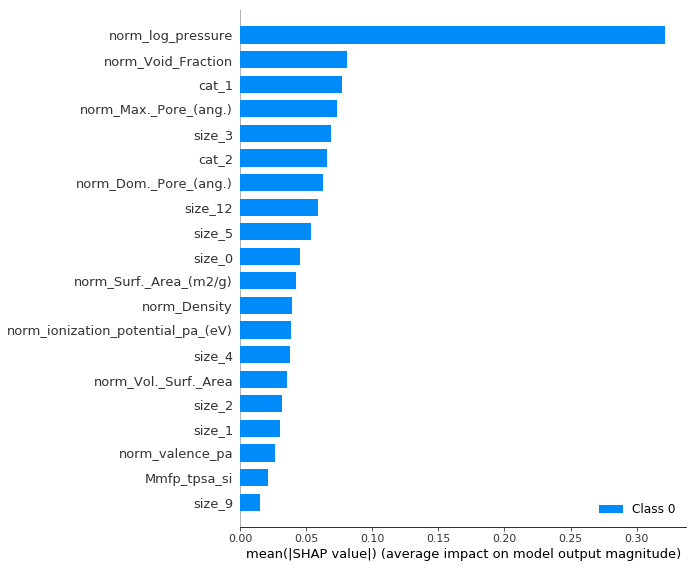

In [23]:
shap.summary_plot(shap_vals, obj.features, plot_type='bar', show=False)

# Analyze results

After making sure results_df is saved

In [14]:
df = ru.pd_load(PATH+'/results_iso_code_1011_fold_10_10_33AM_on_May_08_2020.csv')

In [15]:
df.head()

,Unnamed: 0,Filename,Pressure,Class,Prediction,Truth
0,0,hypotheticalMOF_5053773_i_1_j_27_k_27_m_7_cat_...,1.0,Train,16.783989,12.409546
1,1,hypotheticalMOF_5051526_i_1_j_27_k_5_m_9_cat_1...,1.0,Train,14.690094,14.970042
2,2,hypotheticalMOF_5004666_i_0_j_20_k_12_m_1_cat_...,1.0,Train,34.581741,11.924002
3,3,hypotheticalMOF_36515_i_2_j_17_k_6_m_2_cat_1.cif,1.0,Train,39.563179,49.924683
4,4,hypotheticalMOF_5032463_i_0_j_29_k_21_m_4_cat_...,1.0,Train,69.994133,22.993454


In [16]:
test = df[df['Class'] == 'Test']
true = test['Truth'].tolist()
pred = test['Prediction'].tolist()
pred = [max(i, 0) for i in pred]

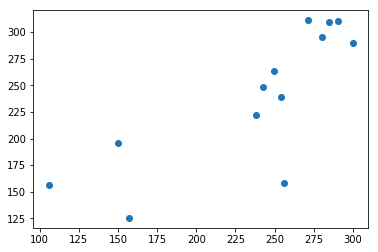

In [17]:
%matplotlib inline
plt.scatter(true, pred)

In [18]:
df = ru.pd_load(PATH+'/hp_df.csv')

In [19]:
df

,Unnamed: 0,filename,valence_pa,atomic_rad_pa_(angstroms),affinity_pa_(eV),ionization_potential_pa_(eV),electronegativity_pa,Crystal_Id,Crystal_ID#,Dom._Pore_(ang.),...,size_17,size_18,size_19,norm_vol_uptake,cat_1,cat_2,cat_3,cat_4,log_pressure,norm_log_pressure
0,0,hypotheticalMOF_5001133_i_0_j_19_k_7_m_2_cat_2...,1.2,1.232,-0.1878,10.236,2.008,-83,-83,4.25,...,-0.146257,-0.107573,-0.070888,-0.827323,0,0,1,0,0.000000,-0.992484
1,1,hypotheticalMOF_5009699_i_0_j_22_k_5_m_9_cat_2...,1.2,1.232,-0.1878,10.236,2.008,35,35,1.75,...,-0.146257,-0.107573,-0.070888,-1.076878,0,0,1,0,0.000000,-0.992484
2,2,hypotheticalMOF_3001230_i_2_j_24_k_23_m_1_cat_...,2.0,1.450,1.2360,7.730,1.900,-114,-114,12.75,...,-0.146257,-0.107573,-0.070888,-1.054830,0,0,1,0,0.000000,-0.992484
3,3,hypotheticalMOF_5022994_i_0_j_27_k_2_m_9_cat_2...,1.2,1.232,-0.1878,10.236,2.008,18,18,6.25,...,-0.146257,-0.107573,-0.070888,-0.940366,0,0,1,0,0.000000,-0.992484
4,4,hypotheticalMOF_5070517_i_2_j_24_k_19_m_2_cat_...,2.0,1.450,1.2360,7.730,1.900,-75,-75,1.75,...,-0.146257,-0.107573,-0.070888,-1.076878,0,1,0,0,0.000000,-0.992484
5,5,hypotheticalMOF_5028838_i_0_j_28_k_19_m_9_cat_...,1.2,1.232,-0.1878,10.236,2.008,-26,-26,6.25,...,-0.146257,-0.107573,-0.070888,-0.969578,0,1,0,0,0.000000,-0.992484
6,6,hypotheticalMOF_5061909_i_2_j_20_k_7_m_12.cif,2.0,1.450,1.2360,7.730,1.900,21,21,9.25,...,-0.146257,-0.107573,-0.070888,1.303599,1,0,0,0,5.513429,1.002509
7,7,hypotheticalMOF_33371_i_2_j_13_k_1_m_2.cif,2.0,1.450,1.2360,7.730,1.900,91,91,10.75,...,-0.146257,-0.107573,-0.070888,1.325678,1,0,0,0,5.513429,1.002509
8,8,hypotheticalMOF_34388_i_2_j_14_k_4_m_7.cif,2.0,1.450,1.2360,7.730,1.900,84,84,4.75,...,-0.146257,-0.107573,-0.070888,0.830107,1,0,0,0,5.513429,1.002509
9,9,hypotheticalMOF_22358_i_1_j_12_k_3_m_4.cif,2.0,1.420,-0.6000,9.390,1.650,86,86,3.25,...,-0.146257,-0.107573,-0.070888,-0.196065,1,0,0,0,5.513429,1.002509


Analyze predfined splits

In [64]:
with open(PATH+'/file_tracker_iso_code_1011_01_01PM_on_May_09_2020.pkl', 'rb') as f:
    tracker1 = pickle.load(f)

In [65]:
with open(PATH+'/file_tracker_iso_code_1011_01_32PM_on_May_09_2020.pkl', 'rb') as f:
    tracker2 = pickle.load(f)

In [66]:
tracker1 == tracker2

True

# Scratch

In [4]:
a = np.array([1,3,2])

In [22]:
a.argmax()

1

In [18]:
b = {'a':[1]}

In [19]:
b['a'].append(2)

In [20]:
b

{'a': [1, 2]}

In [3]:
a = pd.DataFrame({'a':['hi','me']}).to_numpy()

In [8]:
np.random.randint(0, len(a), size=, )

array([2, 2])

In [9]:
np.random.choice(a, size=2, replace=False)

array([3, 2])